# Importing Packages and Basic Parameters

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import scipy.io as sio
import pickle
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import pygad

from scipy import stats
from os import listdir
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Average, Concatenate, GRU, Bidirectional, LeakyReLU, Dense, Dropout, Input, Convolution1D, Layer, Add
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error, binary_crossentropy 
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
# import sr_ecg
random_seed = 34
batch_size = 64
num_classes = 5
epochs = 500
#decide the GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
data_folder_path = './Training Dataset/'
data_folder_path2 = './Public Testing Dataset/'
data_folder_path3 = './Private Testing Dataset/'

# CPU and GPU Checking

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ESRNet Data Combining

In [1]:
!mkdir "Training Dataset"
!unzip "Training Dataset.zip" -d ./
!rm "Training Dataset.zip"

cp: cannot stat './gdrive/MyDrive/ColabNotebooks/Competitions/AICup/Training Dataset.zip': No such file or directory
unzip:  cannot find or open Training Dataset.zip, Training Dataset.zip.zip or Training Dataset.zip.ZIP.
rm: cannot remove 'Training Dataset.zip': No such file or directory


In [ ]:
!ls "Training Dataset"  

'AI CUP_codebook.xlsx'	'training datalist.csv'   training_voice_data


In [ ]:
dataList = listdir(data_folder_path+"/training_voice_data")
len(dataList)

1000

# MetforNetEF Data Combining

In [ ]:
TrainTable = pd.read_csv(data_folder_path+"/training datalist.csv")
TrainTable.head()

,ID,Sex,Age,Disease category,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,1202f15,2,39,1,1,1,1,1,1,0,...,2,3,1,0,0,0,0,0,0,22.0
1,0600ve0,1,69,2,1,1,1,1,0,0,...,2,1,3,0,0,0,0,0,1,19.0
2,1001o7l,2,59,2,1,1,1,1,0,0,...,2,3,4,0,0,0,0,0,0,18.0
3,1201c1t,2,47,1,1,0,1,1,1,0,...,3,1,1,0,0,0,0,0,0,27.0
4,0402jvt,1,87,1,0,0,0,0,0,0,...,1,1,4,0,1,0,0,0,0,16.0


In [ ]:
TrainTable.columns

Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')

In [ ]:
numerical = TrainTable[['ID', 'Disease category', 'Age','PPD', 'Voice handicap index - 10']].copy()
categorical = TrainTable[['Sex', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA']].copy().astype('str')
categorical = pd.get_dummies(categorical).copy()
categorical['ID'] = TrainTable['ID']

In [ ]:
TrainTable = pd.merge(numerical, categorical, on="ID")
TrainTable.head()

,ID,Disease category,Age,PPD,Voice handicap index - 10,Sex_1,Sex_2,Narrow pitch range_0,Narrow pitch range_1,Decreased volume_0,...,Hypertension_0,Hypertension_1,CAD_0,CAD_1,Head and Neck Cancer_0,Head and Neck Cancer_1,Head injury_0,Head injury_1,CVA_0,CVA_1
0,1202f15,1,39,NaN,22.0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
1,0600ve0,2,69,NaN,19.0,1,0,0,1,0,...,1,0,1,0,1,0,1,0,0,1
2,1001o7l,2,59,NaN,18.0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
3,1201c1t,1,47,0.2,27.0,0,1,0,1,1,...,1,0,1,0,1,0,1,0,1,0
4,0402jvt,1,87,NaN,16.0,1,0,1,0,1,...,0,1,1,0,1,0,1,0,1,0


In [ ]:
TrainTable.values[:,2:].shape

(1000, 62)

In [ ]:
AllCol = TrainTable.columns[2:]
np.save('./AllCol',AllCol)
AllCol = np.load('./AllCol.npy', allow_pickle=True)
AllCol

array(['Age', 'PPD', 'Voice handicap index - 10', 'Sex_1', 'Sex_2',
       'Narrow pitch range_0', 'Narrow pitch range_1',
       'Decreased volume_0', 'Decreased volume_1', 'Fatigue_0',
       'Fatigue_1', 'Dryness_0', 'Dryness_1', 'Lumping_0', 'Lumping_1',
       'heartburn_0', 'heartburn_1', 'Choking_0', 'Choking_1',
       'Eye dryness_0', 'Eye dryness_1', 'PND_0', 'PND_1', 'Smoking_0',
       'Smoking_1', 'Smoking_2', 'Smoking_3', 'Drinking_0', 'Drinking_1',
       'Drinking_2', 'frequency_0', 'frequency_1', 'frequency_2',
       'frequency_3', 'Diurnal pattern_1', 'Diurnal pattern_2',
       'Diurnal pattern_3', 'Diurnal pattern_4', 'Onset of dysphonia _1',
       'Onset of dysphonia _2', 'Onset of dysphonia _3',
       'Onset of dysphonia _4', 'Onset of dysphonia _5',
       'Noise at work_1', 'Noise at work_2', 'Noise at work_3',
       'Occupational vocal demand_1', 'Occupational vocal demand_2',
       'Occupational vocal demand_3', 'Occupational vocal demand_4',
       'Diab

In [ ]:
dataXList = TrainTable['ID'].values.copy()
dataYList = (TrainTable['Disease category'].values.astype('int').copy()-1).astype('int')

In [ ]:
dataXList.shape, dataYList.shape

((1000,), (1000,))

In [ ]:
dataXList

array(['1202f15', '0600ve0', '1001o7l', '1201c1t', '0402jvt', '1102ial',
       '0K024ja', '00003h4', '1101t8u', '11019sl', '1100jkh', '0801ifi',
       '0T000fb', '1101fh2', '0402svh', '0T0018b', '1300ams', '1102hc2',
       '0T00ufl', '11014l7', '0T01uvq', '1202n63', '12007bm', '1102vjo',
       '1101ko5', '0402sfe', '0100o4g', '1102eos', '0A00gqr', '1202boh',
       '0S024o5', '0502kms', '0400vh4', '110296t', '0301s42', '0B00jdl',
       '11022i7', '1000g13', '1100hda', '0R00fio', '0002ipt', '00002mg',
       '1101ds4', '12018r8', '1302h9l', '1100eia', '1102kso', '1100kft',
       '0J02cnd', '1202io9', '1102oi8', '0702erg', '1100ovc', '1201s3m',
       '0W01o99', '1001vum', '1202n51', '12007ja', '12027pq', '1201s1c',
       '1201mhj', '02011g8', '1101dr2', '1102hm3', '1100pv9', '0902c4u',
       '0000jil', '0K01njp', '13005st', '11023kk', '10020ll', '0100ilb',
       '1000rbo', '0J02v9t', '0300rbi', '1001ar5', '1100j1i', '0702vvf',
       '1102rot', '0102d2s', '1200sn6', '1001g6p', 

In [ ]:
# import librosa
import soundfile as sf
maxLength = 0
maxLength2 = 0
for i in tqdm(range(len(dataXList))):
    print(dataXList[i])
    ref, rate = sf.read(data_folder_path+"training_voice_data/"+str(dataXList[i])+".wav")    
    refLength = len(ref)

    if maxLength <= refLength:
      maxLength = refLength
      print(maxLength, rate)

  4%|▍         | 41/1000 [00:00<00:02, 399.80it/s]

1202f15
88200 44100
0600ve0
132300 44100
1001o7l
1201c1t
0402jvt
132300 44100
1102ial
132300 44100
0K024ja
00003h4
132300 44100
1101t8u
132300 44100
11019sl
132300 44100
1100jkh
132300 44100
0801ifi
132300 44100
0T000fb
1101fh2
132300 44100
0402svh
0T0018b
1300ams
1102hc2
132300 44100
0T00ufl
11014l7
132300 44100
0T01uvq
1202n63
12007bm
132300 44100
1102vjo
1101ko5
0402sfe
132300 44100
0100o4g
1102eos
0A00gqr
1202boh
0S024o5
0502kms
132300 44100
0400vh4
132300 44100
110296t
0301s42
132300 44100
0B00jdl
132300 44100
11022i7
1000g13
132300 44100
1100hda
132300 44100
0R00fio
0002ipt
132300 44100
00002mg
1101ds4
132300 44100
12018r8
1302h9l
1100eia
132300 44100
1102kso
132300 44100
1100kft
132300 44100
0J02cnd
1202io9
1102oi8
132300 44100
0702erg
1100ovc
132300 44100
1201s3m
132300 44100
0W01o99
1001vum
132300 44100
1202n51
132300 44100
12007ja
132300 44100
12027pq
1201s1c
132300 44100
1201mhj
02011g8
1101dr2
132300 44100
1102hm3
132300 44100
1100pv9
132300 44100
0902c4u
132300 44100
0000j

 12%|█▏        | 120/1000 [00:00<00:02, 371.18it/s]

132300 44100
1100j1i
132300 44100
0702vvf
132300 44100
1102rot
132300 44100
0102d2s
132300 44100
1200sn6
132300 44100
1001g6p
132300 44100
1102kj1
0W01nta
11015lb
132300 44100
1001shb
132300 44100
1301jit
0B01ir9
0501tkf
132300 44100
1101emo
132300 44100
080123i
1201tc7
00022fq
0B02ikd
10012no
132300 44100
12018po
1001i7a
132300 44100
12001l5
1200841
132300 44100
05023dl
132300 44100
12018ns
132300 44100
12029bd
132300 44100
1001nt8
132300 44100
11013d3
13026j7
0000i84
132300 44100
110269b
132300 44100
1201j5l
132300 44100
0C02ccf
120246l
132300 44100
1101dof
132300 44100
1102k2d
132300 44100
1201l90
1000p0e
132300 44100
1201fcg
11017j9
132300 44100
04006u2
0102a0u
132300 44100
12026bi
070134s
132300 44100
1102t1k
132300 44100
1101cjo
0600ord
132300 44100
10017kr
132300 44100
0G01ssi
1101k85
132300 44100
11027nc
132300 44100
1202ovc
132300 44100
10005ko
1100nun
132300 44100
1201d09
1102t51
1202o9t
132300 44100
1202cak
0302fmr
132300 44100
09000c9
0502mfl
132300 44100
0K0097o
1202v84
13

 20%|█▉        | 196/1000 [00:00<00:02, 368.08it/s]

1101n9c
0J015c1
132300 44100
0A021fv
1102hbe
0400mns
1002j2n
12026lv
11012n8
132300 44100
1101t9a
1101cmb
132300 44100
1100dpi
12023dv
132300 44100
1201u9h
1101kop
1100n4p
132300 44100
0001hec
132300 44100
1202rdv
1301ubr
132300 44100
1202cb1
132300 44100
1201tbt
1101811
132300 44100
1202pc6
1302358
0102iff
132300 44100
0600e4t
132300 44100
1102oii
1101s2i
132300 44100
0T02s69
06014ma
132300 44100
1002u7a
132300 44100
1201pkt
132300 44100
1100f0u
132300 44100
11016nt
132300 44100
0R00nd2
110309v
132300 44100
06023b2
1200866
132300 44100
0001apo
132300 44100
1200meh
132300 44100
13005es
132300 44100
1102450
132300 44100
1201mhi
1001bih
132300 44100
1201pke
132300 44100
1102hm8
132300 44100
11011ho
132300 44100
0602o2b
1001u8n
132300 44100
11029qi
132300 44100
110223m
1202s6i
110126b
132300 44100
0C027p3
12009rh
132300 44100
1100jcs
132300 44100
1202bm8
09029t8
132300 44100
1201sig
132300 44100
1202h6f
132300 44100
12028sb
132300 44100
11017i0
1102sa7
132300 44100
1100tt2
132300 44100
0T

 27%|██▋       | 270/1000 [00:00<00:02, 357.57it/s]


1102tn3
0C013db
1100rbe
0600q1h
132300 44100
0602goc
132300 44100
12000u8
132300 44100
0T01i1g
1102pas
132300 44100
1102ng1
132300 44100
1001b43
132300 44100
1100sqq
132300 44100
05001hk
132300 44100
0200l33
132300 44100
09017bb
132300 44100
0R000qh
0902d6j
0001pvo
132300 44100
1101ba1
1201msg
132300 44100
1202jl4
132300 44100
0B00uql
1101rfa
11014lg
132300 44100
11025t2
132300 44100
0401ibg
132300 44100
11014kh
132300 44100
1102edk
132300 44100
0400og6
132300 44100
1002c0q
1201fum
132300 44100
0500kug
132300 44100
10021t7
1102d8u
132300 44100
05024bo
132300 44100
1200ak8
132300 44100
1202boa
0001pte
132300 44100
0101c0u
12006h7
132300 44100
1200vmc
1102u3k
12001mk
1202u5o
132300 44100
07006qe
132300 44100
1202s7o
132300 44100
1202ef3
0201917
132300 44100
12018r6
0M02b3j
0802gj3
1202avj
0401vok
132300 44100
1201tum
07022sc
132300 44100
0200r3p
132300 44100
1202v7c
132300 44100
1100omj
132300 44100
1202kc5
132300 44100
0502b1v
0002d4p
132300 44100
10011nv
132300 44100
1202pa1
09028u4
1

 34%|███▍      | 344/1000 [00:00<00:01, 358.18it/s]

0R00td9
0902gco
132300 44100
1101gsm
132300 44100
0901p20
132300 44100
120169g
132300 44100
1301ag6
132300 44100
110296i
0T00osj
10011ir
132300 44100
0J01tgu
1100rb9
1000q6p
1100cak
132300 44100
04030pt
132300 44100
0803014
1101i8k
132300 44100
01019og
132300 44100
1201emt
01012en
132300 44100
1001mie
132300 44100
1101l4o
12017qh
132300 44100
12025mg
132300 44100
13028p5
11001kv
132300 44100
120003k
132300 44100
13021jg
1002j1u
0U00kng
1202jia
132300 44100
1101g14
132300 44100
1102rol
11026di
132300 44100
0T00nj6
1301mt8
11022id
1102cnk
132300 44100
1202u3l
132300 44100
12008ri
132300 44100
1201cut
132300 44100
1102rpb
0K002gh
0701uiv
132300 44100
12028se
132300 44100
1102s9h
132300 44100
11006j7
132300 44100
0800msc
132300 44100
1002ied
132300 44100
1100mrs
132300 44100
1102vm8
132300 44100
1100caq
132300 44100
09015b1
132300 44100
1102o5d
132300 44100
1201kuh
1101hve
132300 44100
120037a
132300 44100
1101edc
132300 44100
1100bc7
11011sn
1201qik
1101n8v
1202a46
1102707
132300 44100
12

 43%|████▎     | 432/1000 [00:01<00:01, 395.78it/s]

132300 44100
0800k07
132300 44100
0302drk
132300 44100
0500nb9
0302irr
132300 44100
1001bha
132300 44100
1100ukv
11017jh
132300 44100
1101aue
132300 44100
0202cfe
132300 44100
11030am
132300 44100
1202qi3
132300 44100
0800dgv
060260n
132300 44100
120269s
132300 44100
1102jid
132300 44100
1100llh
120049c
1101vcr
0601ntf
1001ghr
132300 44100
0902sff
132300 44100
1001jlh
132300 44100
12017p6
1201rg0
132300 44100
0G02i0b
132300 44100
12003pb
132300 44100
120200g
0402bgm
132300 44100
1101aug
132300 44100
1102hli
132300 44100
1102tm7
0900pis
132300 44100
11016b3
0A00ai3
132300 44100
0S01nqh
120057l
132300 44100
0501925
1202cbo
132300 44100
1101cb7
1201shv
132300 44100
0801q5t
132300 44100
12029lv
132300 44100
11030qs
132300 44100
12024lq
132300 44100
1102iap
132300 44100
12020nt
1100u9s
132300 44100
0702nkv
132300 44100
0802vti
132300 44100
07002ij
110223e
11016ol
132300 44100
1001i3p
132300 44100
1200os5
132300 44100
0800jur
132300 44100
12015ip
132300 44100
12001o0
132300 44100
0202n8m
132

 54%|█████▍    | 540/1000 [00:01<00:00, 463.24it/s]

132300 44100
02022d3
132300 44100
12001n2
1201241
090120p
132300 44100
07017ip
132300 44100
1002oo3
0500h73
132300 44100
11030qu
132300 44100
1102o3g
132300 44100
1301qfd
132300 44100
1102hmo
1101g2v
132300 44100
1102tka
1100k2s
0U00gnr
1101m5o
132300 44100
0901eu6
05024l5
0201813
12027re
1102jkl
132300 44100
1201l8a
12025o3
0601ead
132300 44100
0F01eln
132300 44100
0C00hhm
132300 44100
01012ss
132300 44100
120119p
0402eon
132300 44100
12002i1
132300 44100
1100vo4
0602ti5
132300 44100
1200536
132300 44100
1102up1
110156l
132300 44100
1102rqu
0Y01h50
1201hp2
132300 44100
1202g06
0600ql2
1002ecf
1201q87
132300 44100
1101l4b
1201dm5
132300 44100
1102jjq
132300 44100
12026c7
1201gaq
132300 44100
1101seg
132300 44100
0902idd
132300 44100
1102u4b
1202kcd
132300 44100
05014vg
1101rga
132300 44100
0M00oom
1202clm
132300 44100
1101iup
1200373
132300 44100
1301sl8
132300 44100
1201c1n
132300 44100
120061e
132300 44100
0900g6t
132300 44100
1001kcu
09026ug
0102vaf
1202kvf
132300 44100
11028pn
1323

 63%|██████▎   | 632/1000 [00:01<00:00, 431.53it/s]

132300 44100
12021nj
132300 44100
1101hd3
132300 44100
04029dq
132300 44100
1101e7e
0900end
132300 44100
1100bea
1101p4t
0M02h83
07007lf
132300 44100
0002m5r
132300 44100
1102101
132300 44100
1001vv0
132300 44100
1101drt
132300 44100
10026m9
132300 44100
0G02h14
132300 44100
1102cn7
1202lcm
132300 44100
1101seb
132300 44100
0700b87
132300 44100
1001gg3
132300 44100
1201rfr
132300 44100
1101l4q
132300 44100
11025b5
132300 44100
0802gp4
132300 44100
10025r6
132300 44100
0B011fb
0901g2l
132300 44100
12028s1
132300 44100
12017vj
132300 44100
0K0252k
120085l
12013di
132300 44100
1100sqm
132300 44100
1102jmb
1000u66
132300 44100
0100v91
132300 44100
070293d
1202t6l
132300 44100
1101jl2
1102c6h
132300 44100
120233i
132300 44100
0702nct
132300 44100
06008hr
132300 44100
0602hp7
132300 44100
1001p7m
132300 44100
12025n6
132300 44100
1202s94
132300 44100
0701tmj
132300 44100
040318e
132300 44100
11029gt
1201j79
1100t99
1202e79
132300 44100
1201vnp
1102aca
132300 44100
0500a7j
132300 44100
0902g3

 73%|███████▎  | 733/1000 [00:01<00:00, 465.51it/s]

132300 44100
0F00d4r
132300 44100
11017vu
132300 44100
0A007p1
1101260
132300 44100
0T02udg
0601kia
0M017jq
132300 44100
0802469
132300 44100
1001ach
132300 44100
1101qsp
0200fba
132300 44100
12017m3
1102bpm
132300 44100
1001vhm
132300 44100
0700lo9
12004b0
02017ef
132300 44100
0002aor
11011tb
1102mo3
132300 44100
11030qk
132300 44100
04015os
0102itt
132300 44100
1101dci
132300 44100
0002iop
132300 44100
1101gpc
132300 44100
0201cvj
132300 44100
1101itq
132300 44100
1100lnt
132300 44100
1001ntg
1100ond
132300 44100
1100tkh
1200t6q
132300 44100
1001brv
132300 44100
0302li9
132300 44100
0102504
132300 44100
1201mui
132300 44100
0W029ar
1100jd9
132300 44100
1202n6s
0502l1d
132300 44100
1102ioh
132300 44100
1102nie
132300 44100
0J01lnr
0U00m1l
0101s62
132300 44100
1102ba0
132300 44100
12007eg
132300 44100
1101drd
132300 44100
1101818
132300 44100
1102sa2
132300 44100
0902db2
132300 44100
1002fki
132300 44100
050296l
132300 44100
12000jk
132300 44100
1202oa2
132300 44100
12028sh
132300 4410

 84%|████████▎ | 836/1000 [00:01<00:00, 490.44it/s]

132300 44100
0H02j6q
1200qq0
132300 44100
1100elr
132300 44100
030163q
132300 44100
1100k2j
132300 44100
1202o9j
132300 44100
1302hmq
12027af
1101m55
132300 44100
1002nhi
132300 44100
0C0003h
1100qca
132300 44100
1101b3b
132300 44100
11024i9
132300 44100
1101fh1
132300 44100
1101ba4
1201j74
132300 44100
0701fjn
132300 44100
1201j6c
132300 44100
11011s2
132300 44100
1102m8p
120001s
132300 44100
1102di6
0701355
132300 44100
1101btn
01027b0
1201afc
132300 44100
1001u83
0000mfg
132300 44100
1002181
132300 44100
0200f4q
132300 44100
0T00dcu
1002mrr
132300 44100
09019h6
132300 44100
1002ulv
132300 44100
10002dl
1101enr
132300 44100
0501dei
12021dd
1201720
1101qfc
1101btc
132300 44100
0401h6i
132300 44100
1002765
132300 44100
12004ei
0J00379
1102oia
11022f5
132300 44100
0T00otu
0T00mg6
11027pn
132300 44100
1201dnp
0S02h6i
11003tf
1001kmt
1201u9j
12026bd
1202l08
1102br1
132300 44100
05014o4
050171h
08012kj
132300 44100
1102ioq
132300 44100
1100g3h
132300 44100
1000g96
132300 44100
0702ulb
1323

 94%|█████████▍| 945/1000 [00:02<00:00, 515.39it/s]

132300 44100
0001297
12026m2
12029ti
12000us
0102la3
132300 44100
09018ni
11027gm
1201c1q
11013dg
132300 44100
1201jhf
11030kc
132300 44100
1100ctl
132300 44100
1100ihu
132300 44100
12029in
132300 44100
0F01dug
132300 44100
0402lum
132300 44100
1202lc4
132300 44100
1201vfl
1000jgs
132300 44100
1102kcc
132300 44100
110125n
1201mt0
132300 44100
1201ji7
1201cl1
132300 44100
12011qo
0001qd3
132300 44100
12003n5
132300 44100
1001nsu
132300 44100
1202kvb
132300 44100
1101brj
132300 44100
1102vm7
132300 44100
1101km0
132300 44100
0501slq
132300 44100
1000dsk
132300 44100
1201vmn
1100pic
132300 44100
11014al
12003p0
132300 44100
1100iib
132300 44100
1202l2k
1100h50
1100obm
132300 44100
06012h1
132300 44100
0T00tmc
11013cv
1101ut9
0501iao
0501j3o
132300 44100
1202dep
132300 44100
110222t
132300 44100
1002feh
132300 44100
1101b9k
0501mc5
132300 44100
12025pf
132300 44100
1002auh
0701css
132300 44100
1101vp3
132300 44100
11016mo
1000otg
132300 44100
1201p2a
132300 44100
1202eec
132300 44100
0S009

100%|██████████| 1000/1000 [00:02<00:00, 432.29it/s]

12004an
0402q3e
1201igd
11025aa
132300 44100
0300ahf
132300 44100
1102ame
132300 44100
12000u9
1001vd9
132300 44100
1101m6h
132300 44100
0100os0
132300 44100
1102mbb
132300 44100
1100f1g
0401o0u
11010oc
132300 44100
10009l0
132300 44100
11020i1
132300 44100
1100qj5
100241q
132300 44100
11012oq
1202gvi
132300 44100
12015gb
132300 44100
1102hmk
132300 44100
1201pl2
132300 44100
0T022un
0G00ftn
1201pkr
132300 44100
0202p64
12021au
04027it
132300 44100


In [ ]:
maxLength

132300

In [ ]:
X_list = []
Y_list = []
for i in tqdm(range(len(dataXList))):
    patient = np.zeros((132300,1), dtype=np.float32)
    rawValues, rate = sf.read(data_folder_path+"training_voice_data/"+str(dataXList[i])+".wav")
    mu = np.nanmean(rawValues)
    std = np.nanstd(rawValues)
    patient[-len(rawValues):,0] = (rawValues-mu)/std

    X_list.append(patient)
    Y_list.append(dataYList[i])
X_list = np.asarray(X_list)
Y_list = np.asarray(Y_list)
print(X_list.shape, Y_list.shape)

100%|██████████| 1000/1000 [00:02<00:00, 345.33it/s]


(1000, 132300, 1) (1000,)


In [ ]:
np.save('./AICupX_list',X_list)
np.save('./AICupY_list',Y_list)

In [ ]:
!ls

 gdrive   sample_data  'Training Dataset'


In [ ]:
X_list_label = TrainTable.copy()
X_list_label.values[:,2:5].shape

(1000, 3)

In [ ]:
mus = []
stds = []
for i in range(3):
  mu = np.nanmean(X_list_label[AllCol[i]].astype('float32'))
  std = np.nanstd(X_list_label[AllCol[i]].astype('float32'))
  X_list_label[AllCol[i]] = (X_list_label[AllCol[i]].astype('float32')-mu)/std
  X_list_label[AllCol[i]] = X_list_label[AllCol[i]].fillna(0).copy()
  mus.append(mu)
  stds.append(std)
CODAMuStd = np.asarray([mus,stds])
CODAMuStd

array([[48.614    ,  0.7964673, 23.090635 ],
       [15.190886 ,  0.4638579,  9.321377 ]], dtype=float32)

In [ ]:
np.save('./AICupMuStd',CODAMuStd)

In [ ]:
CODAMuStd = np.load('./AICupMuStd.npy', allow_pickle=True).astype('float32')
CODAMuStd

array([[48.614    ,  0.7964673, 23.090635 ],
       [15.190886 ,  0.4638579,  9.321377 ]], dtype=float32)

In [ ]:
X_list_label

,ID,Disease category,Age,PPD,Voice handicap index - 10,Sex_1,Sex_2,Narrow pitch range_0,Narrow pitch range_1,Decreased volume_0,...,Hypertension_0,Hypertension_1,CAD_0,CAD_1,Head and Neck Cancer_0,Head and Neck Cancer_1,Head injury_0,Head injury_1,CVA_0,CVA_1
0,1202f15,1,-0.632879,0.000000,-0.117004,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
1,0600ve0,2,1.341989,0.000000,-0.438845,1,0,0,1,0,...,1,0,1,0,1,0,1,0,0,1
2,1001o7l,2,0.683700,0.000000,-0.546125,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
3,1201c1t,1,-0.106248,-1.285884,0.419398,0,1,0,1,1,...,1,0,1,0,1,0,1,0,1,0
4,0402jvt,1,2.526910,0.000000,-0.760685,1,0,1,0,1,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0G00ftn,3,1.736963,0.000000,-0.224284,1,0,1,0,1,...,0,1,0,1,1,0,1,0,1,0
996,1201pkr,4,-0.567050,0.000000,-0.224284,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
997,0202p64,3,1.276160,0.000000,0.419398,0,1,1,0,0,...,1,0,1,0,1,0,1,0,1,0
998,12021au,2,-0.435393,0.000000,-1.189807,0,1,1,0,1,...,1,0,1,0,1,0,1,0,1,0


In [ ]:
np.save('./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/AICupX_list_label',X_list_label.values[:,2:])

In [ ]:
X_list_label.values[:,2:].shape

(1000, 62)

# MetforNetEF Data Preprocessing

In [ ]:
X_list = np.load('./AICupX_list.npy',allow_pickle=True).astype('float32')
Y_list = np.load('./AICupY_list.npy',allow_pickle=True).astype('int32')
X_list_label = np.load('./AICupX_list_label.npy',allow_pickle=True).astype('float32')

In [ ]:
X_list_label.shape

(1000, 62)

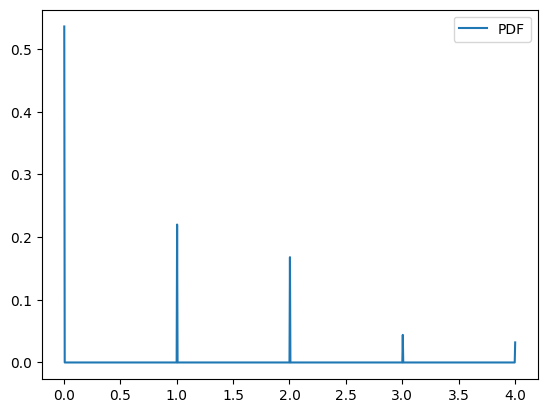

In [ ]:
data = Y_list
count, bins_count = np.histogram(data, bins=1000)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, label="PDF")
plt.legend()
# plt.ylim([-0.01, 0.08])
# plt.xlim([-0.01, 1.0])
plt.show()

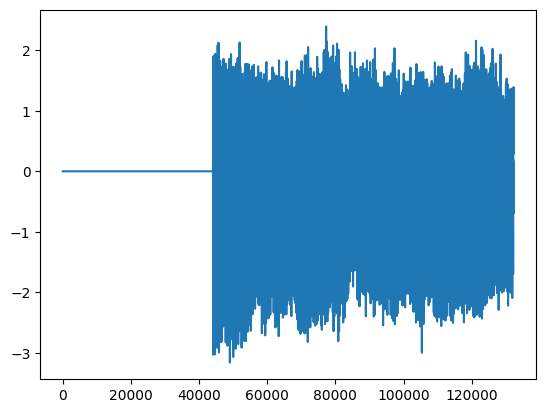

In [ ]:
plt.plot(X_list[0,:,0])
# plt.ylim([-6.0, 1.0])
plt.show()

# MetforNetEF Splitting Train-Validation Data

In [ ]:
X = X_list
y = Y_list
skf = StratifiedKFold(n_splits=60, random_state = random_seed, shuffle=True)
skf.get_n_splits(X, y)
print(skf)  
FoldIndicesList = []
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    FoldIndicesList.append((train_index,test_index))
FoldIndicesList = np.asarray(FoldIndicesList)
np.save('./AICupFoldIndicesList',FoldIndicesList)
FoldIndicesList = np.load('./AICupFoldIndicesList.npy',allow_pickle=True)

In [ ]:
FoldIndicesList.shape

(60, 2)

# MetforNetEF Architecture

In [ ]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs): 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform') 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer) 
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint) 
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint) 
            self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint) 
        super(AttentionWithContext, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        return None
 
    def call(self, x, mask=None):
        uit = dot_product(x, self.W) 
        if self.bias:
            uit += self.b 
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u) 
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx()) 
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [ ]:
#model structure
def MetforNet121(length):
  
    main_input = Input(shape=(length,1), dtype='float32', name='main_input')
    x = Convolution1D(12, 3, padding='same')(main_input)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 48, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    cnnout = Dropout(0.2)(x)
    x = Bidirectional(GRU(12,return_sequences=True,return_state=False))(cnnout)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    main_output = Dense(num_classes,activation='sigmoid')(x)

    return Model(inputs=main_input, outputs=main_output)
model = MetforNet121(5513)
print(model.summary())

Model: "model"
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 5513, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 5513, 12)          48        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5513, 12)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5513, 12)          444       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5513, 12)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2757, 12)          3468      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2757, 12)          0         
                                                                 
 dropout (

In [ ]:
#model structure
def MetforNetEF(length, model, repeat_num=1):
  
    main_input2 = Input(shape=(62,), dtype='float32', name='main_input2')
    x_input = model.layers[-2].output

    for i in range(repeat_num):

        x = Concatenate(axis = -1)([x_input, main_input2])
        x = Dense(24,activation=None)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.3)(x)
        x_input = Dropout(0.2)(x)

    x = Dense(num_classes,activation='tanh')(x_input)
    main_output = Add()([x, model.layers[-1].output])

    return Model(inputs=[model.input, main_input2], outputs=[main_output, model.layers[-1].output])
model = MetforNetEF(5513,MetforNet121(5513), 10)
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 5513, 1)]    0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 5513, 12)     48          ['main_input[0][0]']             
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 5513, 12)     0           ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 5513, 12)     444         ['leaky_re_lu_17[0][0]']         
                                                                                            

In [ ]:
def f1(y_true, y_pred2):
    y_pred = K.clip(K.one_hot(K.argmax(y_pred2),num_classes=num_classes), 0, 1)
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# MetforNet Model Training and 60-fold Cross Validation



In [ ]:
Y_list = np.eye(5)[Y_list]
Y_list.shape

(1000, 5)

In [ ]:
#10-fold training
FoldIndicesList = np.load('./AICupFoldIndicesList.npy',allow_pickle=True)
lr = 0.001
epochs = 100
for i in range(60):
    model_name = 'AICup_10folds_sigmoid_double_separate_fold_'+str(i)
    x_train_from_train = X_list[np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
    x_val_from_train = X_list[FoldIndicesList[i-1][1]]
    x_train_from_train_label = X_list_label[np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
    x_val_from_train_label = X_list_label[FoldIndicesList[i-1][1]]
    y_train_from_train = Y_list[np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
    y_val_from_train = Y_list[FoldIndicesList[i-1][1]]
    pre_model = MetforNet121(132300)
    model = MetforNetEF(132300,pre_model, 1)
    opt = keras.optimizers.Adam(lr=lr)
    model.compile(loss=mean_squared_error,
                optimizer=opt,
                metrics=[f1])
    checkpointer = ModelCheckpoint('./double_separate/'+model_name, verbose=1, save_best_only=True)
    model_history = model.fit( [x_train_from_train, x_train_from_train_label], [y_train_from_train,y_train_from_train],
                            batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                            validation_data=([x_val_from_train, x_val_from_train_label], [y_val_from_train,y_val_from_train]))
    with open('./double_separate/'+model_name+'_history.pickle', 'wb') as file:
        pickle.dump(model.history.history, file)


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.8430 - add_1_loss: 0.5981 - dense_13_loss: 0.2449 - add_1_f1: 0.2549 - dense_13_f1: 0.4453
Epoch 1: val_loss improved from inf to 0.73479, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 65s 2s/step - loss: 0.8430 - add_1_loss: 0.5981 - dense_13_loss: 0.2449 - add_1_f1: 0.2549 - dense_13_f1: 0.4453 - val_loss: 0.7348 - val_add_1_loss: 0.4940 - val_dense_13_loss: 0.2408 - val_add_1_f1: 0.0000e+00 - val_dense_13_f1: 0.1875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6889 - add_1_loss: 0.4666 - dense_13_loss: 0.2223 - add_1_f1: 0.3613 - dense_13_f1: 0.4404
Epoch 2: val_loss improved from 0.73479 to 0.62774, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 27s 2s/step - loss: 0.6889 - add_1_loss: 0.4666 - dense_13_loss: 0.2223 - add_1_f1: 0.3613 - dense_13_f1: 0.4404 - val_loss: 0.6277 - val_add_1_loss: 0.4000 - val_dense_13_loss: 0.2278 - val_add_1_f1: 0.0000e+00 - val_dense_13_f1: 0.6250
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5987 - add_1_loss: 0.3959 - dense_13_loss: 0.2028 - add_1_f1: 0.4102 - dense_13_f1: 0.4736
Epoch 3: val_loss improved from 0.62774 to 0.52793, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.5987 - add_1_loss: 0.3959 - dense_13_loss: 0.2028 - add_1_f1: 0.4102 - dense_13_f1: 0.4736 - val_loss: 0.5279 - val_add_1_loss: 0.3148 - val_dense_13_loss: 0.2131 - val_add_1_f1: 0.0000e+00 - val_dense_13_f1: 0.5625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.5158 - add_1_loss: 0.3247 - dense_13_loss: 0.1911 - add_1_f1: 0.4805 - dense_13_f1: 0.4990
Epoch 4: val_loss improved from 0.52793 to 0.47535, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 30s 2s/step - loss: 0.5158 - add_1_loss: 0.3247 - dense_13_loss: 0.1911 - add_1_f1: 0.4805 - dense_13_f1: 0.4990 - val_loss: 0.4754 - val_add_1_loss: 0.2691 - val_dense_13_loss: 0.2062 - val_add_1_f1: 0.0625 - val_dense_13_f1: 0.5625
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4576 - add_1_loss: 0.2780 - dense_13_loss: 0.1796 - add_1_f1: 0.5117 - dense_13_f1: 0.4863
Epoch 5: val_loss improved from 0.47535 to 0.42679, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.4576 - add_1_loss: 0.2780 - dense_13_loss: 0.1796 - add_1_f1: 0.5117 - dense_13_f1: 0.4863 - val_loss: 0.4268 - val_add_1_loss: 0.2263 - val_dense_13_loss: 0.2005 - val_add_1_f1: 0.1875 - val_dense_13_f1: 0.4375
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4263 - add_1_loss: 0.2510 - dense_13_loss: 0.1753 - add_1_f1: 0.5186 - dense_13_f1: 0.4893
Epoch 6: val_loss improved from 0.42679 to 0.39433, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.4263 - add_1_loss: 0.2510 - dense_13_loss: 0.1753 - add_1_f1: 0.5186 - dense_13_f1: 0.4893 - val_loss: 0.3943 - val_add_1_loss: 0.2005 - val_dense_13_loss: 0.1938 - val_add_1_f1: 0.3750 - val_dense_13_f1: 0.5625
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.3967 - add_1_loss: 0.2288 - dense_13_loss: 0.1679 - add_1_f1: 0.5410 - dense_13_f1: 0.5303
Epoch 7: val_loss improved from 0.39433 to 0.35420, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.3967 - add_1_loss: 0.2288 - dense_13_loss: 0.1679 - add_1_f1: 0.5410 - dense_13_f1: 0.5303 - val_loss: 0.3542 - val_add_1_loss: 0.1817 - val_dense_13_loss: 0.1725 - val_add_1_f1: 0.5000 - val_dense_13_f1: 0.6250
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3776 - add_1_loss: 0.2141 - dense_13_loss: 0.1635 - add_1_f1: 0.5547 - dense_13_f1: 0.5391
Epoch 8: val_loss improved from 0.35420 to 0.35318, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.3776 - add_1_loss: 0.2141 - dense_13_loss: 0.1635 - add_1_f1: 0.5547 - dense_13_f1: 0.5391 - val_loss: 0.3532 - val_add_1_loss: 0.1698 - val_dense_13_loss: 0.1834 - val_add_1_f1: 0.5000 - val_dense_13_f1: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3596 - add_1_loss: 0.2031 - dense_13_loss: 0.1565 - add_1_f1: 0.5625 - dense_13_f1: 0.5469
Epoch 9: val_loss improved from 0.35318 to 0.29932, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.3596 - add_1_loss: 0.2031 - dense_13_loss: 0.1565 - add_1_f1: 0.5625 - dense_13_f1: 0.5469 - val_loss: 0.2993 - val_add_1_loss: 0.1500 - val_dense_13_loss: 0.1493 - val_add_1_f1: 0.5625 - val_dense_13_f1: 0.6250
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3438 - add_1_loss: 0.1941 - dense_13_loss: 0.1497 - add_1_f1: 0.5967 - dense_13_f1: 0.5791
Epoch 10: val_loss did not improve from 0.29932
16/16 [==============================] - 12s 751ms/step - loss: 0.3438 - add_1_loss: 0.1941 - dense_13_loss: 0.1497 - add_1_f1: 0.5967 - dense_13_f1: 0.5791 - val_loss: 0.3014 - val_add_1_loss: 0.1437 - val_dense_13_loss: 0.1577 - val_add_1_f1: 0.5625 - val_dense_13_f1: 0.5625
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3255 - add_1_loss: 0.1813 - dense_13_loss: 0.1442 - add_1_f1: 0.5967 - dense_13_f1: 0.5693
Epoch 11: val_loss improved from 0.29932 to 0.28611, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.3255 - add_1_loss: 0.1813 - dense_13_loss: 0.1442 - add_1_f1: 0.5967 - dense_13_f1: 0.5693 - val_loss: 0.2861 - val_add_1_loss: 0.1471 - val_dense_13_loss: 0.1390 - val_add_1_f1: 0.5625 - val_dense_13_f1: 0.6250
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3165 - add_1_loss: 0.1764 - dense_13_loss: 0.1401 - add_1_f1: 0.5986 - dense_13_f1: 0.5723
Epoch 12: val_loss improved from 0.28611 to 0.27878, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.3165 - add_1_loss: 0.1764 - dense_13_loss: 0.1401 - add_1_f1: 0.5986 - dense_13_f1: 0.5723 - val_loss: 0.2788 - val_add_1_loss: 0.1354 - val_dense_13_loss: 0.1433 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.6250
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.3058 - add_1_loss: 0.1679 - dense_13_loss: 0.1379 - add_1_f1: 0.5762 - dense_13_f1: 0.5830
Epoch 13: val_loss improved from 0.27878 to 0.26894, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.3058 - add_1_loss: 0.1679 - dense_13_loss: 0.1379 - add_1_f1: 0.5762 - dense_13_f1: 0.5830 - val_loss: 0.2689 - val_add_1_loss: 0.1452 - val_dense_13_loss: 0.1237 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.5625
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.2951 - add_1_loss: 0.1596 - dense_13_loss: 0.1356 - add_1_f1: 0.6211 - dense_13_f1: 0.5918
Epoch 14: val_loss improved from 0.26894 to 0.24796, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 29s 2s/step - loss: 0.2951 - add_1_loss: 0.1596 - dense_13_loss: 0.1356 - add_1_f1: 0.6211 - dense_13_f1: 0.5918 - val_loss: 0.2480 - val_add_1_loss: 0.1249 - val_dense_13_loss: 0.1230 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.5000
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.2852 - add_1_loss: 0.1558 - dense_13_loss: 0.1294 - add_1_f1: 0.6289 - dense_13_f1: 0.5908
Epoch 15: val_loss did not improve from 0.24796
16/16 [==============================] - 12s 770ms/step - loss: 0.2852 - add_1_loss: 0.1558 - dense_13_loss: 0.1294 - add_1_f1: 0.6289 - dense_13_f1: 0.5908 - val_loss: 0.2481 - val_add_1_loss: 0.1211 - val_dense_13_loss: 0.1270 - val_add_1_f1: 0.5625 - val_dense_13_f1: 0.5625
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.2767 - add_1_loss: 0.1503 - dense_13_loss: 0.1264 - add_1_f1: 0.6113 - dense_13_f1: 0.6279
Epoch 16: val_loss improved from 0.24796 to 0.22009, saving model to ./gd

16/16 [==============================] - 29s 2s/step - loss: 0.2767 - add_1_loss: 0.1503 - dense_13_loss: 0.1264 - add_1_f1: 0.6113 - dense_13_f1: 0.6279 - val_loss: 0.2201 - val_add_1_loss: 0.1141 - val_dense_13_loss: 0.1059 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.6250
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.2724 - add_1_loss: 0.1466 - dense_13_loss: 0.1258 - add_1_f1: 0.6406 - dense_13_f1: 0.6064
Epoch 17: val_loss did not improve from 0.22009
16/16 [==============================] - 12s 759ms/step - loss: 0.2724 - add_1_loss: 0.1466 - dense_13_loss: 0.1258 - add_1_f1: 0.6406 - dense_13_f1: 0.6064 - val_loss: 0.2667 - val_add_1_loss: 0.1198 - val_dense_13_loss: 0.1469 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.6875
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.2643 - add_1_loss: 0.1392 - dense_13_loss: 0.1251 - add_1_f1: 0.6338 - dense_13_f1: 0.6074
Epoch 18: val_loss did not improve from 0.22009
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2528 - add_1_loss: 0.1342 - dense_13_loss: 0.1186 - add_1_f1: 0.6602 - dense_13_f1: 0.6006 - val_loss: 0.2066 - val_add_1_loss: 0.1067 - val_dense_13_loss: 0.0999 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.6250
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.2459 - add_1_loss: 0.1296 - dense_13_loss: 0.1163 - add_1_f1: 0.6621 - dense_13_f1: 0.6113
Epoch 21: val_loss did not improve from 0.20661
16/16 [==============================] - 12s 767ms/step - loss: 0.2459 - add_1_loss: 0.1296 - dense_13_loss: 0.1163 - add_1_f1: 0.6621 - dense_13_f1: 0.6113 - val_loss: 0.2128 - val_add_1_loss: 0.1084 - val_dense_13_loss: 0.1044 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.6250
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2394 - add_1_loss: 0.1230 - dense_13_loss: 0.1164 - add_1_f1: 0.6572 - dense_13_f1: 0.6064
Epoch 22: val_loss did not improve from 0.20661
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2192 - add_1_loss: 0.1121 - dense_13_loss: 0.1071 - add_1_f1: 0.6846 - dense_13_f1: 0.6367 - val_loss: 0.2047 - val_add_1_loss: 0.0973 - val_dense_13_loss: 0.1074 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.7500
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 0.2191 - add_1_loss: 0.1116 - dense_13_loss: 0.1075 - add_1_f1: 0.6797 - dense_13_f1: 0.6299
Epoch 28: val_loss improved from 0.20472 to 0.19762, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.2191 - add_1_loss: 0.1116 - dense_13_loss: 0.1075 - add_1_f1: 0.6797 - dense_13_f1: 0.6299 - val_loss: 0.1976 - val_add_1_loss: 0.0971 - val_dense_13_loss: 0.1005 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.5625
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 0.2162 - add_1_loss: 0.1092 - dense_13_loss: 0.1070 - add_1_f1: 0.6797 - dense_13_f1: 0.6309
Epoch 29: val_loss did not improve from 0.19762
16/16 [==============================] - 13s 779ms/step - loss: 0.2162 - add_1_loss: 0.1092 - dense_13_loss: 0.1070 - add_1_f1: 0.6797 - dense_13_f1: 0.6309 - val_loss: 0.2411 - val_add_1_loss: 0.1216 - val_dense_13_loss: 0.1195 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.5625
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.2125 - add_1_loss: 0.1062 - dense_13_loss: 0.1064 - add_1_f1: 0.6924 - dense_13_f1: 0.6328
Epoch 30: val_loss did not improve from 0.19762
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2117 - add_1_loss: 0.1059 - dense_13_loss: 0.1057 - add_1_f1: 0.6855 - dense_13_f1: 0.6426 - val_loss: 0.1859 - val_add_1_loss: 0.0895 - val_dense_13_loss: 0.0964 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.7500
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.2050 - add_1_loss: 0.1014 - dense_13_loss: 0.1036 - add_1_f1: 0.7148 - dense_13_f1: 0.6318
Epoch 32: val_loss did not improve from 0.18594
16/16 [==============================] - 12s 765ms/step - loss: 0.2050 - add_1_loss: 0.1014 - dense_13_loss: 0.1036 - add_1_f1: 0.7148 - dense_13_f1: 0.6318 - val_loss: 0.1944 - val_add_1_loss: 0.0980 - val_dense_13_loss: 0.0963 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.6250
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.2018 - add_1_loss: 0.0992 - dense_13_loss: 0.1026 - add_1_f1: 0.7070 - dense_13_f1: 0.6436
Epoch 33: val_loss did not improve from 0.18594
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2032 - add_1_loss: 0.1000 - dense_13_loss: 0.1032 - add_1_f1: 0.6982 - dense_13_f1: 0.6367 - val_loss: 0.1801 - val_add_1_loss: 0.0855 - val_dense_13_loss: 0.0946 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.6875
Epoch 35/100
16/16 [==============================] - ETA: 0s - loss: 0.1986 - add_1_loss: 0.0970 - dense_13_loss: 0.1016 - add_1_f1: 0.7070 - dense_13_f1: 0.6338
Epoch 35: val_loss improved from 0.18012 to 0.17859, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.1986 - add_1_loss: 0.0970 - dense_13_loss: 0.1016 - add_1_f1: 0.7070 - dense_13_f1: 0.6338 - val_loss: 0.1786 - val_add_1_loss: 0.0881 - val_dense_13_loss: 0.0904 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.7500
Epoch 36/100
16/16 [==============================] - ETA: 0s - loss: 0.1980 - add_1_loss: 0.0966 - dense_13_loss: 0.1013 - add_1_f1: 0.7080 - dense_13_f1: 0.6436
Epoch 36: val_loss improved from 0.17859 to 0.17841, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 29s 2s/step - loss: 0.1980 - add_1_loss: 0.0966 - dense_13_loss: 0.1013 - add_1_f1: 0.7080 - dense_13_f1: 0.6436 - val_loss: 0.1784 - val_add_1_loss: 0.0857 - val_dense_13_loss: 0.0927 - val_add_1_f1: 0.6250 - val_dense_13_f1: 0.6875
Epoch 37/100
16/16 [==============================] - ETA: 0s - loss: 0.1966 - add_1_loss: 0.0951 - dense_13_loss: 0.1015 - add_1_f1: 0.7129 - dense_13_f1: 0.6387
Epoch 37: val_loss did not improve from 0.17841
16/16 [==============================] - 12s 777ms/step - loss: 0.1966 - add_1_loss: 0.0951 - dense_13_loss: 0.1015 - add_1_f1: 0.7129 - dense_13_f1: 0.6387 - val_loss: 0.1889 - val_add_1_loss: 0.0907 - val_dense_13_loss: 0.0982 - val_add_1_f1: 0.7500 - val_dense_13_f1: 0.7500
Epoch 38/100
16/16 [==============================] - ETA: 0s - loss: 0.1903 - add_1_loss: 0.0920 - dense_13_loss: 0.0983 - add_1_f1: 0.7236 - dense_13_f1: 0.6602
Epoch 38: val_loss did not improve from 0.17841
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.1860 - add_1_loss: 0.0876 - dense_13_loss: 0.0984 - add_1_f1: 0.7412 - dense_13_f1: 0.6523 - val_loss: 0.1697 - val_add_1_loss: 0.0827 - val_dense_13_loss: 0.0870 - val_add_1_f1: 0.8125 - val_dense_13_f1: 0.6875
Epoch 47/100
16/16 [==============================] - ETA: 0s - loss: 0.1807 - add_1_loss: 0.0838 - dense_13_loss: 0.0969 - add_1_f1: 0.7295 - dense_13_f1: 0.6553
Epoch 47: val_loss improved from 0.16970 to 0.15318, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.1807 - add_1_loss: 0.0838 - dense_13_loss: 0.0969 - add_1_f1: 0.7295 - dense_13_f1: 0.6553 - val_loss: 0.1532 - val_add_1_loss: 0.0716 - val_dense_13_loss: 0.0816 - val_add_1_f1: 0.8750 - val_dense_13_f1: 0.7500
Epoch 48/100
16/16 [==============================] - ETA: 0s - loss: 0.1833 - add_1_loss: 0.0853 - dense_13_loss: 0.0980 - add_1_f1: 0.7354 - dense_13_f1: 0.6826
Epoch 48: val_loss improved from 0.15318 to 0.13804, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_52


16/16 [==============================] - 28s 2s/step - loss: 0.1833 - add_1_loss: 0.0853 - dense_13_loss: 0.0980 - add_1_f1: 0.7354 - dense_13_f1: 0.6826 - val_loss: 0.1380 - val_add_1_loss: 0.0650 - val_dense_13_loss: 0.0730 - val_add_1_f1: 0.8750 - val_dense_13_f1: 0.7500
Epoch 49/100
16/16 [==============================] - ETA: 0s - loss: 0.1814 - add_1_loss: 0.0850 - dense_13_loss: 0.0964 - add_1_f1: 0.7275 - dense_13_f1: 0.6602
Epoch 49: val_loss did not improve from 0.13804
16/16 [==============================] - 12s 765ms/step - loss: 0.1814 - add_1_loss: 0.0850 - dense_13_loss: 0.0964 - add_1_f1: 0.7275 - dense_13_f1: 0.6602 - val_loss: 0.1847 - val_add_1_loss: 0.0823 - val_dense_13_loss: 0.1023 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.6250
Epoch 50/100
16/16 [==============================] - ETA: 0s - loss: 0.1831 - add_1_loss: 0.0864 - dense_13_loss: 0.0967 - add_1_f1: 0.7363 - dense_13_f1: 0.6582
Epoch 50: val_loss did not improve from 0.13804
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.1711 - add_1_loss: 0.0793 - dense_13_loss: 0.0917 - add_1_f1: 0.7520 - dense_13_f1: 0.6914 - val_loss: 0.1362 - val_add_1_loss: 0.0670 - val_dense_13_loss: 0.0691 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.7500
Epoch 53/100
16/16 [==============================] - ETA: 0s - loss: 0.1763 - add_1_loss: 0.0822 - dense_13_loss: 0.0941 - add_1_f1: 0.7314 - dense_13_f1: 0.6631
Epoch 53: val_loss did not improve from 0.13617
16/16 [==============================] - 12s 767ms/step - loss: 0.1763 - add_1_loss: 0.0822 - dense_13_loss: 0.0941 - add_1_f1: 0.7314 - dense_13_f1: 0.6631 - val_loss: 0.1524 - val_add_1_loss: 0.0749 - val_dense_13_loss: 0.0775 - val_add_1_f1: 0.6875 - val_dense_13_f1: 0.6875
Epoch 54/100
16/16 [==============================] - ETA: 0s - loss: 0.1717 - add_1_loss: 0.0800 - dense_13_loss: 0.0917 - add_1_f1: 0.7510 - dense_13_f1: 0.6729
Epoch 54: val_loss did not improve from 0.13617
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.7973 - add_2_loss: 0.5652 - dense_16_loss: 0.2321 - add_2_f1: 0.2461 - dense_16_f1: 0.2168
Epoch 1: val_loss improved from inf to 0.39421, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 41s 2s/step - loss: 0.7973 - add_2_loss: 0.5652 - dense_16_loss: 0.2321 - add_2_f1: 0.2461 - dense_16_f1: 0.2168 - val_loss: 0.3942 - val_add_2_loss: 0.2012 - val_dense_16_loss: 0.1930 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.1875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6421 - add_2_loss: 0.4286 - dense_16_loss: 0.2135 - add_2_f1: 0.2949 - dense_16_f1: 0.2295
Epoch 2: val_loss improved from 0.39421 to 0.36684, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 28s 2s/step - loss: 0.6421 - add_2_loss: 0.4286 - dense_16_loss: 0.2135 - add_2_f1: 0.2949 - dense_16_f1: 0.2295 - val_loss: 0.3668 - val_add_2_loss: 0.1747 - val_dense_16_loss: 0.1921 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.1875
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5535 - add_2_loss: 0.3547 - dense_16_loss: 0.1988 - add_2_f1: 0.3799 - dense_16_f1: 0.2676
Epoch 3: val_loss improved from 0.36684 to 0.36026, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 28s 2s/step - loss: 0.5535 - add_2_loss: 0.3547 - dense_16_loss: 0.1988 - add_2_f1: 0.3799 - dense_16_f1: 0.2676 - val_loss: 0.3603 - val_add_2_loss: 0.1568 - val_dense_16_loss: 0.2035 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.4724 - add_2_loss: 0.2825 - dense_16_loss: 0.1899 - add_2_f1: 0.4658 - dense_16_f1: 0.3135
Epoch 4: val_loss improved from 0.36026 to 0.34451, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 29s 2s/step - loss: 0.4724 - add_2_loss: 0.2825 - dense_16_loss: 0.1899 - add_2_f1: 0.4658 - dense_16_f1: 0.3135 - val_loss: 0.3445 - val_add_2_loss: 0.1518 - val_dense_16_loss: 0.1927 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.5625
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4376 - add_2_loss: 0.2535 - dense_16_loss: 0.1842 - add_2_f1: 0.5029 - dense_16_f1: 0.3730
Epoch 5: val_loss improved from 0.34451 to 0.33040, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 28s 2s/step - loss: 0.4376 - add_2_loss: 0.2535 - dense_16_loss: 0.1842 - add_2_f1: 0.5029 - dense_16_f1: 0.3730 - val_loss: 0.3304 - val_add_2_loss: 0.1386 - val_dense_16_loss: 0.1918 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.5625
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4124 - add_2_loss: 0.2351 - dense_16_loss: 0.1774 - add_2_f1: 0.5293 - dense_16_f1: 0.4346
Epoch 6: val_loss improved from 0.33040 to 0.31811, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 28s 2s/step - loss: 0.4124 - add_2_loss: 0.2351 - dense_16_loss: 0.1774 - add_2_f1: 0.5293 - dense_16_f1: 0.4346 - val_loss: 0.3181 - val_add_2_loss: 0.1373 - val_dense_16_loss: 0.1808 - val_add_2_f1: 0.6875 - val_dense_16_f1: 0.5625
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.3908 - add_2_loss: 0.2172 - dense_16_loss: 0.1736 - add_2_f1: 0.5449 - dense_16_f1: 0.4219
Epoch 7: val_loss improved from 0.31811 to 0.30826, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 28s 2s/step - loss: 0.3908 - add_2_loss: 0.2172 - dense_16_loss: 0.1736 - add_2_f1: 0.5449 - dense_16_f1: 0.4219 - val_loss: 0.3083 - val_add_2_loss: 0.1459 - val_dense_16_loss: 0.1624 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.5625
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3682 - add_2_loss: 0.1999 - dense_16_loss: 0.1682 - add_2_f1: 0.5732 - dense_16_f1: 0.4687
Epoch 8: val_loss did not improve from 0.30826
16/16 [==============================] - 12s 774ms/step - loss: 0.3682 - add_2_loss: 0.1999 - dense_16_loss: 0.1682 - add_2_f1: 0.5732 - dense_16_f1: 0.4687 - val_loss: 0.3089 - val_add_2_loss: 0.1491 - val_dense_16_loss: 0.1598 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3494 - add_2_loss: 0.1864 - dense_16_loss: 0.1629 - add_2_f1: 0.5879 - dense_16_f1: 0.4814
Epoch 9: val_loss improved from 0.30826 to 0.30207, saving model to ./gdrive

16/16 [==============================] - 28s 2s/step - loss: 0.3494 - add_2_loss: 0.1864 - dense_16_loss: 0.1629 - add_2_f1: 0.5879 - dense_16_f1: 0.4814 - val_loss: 0.3021 - val_add_2_loss: 0.1509 - val_dense_16_loss: 0.1512 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3465 - add_2_loss: 0.1872 - dense_16_loss: 0.1593 - add_2_f1: 0.5908 - dense_16_f1: 0.5107
Epoch 10: val_loss improved from 0.30207 to 0.27119, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 29s 2s/step - loss: 0.3465 - add_2_loss: 0.1872 - dense_16_loss: 0.1593 - add_2_f1: 0.5908 - dense_16_f1: 0.5107 - val_loss: 0.2712 - val_add_2_loss: 0.1263 - val_dense_16_loss: 0.1449 - val_add_2_f1: 0.6875 - val_dense_16_f1: 0.5625
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3301 - add_2_loss: 0.1774 - dense_16_loss: 0.1527 - add_2_f1: 0.6201 - dense_16_f1: 0.5439
Epoch 11: val_loss did not improve from 0.27119
16/16 [==============================] - 13s 779ms/step - loss: 0.3301 - add_2_loss: 0.1774 - dense_16_loss: 0.1527 - add_2_f1: 0.6201 - dense_16_f1: 0.5439 - val_loss: 0.2778 - val_add_2_loss: 0.1376 - val_dense_16_loss: 0.1403 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3227 - add_2_loss: 0.1732 - dense_16_loss: 0.1494 - add_2_f1: 0.5791 - dense_16_f1: 0.5146
Epoch 12: val_loss improved from 0.27119 to 0.24826, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.3227 - add_2_loss: 0.1732 - dense_16_loss: 0.1494 - add_2_f1: 0.5791 - dense_16_f1: 0.5146 - val_loss: 0.2483 - val_add_2_loss: 0.1195 - val_dense_16_loss: 0.1287 - val_add_2_f1: 0.6875 - val_dense_16_f1: 0.5625
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.3010 - add_2_loss: 0.1571 - dense_16_loss: 0.1439 - add_2_f1: 0.6152 - dense_16_f1: 0.5361
Epoch 13: val_loss did not improve from 0.24826
16/16 [==============================] - 12s 758ms/step - loss: 0.3010 - add_2_loss: 0.1571 - dense_16_loss: 0.1439 - add_2_f1: 0.6152 - dense_16_f1: 0.5361 - val_loss: 0.2548 - val_add_2_loss: 0.1246 - val_dense_16_loss: 0.1302 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.5625
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.2937 - add_2_loss: 0.1535 - dense_16_loss: 0.1402 - add_2_f1: 0.6445 - dense_16_f1: 0.5762
Epoch 14: val_loss improved from 0.24826 to 0.23391, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.2937 - add_2_loss: 0.1535 - dense_16_loss: 0.1402 - add_2_f1: 0.6445 - dense_16_f1: 0.5762 - val_loss: 0.2339 - val_add_2_loss: 0.1107 - val_dense_16_loss: 0.1232 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.5625
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.2808 - add_2_loss: 0.1482 - dense_16_loss: 0.1326 - add_2_f1: 0.6582 - dense_16_f1: 0.5869
Epoch 15: val_loss did not improve from 0.23391
16/16 [==============================] - 13s 779ms/step - loss: 0.2808 - add_2_loss: 0.1482 - dense_16_loss: 0.1326 - add_2_f1: 0.6582 - dense_16_f1: 0.5869 - val_loss: 0.2494 - val_add_2_loss: 0.1140 - val_dense_16_loss: 0.1354 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.2801 - add_2_loss: 0.1430 - dense_16_loss: 0.1371 - add_2_f1: 0.6455 - dense_16_f1: 0.5937
Epoch 16: val_loss did not improve from 0.23391
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2570 - add_2_loss: 0.1311 - dense_16_loss: 0.1260 - add_2_f1: 0.6816 - dense_16_f1: 0.6172 - val_loss: 0.2250 - val_add_2_loss: 0.1017 - val_dense_16_loss: 0.1232 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.5625
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2484 - add_2_loss: 0.1299 - dense_16_loss: 0.1184 - add_2_f1: 0.6758 - dense_16_f1: 0.6338
Epoch 20: val_loss improved from 0.22496 to 0.19778, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_53


16/16 [==============================] - 28s 2s/step - loss: 0.2484 - add_2_loss: 0.1299 - dense_16_loss: 0.1184 - add_2_f1: 0.6758 - dense_16_f1: 0.6338 - val_loss: 0.1978 - val_add_2_loss: 0.0910 - val_dense_16_loss: 0.1068 - val_add_2_f1: 0.8125 - val_dense_16_f1: 0.6250
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.2436 - add_2_loss: 0.1268 - dense_16_loss: 0.1168 - add_2_f1: 0.6904 - dense_16_f1: 0.6416
Epoch 21: val_loss did not improve from 0.19778
16/16 [==============================] - 12s 777ms/step - loss: 0.2436 - add_2_loss: 0.1268 - dense_16_loss: 0.1168 - add_2_f1: 0.6904 - dense_16_f1: 0.6416 - val_loss: 0.2332 - val_add_2_loss: 0.1041 - val_dense_16_loss: 0.1290 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2368 - add_2_loss: 0.1202 - dense_16_loss: 0.1167 - add_2_f1: 0.7031 - dense_16_f1: 0.6064
Epoch 22: val_loss improved from 0.19778 to 0.19560, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.2368 - add_2_loss: 0.1202 - dense_16_loss: 0.1167 - add_2_f1: 0.7031 - dense_16_f1: 0.6064 - val_loss: 0.1956 - val_add_2_loss: 0.0911 - val_dense_16_loss: 0.1045 - val_add_2_f1: 0.6875 - val_dense_16_f1: 0.6250
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2360 - add_2_loss: 0.1201 - dense_16_loss: 0.1159 - add_2_f1: 0.6924 - dense_16_f1: 0.6270
Epoch 23: val_loss did not improve from 0.19560
16/16 [==============================] - 12s 762ms/step - loss: 0.2360 - add_2_loss: 0.1201 - dense_16_loss: 0.1159 - add_2_f1: 0.6924 - dense_16_f1: 0.6270 - val_loss: 0.2077 - val_add_2_loss: 0.0961 - val_dense_16_loss: 0.1116 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.5625
Epoch 24/100
16/16 [==============================] - ETA: 0s - loss: 0.2308 - add_2_loss: 0.1182 - dense_16_loss: 0.1126 - add_2_f1: 0.6904 - dense_16_f1: 0.6240
Epoch 24: val_loss improved from 0.19560 to 0.19024, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.2308 - add_2_loss: 0.1182 - dense_16_loss: 0.1126 - add_2_f1: 0.6904 - dense_16_f1: 0.6240 - val_loss: 0.1902 - val_add_2_loss: 0.0905 - val_dense_16_loss: 0.0997 - val_add_2_f1: 0.7500 - val_dense_16_f1: 0.6875
Epoch 25/100
16/16 [==============================] - ETA: 0s - loss: 0.2263 - add_2_loss: 0.1151 - dense_16_loss: 0.1112 - add_2_f1: 0.7119 - dense_16_f1: 0.6553
Epoch 25: val_loss did not improve from 0.19024
16/16 [==============================] - 12s 765ms/step - loss: 0.2263 - add_2_loss: 0.1151 - dense_16_loss: 0.1112 - add_2_f1: 0.7119 - dense_16_f1: 0.6553 - val_loss: 0.1992 - val_add_2_loss: 0.0909 - val_dense_16_loss: 0.1083 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.6250
Epoch 26/100
16/16 [==============================] - ETA: 0s - loss: 0.2189 - add_2_loss: 0.1103 - dense_16_loss: 0.1086 - add_2_f1: 0.7012 - dense_16_f1: 0.6426
Epoch 26: val_loss did not improve from 0.19024
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.1841 - add_2_loss: 0.0886 - dense_16_loss: 0.0955 - add_2_f1: 0.7158 - dense_16_f1: 0.6504 - val_loss: 0.1898 - val_add_2_loss: 0.0883 - val_dense_16_loss: 0.1015 - val_add_2_f1: 0.6875 - val_dense_16_f1: 0.6875
Epoch 47/100
16/16 [==============================] - ETA: 0s - loss: 0.1814 - add_2_loss: 0.0873 - dense_16_loss: 0.0941 - add_2_f1: 0.7324 - dense_16_f1: 0.6846
Epoch 47: val_loss did not improve from 0.18977
16/16 [==============================] - 13s 782ms/step - loss: 0.1814 - add_2_loss: 0.0873 - dense_16_loss: 0.0941 - add_2_f1: 0.7324 - dense_16_f1: 0.6846 - val_loss: 0.2396 - val_add_2_loss: 0.1122 - val_dense_16_loss: 0.1274 - val_add_2_f1: 0.6875 - val_dense_16_f1: 0.6250
Epoch 48/100
16/16 [==============================] - ETA: 0s - loss: 0.1784 - add_2_loss: 0.0849 - dense_16_loss: 0.0936 - add_2_f1: 0.7207 - dense_16_f1: 0.6680
Epoch 48: val_loss did not improve from 0.18977
16/16 [==================

16/16 [==============================] - 27s 2s/step - loss: 0.1786 - add_2_loss: 0.0843 - dense_16_loss: 0.0943 - add_2_f1: 0.7266 - dense_16_f1: 0.6797 - val_loss: 0.1878 - val_add_2_loss: 0.0855 - val_dense_16_loss: 0.1023 - val_add_2_f1: 0.7500 - val_dense_16_f1: 0.7500
Epoch 54/100
16/16 [==============================] - ETA: 0s - loss: 0.1760 - add_2_loss: 0.0836 - dense_16_loss: 0.0924 - add_2_f1: 0.7422 - dense_16_f1: 0.6787
Epoch 54: val_loss did not improve from 0.18778
16/16 [==============================] - 12s 770ms/step - loss: 0.1760 - add_2_loss: 0.0836 - dense_16_loss: 0.0924 - add_2_f1: 0.7422 - dense_16_f1: 0.6787 - val_loss: 0.2209 - val_add_2_loss: 0.0993 - val_dense_16_loss: 0.1217 - val_add_2_f1: 0.5625 - val_dense_16_f1: 0.6250
Epoch 55/100
16/16 [==============================] - ETA: 0s - loss: 0.1752 - add_2_loss: 0.0819 - dense_16_loss: 0.0933 - add_2_f1: 0.7402 - dense_16_f1: 0.6689
Epoch 55: val_loss did not improve from 0.18778
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1587 - add_2_loss: 0.0729 - dense_16_loss: 0.0858 - add_2_f1: 0.7822 - dense_16_f1: 0.7158 - val_loss: 0.1869 - val_add_2_loss: 0.0906 - val_dense_16_loss: 0.0963 - val_add_2_f1: 0.7500 - val_dense_16_f1: 0.7500
Epoch 73/100
16/16 [==============================] - ETA: 0s - loss: 0.1540 - add_2_loss: 0.0704 - dense_16_loss: 0.0836 - add_2_f1: 0.7666 - dense_16_f1: 0.7021
Epoch 73: val_loss did not improve from 0.18691
16/16 [==============================] - 12s 761ms/step - loss: 0.1540 - add_2_loss: 0.0704 - dense_16_loss: 0.0836 - add_2_f1: 0.7666 - dense_16_f1: 0.7021 - val_loss: 0.2135 - val_add_2_loss: 0.1049 - val_dense_16_loss: 0.1086 - val_add_2_f1: 0.7500 - val_dense_16_f1: 0.7500
Epoch 74/100
16/16 [==============================] - ETA: 0s - loss: 0.1545 - add_2_loss: 0.0713 - dense_16_loss: 0.0833 - add_2_f1: 0.7686 - dense_16_f1: 0.7266
Epoch 74: val_loss did not improve from 0.18691
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.1389 - add_2_loss: 0.0632 - dense_16_loss: 0.0758 - add_2_f1: 0.7900 - dense_16_f1: 0.7383 - val_loss: 0.1821 - val_add_2_loss: 0.0865 - val_dense_16_loss: 0.0957 - val_add_2_f1: 0.7500 - val_dense_16_f1: 0.7500
Epoch 96/100
16/16 [==============================] - ETA: 0s - loss: 0.1402 - add_2_loss: 0.0638 - dense_16_loss: 0.0764 - add_2_f1: 0.7920 - dense_16_f1: 0.7461
Epoch 96: val_loss did not improve from 0.18214
16/16 [==============================] - 12s 775ms/step - loss: 0.1402 - add_2_loss: 0.0638 - dense_16_loss: 0.0764 - add_2_f1: 0.7920 - dense_16_f1: 0.7461 - val_loss: 0.2516 - val_add_2_loss: 0.1228 - val_dense_16_loss: 0.1289 - val_add_2_f1: 0.6250 - val_dense_16_f1: 0.6250
Epoch 97/100
16/16 [==============================] - ETA: 0s - loss: 0.1377 - add_2_loss: 0.0618 - dense_16_loss: 0.0760 - add_2_f1: 0.7842 - dense_16_f1: 0.7266
Epoch 97: val_loss did not improve from 0.18214
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.7671 - add_3_loss: 0.5308 - dense_19_loss: 0.2363 - add_3_f1: 0.2578 - dense_19_f1: 0.2539
Epoch 1: val_loss improved from inf to 0.51535, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 44s 2s/step - loss: 0.7671 - add_3_loss: 0.5308 - dense_19_loss: 0.2363 - add_3_f1: 0.2578 - dense_19_f1: 0.2539 - val_loss: 0.5154 - val_add_3_loss: 0.2934 - val_dense_19_loss: 0.2219 - val_add_3_f1: 0.6250 - val_dense_19_f1: 0.1875
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6412 - add_3_loss: 0.4252 - dense_19_loss: 0.2160 - add_3_f1: 0.3721 - dense_19_f1: 0.3740
Epoch 2: val_loss improved from 0.51535 to 0.44350, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.6412 - add_3_loss: 0.4252 - dense_19_loss: 0.2160 - add_3_f1: 0.3721 - dense_19_f1: 0.3740 - val_loss: 0.4435 - val_add_3_loss: 0.2231 - val_dense_19_loss: 0.2204 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5446 - add_3_loss: 0.3388 - dense_19_loss: 0.2059 - add_3_f1: 0.4424 - dense_19_f1: 0.4053
Epoch 3: val_loss improved from 0.44350 to 0.37020, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 28s 2s/step - loss: 0.5446 - add_3_loss: 0.3388 - dense_19_loss: 0.2059 - add_3_f1: 0.4424 - dense_19_f1: 0.4053 - val_loss: 0.3702 - val_add_3_loss: 0.1709 - val_dense_19_loss: 0.1993 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5000
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.4976 - add_3_loss: 0.2997 - dense_19_loss: 0.1979 - add_3_f1: 0.4697 - dense_19_f1: 0.3867
Epoch 4: val_loss improved from 0.37020 to 0.36555, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.4976 - add_3_loss: 0.2997 - dense_19_loss: 0.1979 - add_3_f1: 0.4697 - dense_19_f1: 0.3867 - val_loss: 0.3656 - val_add_3_loss: 0.1576 - val_dense_19_loss: 0.2079 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.4375
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4551 - add_3_loss: 0.2648 - dense_19_loss: 0.1903 - add_3_f1: 0.4922 - dense_19_f1: 0.4004
Epoch 5: val_loss improved from 0.36555 to 0.34394, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.4551 - add_3_loss: 0.2648 - dense_19_loss: 0.1903 - add_3_f1: 0.4922 - dense_19_f1: 0.4004 - val_loss: 0.3439 - val_add_3_loss: 0.1392 - val_dense_19_loss: 0.2048 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5000
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4262 - add_3_loss: 0.2409 - dense_19_loss: 0.1853 - add_3_f1: 0.5234 - dense_19_f1: 0.4424
Epoch 6: val_loss improved from 0.34394 to 0.31813, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.4262 - add_3_loss: 0.2409 - dense_19_loss: 0.1853 - add_3_f1: 0.5234 - dense_19_f1: 0.4424 - val_loss: 0.3181 - val_add_3_loss: 0.1280 - val_dense_19_loss: 0.1902 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.6250
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.4074 - add_3_loss: 0.2261 - dense_19_loss: 0.1812 - add_3_f1: 0.5381 - dense_19_f1: 0.4385
Epoch 7: val_loss improved from 0.31813 to 0.31197, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.4074 - add_3_loss: 0.2261 - dense_19_loss: 0.1812 - add_3_f1: 0.5381 - dense_19_f1: 0.4385 - val_loss: 0.3120 - val_add_3_loss: 0.1257 - val_dense_19_loss: 0.1863 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3840 - add_3_loss: 0.2085 - dense_19_loss: 0.1756 - add_3_f1: 0.5410 - dense_19_f1: 0.4150
Epoch 8: val_loss improved from 0.31197 to 0.31033, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.3840 - add_3_loss: 0.2085 - dense_19_loss: 0.1756 - add_3_f1: 0.5410 - dense_19_f1: 0.4150 - val_loss: 0.3103 - val_add_3_loss: 0.1251 - val_dense_19_loss: 0.1852 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3760 - add_3_loss: 0.2023 - dense_19_loss: 0.1737 - add_3_f1: 0.5625 - dense_19_f1: 0.4375
Epoch 9: val_loss improved from 0.31033 to 0.28498, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.3760 - add_3_loss: 0.2023 - dense_19_loss: 0.1737 - add_3_f1: 0.5625 - dense_19_f1: 0.4375 - val_loss: 0.2850 - val_add_3_loss: 0.1180 - val_dense_19_loss: 0.1669 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3580 - add_3_loss: 0.1897 - dense_19_loss: 0.1683 - add_3_f1: 0.5615 - dense_19_f1: 0.4678
Epoch 10: val_loss did not improve from 0.28498
16/16 [==============================] - 13s 778ms/step - loss: 0.3580 - add_3_loss: 0.1897 - dense_19_loss: 0.1683 - add_3_f1: 0.5615 - dense_19_f1: 0.4678 - val_loss: 0.2902 - val_add_3_loss: 0.1220 - val_dense_19_loss: 0.1682 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3511 - add_3_loss: 0.1849 - dense_19_loss: 0.1662 - add_3_f1: 0.5996 - dense_19_f1: 0.4863
Epoch 11: val_loss improved from 0.28498 to 0.24730, saving model to ./gd

16/16 [==============================] - 29s 2s/step - loss: 0.3511 - add_3_loss: 0.1849 - dense_19_loss: 0.1662 - add_3_f1: 0.5996 - dense_19_f1: 0.4863 - val_loss: 0.2473 - val_add_3_loss: 0.1110 - val_dense_19_loss: 0.1363 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3343 - add_3_loss: 0.1726 - dense_19_loss: 0.1617 - add_3_f1: 0.5967 - dense_19_f1: 0.4834
Epoch 12: val_loss did not improve from 0.24730
16/16 [==============================] - 13s 783ms/step - loss: 0.3343 - add_3_loss: 0.1726 - dense_19_loss: 0.1617 - add_3_f1: 0.5967 - dense_19_f1: 0.4834 - val_loss: 0.2535 - val_add_3_loss: 0.1126 - val_dense_19_loss: 0.1409 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.3197 - add_3_loss: 0.1646 - dense_19_loss: 0.1551 - add_3_f1: 0.5781 - dense_19_f1: 0.4951
Epoch 13: val_loss did not improve from 0.24730
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2844 - add_3_loss: 0.1428 - dense_19_loss: 0.1416 - add_3_f1: 0.6318 - dense_19_f1: 0.5449 - val_loss: 0.2414 - val_add_3_loss: 0.1146 - val_dense_19_loss: 0.1268 - val_add_3_f1: 0.5000 - val_dense_19_f1: 0.5625
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.2890 - add_3_loss: 0.1478 - dense_19_loss: 0.1412 - add_3_f1: 0.5967 - dense_19_f1: 0.4902
Epoch 18: val_loss did not improve from 0.24138
16/16 [==============================] - 13s 780ms/step - loss: 0.2890 - add_3_loss: 0.1478 - dense_19_loss: 0.1412 - add_3_f1: 0.5967 - dense_19_f1: 0.4902 - val_loss: 0.3184 - val_add_3_loss: 0.1735 - val_dense_19_loss: 0.1448 - val_add_3_f1: 0.4375 - val_dense_19_f1: 0.2500
Epoch 19/100
16/16 [==============================] - ETA: 0s - loss: 0.2923 - add_3_loss: 0.1468 - dense_19_loss: 0.1455 - add_3_f1: 0.6338 - dense_19_f1: 0.5244
Epoch 19: val_loss improved from 0.24138 to 0.23966, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.2923 - add_3_loss: 0.1468 - dense_19_loss: 0.1455 - add_3_f1: 0.6338 - dense_19_f1: 0.5244 - val_loss: 0.2397 - val_add_3_loss: 0.1158 - val_dense_19_loss: 0.1239 - val_add_3_f1: 0.5000 - val_dense_19_f1: 0.5625
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2665 - add_3_loss: 0.1308 - dense_19_loss: 0.1357 - add_3_f1: 0.6514 - dense_19_f1: 0.5449
Epoch 20: val_loss did not improve from 0.23966
16/16 [==============================] - 13s 782ms/step - loss: 0.2665 - add_3_loss: 0.1308 - dense_19_loss: 0.1357 - add_3_f1: 0.6514 - dense_19_f1: 0.5449 - val_loss: 0.2589 - val_add_3_loss: 0.1221 - val_dense_19_loss: 0.1368 - val_add_3_f1: 0.5000 - val_dense_19_f1: 0.5625
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.2606 - add_3_loss: 0.1292 - dense_19_loss: 0.1314 - add_3_f1: 0.6553 - dense_19_f1: 0.5576
Epoch 21: val_loss did not improve from 0.23966
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2517 - add_3_loss: 0.1247 - dense_19_loss: 0.1270 - add_3_f1: 0.6680 - dense_19_f1: 0.5566 - val_loss: 0.2357 - val_add_3_loss: 0.1105 - val_dense_19_loss: 0.1252 - val_add_3_f1: 0.5000 - val_dense_19_f1: 0.5625
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2542 - add_3_loss: 0.1232 - dense_19_loss: 0.1311 - add_3_f1: 0.6553 - dense_19_f1: 0.5479
Epoch 23: val_loss improved from 0.23570 to 0.23406, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_54


16/16 [==============================] - 29s 2s/step - loss: 0.2542 - add_3_loss: 0.1232 - dense_19_loss: 0.1311 - add_3_f1: 0.6553 - dense_19_f1: 0.5479 - val_loss: 0.2341 - val_add_3_loss: 0.1134 - val_dense_19_loss: 0.1207 - val_add_3_f1: 0.4375 - val_dense_19_f1: 0.5625
Epoch 24/100
16/16 [==============================] - ETA: 0s - loss: 0.2539 - add_3_loss: 0.1271 - dense_19_loss: 0.1268 - add_3_f1: 0.6621 - dense_19_f1: 0.5918
Epoch 24: val_loss did not improve from 0.23406
16/16 [==============================] - 13s 785ms/step - loss: 0.2539 - add_3_loss: 0.1271 - dense_19_loss: 0.1268 - add_3_f1: 0.6621 - dense_19_f1: 0.5918 - val_loss: 0.2455 - val_add_3_loss: 0.1205 - val_dense_19_loss: 0.1249 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 25/100
16/16 [==============================] - ETA: 0s - loss: 0.2393 - add_3_loss: 0.1177 - dense_19_loss: 0.1216 - add_3_f1: 0.6758 - dense_19_f1: 0.5967
Epoch 25: val_loss did not improve from 0.23406
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2262 - add_3_loss: 0.1112 - dense_19_loss: 0.1150 - add_3_f1: 0.6738 - dense_19_f1: 0.6074 - val_loss: 0.2245 - val_add_3_loss: 0.1058 - val_dense_19_loss: 0.1188 - val_add_3_f1: 0.5000 - val_dense_19_f1: 0.5625
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 0.2235 - add_3_loss: 0.1082 - dense_19_loss: 0.1153 - add_3_f1: 0.6807 - dense_19_f1: 0.5986
Epoch 29: val_loss did not improve from 0.22453
16/16 [==============================] - 12s 777ms/step - loss: 0.2235 - add_3_loss: 0.1082 - dense_19_loss: 0.1153 - add_3_f1: 0.6807 - dense_19_f1: 0.5986 - val_loss: 0.2640 - val_add_3_loss: 0.1207 - val_dense_19_loss: 0.1432 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.2295 - add_3_loss: 0.1122 - dense_19_loss: 0.1173 - add_3_f1: 0.6826 - dense_19_f1: 0.6211
Epoch 30: val_loss did not improve from 0.22453
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1622 - add_3_loss: 0.0731 - dense_19_loss: 0.0891 - add_3_f1: 0.7871 - dense_19_f1: 0.6953 - val_loss: 0.2096 - val_add_3_loss: 0.0978 - val_dense_19_loss: 0.1118 - val_add_3_f1: 0.6250 - val_dense_19_f1: 0.6250
Epoch 73/100
16/16 [==============================] - ETA: 0s - loss: 0.1691 - add_3_loss: 0.0768 - dense_19_loss: 0.0923 - add_3_f1: 0.7510 - dense_19_f1: 0.6855
Epoch 73: val_loss did not improve from 0.20958
16/16 [==============================] - 12s 773ms/step - loss: 0.1691 - add_3_loss: 0.0768 - dense_19_loss: 0.0923 - add_3_f1: 0.7510 - dense_19_f1: 0.6855 - val_loss: 0.3046 - val_add_3_loss: 0.1288 - val_dense_19_loss: 0.1757 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5000
Epoch 74/100
16/16 [==============================] - ETA: 0s - loss: 0.1638 - add_3_loss: 0.0745 - dense_19_loss: 0.0893 - add_3_f1: 0.7637 - dense_19_f1: 0.6807
Epoch 74: val_loss did not improve from 0.20958
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.1633 - add_3_loss: 0.0747 - dense_19_loss: 0.0887 - add_3_f1: 0.7666 - dense_19_f1: 0.6826 - val_loss: 0.1985 - val_add_3_loss: 0.0939 - val_dense_19_loss: 0.1046 - val_add_3_f1: 0.6875 - val_dense_19_f1: 0.6250
Epoch 83/100
16/16 [==============================] - ETA: 0s - loss: 0.1575 - add_3_loss: 0.0715 - dense_19_loss: 0.0859 - add_3_f1: 0.7520 - dense_19_f1: 0.6934
Epoch 83: val_loss did not improve from 0.19854
16/16 [==============================] - 12s 769ms/step - loss: 0.1575 - add_3_loss: 0.0715 - dense_19_loss: 0.0859 - add_3_f1: 0.7520 - dense_19_f1: 0.6934 - val_loss: 0.2723 - val_add_3_loss: 0.1214 - val_dense_19_loss: 0.1509 - val_add_3_f1: 0.5000 - val_dense_19_f1: 0.5000
Epoch 84/100
16/16 [==============================] - ETA: 0s - loss: 0.1554 - add_3_loss: 0.0709 - dense_19_loss: 0.0846 - add_3_f1: 0.7773 - dense_19_f1: 0.7080
Epoch 84: val_loss did not improve from 0.19854
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1511 - add_3_loss: 0.0683 - dense_19_loss: 0.0829 - add_3_f1: 0.7822 - dense_19_f1: 0.7324 - val_loss: 0.1884 - val_add_3_loss: 0.0848 - val_dense_19_loss: 0.1036 - val_add_3_f1: 0.6875 - val_dense_19_f1: 0.6250
Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 0.1534 - add_3_loss: 0.0690 - dense_19_loss: 0.0844 - add_3_f1: 0.7900 - dense_19_f1: 0.7148
Epoch 88: val_loss did not improve from 0.18838
16/16 [==============================] - 12s 775ms/step - loss: 0.1534 - add_3_loss: 0.0690 - dense_19_loss: 0.0844 - add_3_f1: 0.7900 - dense_19_f1: 0.7148 - val_loss: 0.2770 - val_add_3_loss: 0.1186 - val_dense_19_loss: 0.1584 - val_add_3_f1: 0.5625 - val_dense_19_f1: 0.5625
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 0.1541 - add_3_loss: 0.0700 - dense_19_loss: 0.0841 - add_3_f1: 0.7783 - dense_19_f1: 0.7148
Epoch 89: val_loss did not improve from 0.18838
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.8627 - add_4_loss: 0.6154 - dense_22_loss: 0.2473 - add_4_f1: 0.2070 - dense_22_f1: 0.4775
Epoch 1: val_loss improved from inf to 0.49988, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 42s 2s/step - loss: 0.8627 - add_4_loss: 0.6154 - dense_22_loss: 0.2473 - add_4_f1: 0.2070 - dense_22_f1: 0.4775 - val_loss: 0.4999 - val_add_4_loss: 0.2567 - val_dense_22_loss: 0.2432 - val_add_4_f1: 0.3750 - val_dense_22_f1: 0.5625
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.7403 - add_4_loss: 0.5036 - dense_22_loss: 0.2367 - add_4_f1: 0.3086 - dense_22_f1: 0.4746
Epoch 2: val_loss improved from 0.49988 to 0.42976, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.7403 - add_4_loss: 0.5036 - dense_22_loss: 0.2367 - add_4_f1: 0.3086 - dense_22_f1: 0.4746 - val_loss: 0.4298 - val_add_4_loss: 0.1993 - val_dense_22_loss: 0.2304 - val_add_4_f1: 0.4375 - val_dense_22_f1: 0.5625
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.6101 - add_4_loss: 0.3990 - dense_22_loss: 0.2111 - add_4_f1: 0.3467 - dense_22_f1: 0.4785
Epoch 3: val_loss improved from 0.42976 to 0.37615, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.6101 - add_4_loss: 0.3990 - dense_22_loss: 0.2111 - add_4_f1: 0.3467 - dense_22_f1: 0.4785 - val_loss: 0.3761 - val_add_4_loss: 0.1665 - val_dense_22_loss: 0.2096 - val_add_4_f1: 0.5625 - val_dense_22_f1: 0.5625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.5327 - add_4_loss: 0.3340 - dense_22_loss: 0.1987 - add_4_f1: 0.4238 - dense_22_f1: 0.4707
Epoch 4: val_loss improved from 0.37615 to 0.35195, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.5327 - add_4_loss: 0.3340 - dense_22_loss: 0.1987 - add_4_f1: 0.4238 - dense_22_f1: 0.4707 - val_loss: 0.3519 - val_add_4_loss: 0.1481 - val_dense_22_loss: 0.2039 - val_add_4_f1: 0.6250 - val_dense_22_f1: 0.5625
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4727 - add_4_loss: 0.2823 - dense_22_loss: 0.1904 - add_4_f1: 0.4736 - dense_22_f1: 0.4932
Epoch 5: val_loss improved from 0.35195 to 0.33045, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.4727 - add_4_loss: 0.2823 - dense_22_loss: 0.1904 - add_4_f1: 0.4736 - dense_22_f1: 0.4932 - val_loss: 0.3305 - val_add_4_loss: 0.1400 - val_dense_22_loss: 0.1904 - val_add_4_f1: 0.5625 - val_dense_22_f1: 0.5625
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4373 - add_4_loss: 0.2573 - dense_22_loss: 0.1800 - add_4_f1: 0.5186 - dense_22_f1: 0.5117
Epoch 6: val_loss improved from 0.33045 to 0.32351, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 30s 2s/step - loss: 0.4373 - add_4_loss: 0.2573 - dense_22_loss: 0.1800 - add_4_f1: 0.5186 - dense_22_f1: 0.5117 - val_loss: 0.3235 - val_add_4_loss: 0.1371 - val_dense_22_loss: 0.1864 - val_add_4_f1: 0.5000 - val_dense_22_f1: 0.5625
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.4159 - add_4_loss: 0.2434 - dense_22_loss: 0.1725 - add_4_f1: 0.5215 - dense_22_f1: 0.5137
Epoch 7: val_loss improved from 0.32351 to 0.30216, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 30s 2s/step - loss: 0.4159 - add_4_loss: 0.2434 - dense_22_loss: 0.1725 - add_4_f1: 0.5215 - dense_22_f1: 0.5137 - val_loss: 0.3022 - val_add_4_loss: 0.1311 - val_dense_22_loss: 0.1711 - val_add_4_f1: 0.5625 - val_dense_22_f1: 0.5625
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3970 - add_4_loss: 0.2276 - dense_22_loss: 0.1694 - add_4_f1: 0.5420 - dense_22_f1: 0.5312
Epoch 8: val_loss improved from 0.30216 to 0.28443, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 30s 2s/step - loss: 0.3970 - add_4_loss: 0.2276 - dense_22_loss: 0.1694 - add_4_f1: 0.5420 - dense_22_f1: 0.5312 - val_loss: 0.2844 - val_add_4_loss: 0.1277 - val_dense_22_loss: 0.1567 - val_add_4_f1: 0.5625 - val_dense_22_f1: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3761 - add_4_loss: 0.2113 - dense_22_loss: 0.1647 - add_4_f1: 0.5508 - dense_22_f1: 0.5439
Epoch 9: val_loss did not improve from 0.28443
16/16 [==============================] - 13s 784ms/step - loss: 0.3761 - add_4_loss: 0.2113 - dense_22_loss: 0.1647 - add_4_f1: 0.5508 - dense_22_f1: 0.5439 - val_loss: 0.3044 - val_add_4_loss: 0.1294 - val_dense_22_loss: 0.1750 - val_add_4_f1: 0.5625 - val_dense_22_f1: 0.5625
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3596 - add_4_loss: 0.1975 - dense_22_loss: 0.1622 - add_4_f1: 0.5889 - dense_22_f1: 0.5674
Epoch 10: val_loss improved from 0.28443 to 0.27730, saving model to ./gdri

16/16 [==============================] - 30s 2s/step - loss: 0.3596 - add_4_loss: 0.1975 - dense_22_loss: 0.1622 - add_4_f1: 0.5889 - dense_22_f1: 0.5674 - val_loss: 0.2773 - val_add_4_loss: 0.1213 - val_dense_22_loss: 0.1560 - val_add_4_f1: 0.6250 - val_dense_22_f1: 0.5625
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3519 - add_4_loss: 0.1923 - dense_22_loss: 0.1597 - add_4_f1: 0.6191 - dense_22_f1: 0.5654
Epoch 11: val_loss did not improve from 0.27730
16/16 [==============================] - 12s 768ms/step - loss: 0.3519 - add_4_loss: 0.1923 - dense_22_loss: 0.1597 - add_4_f1: 0.6191 - dense_22_f1: 0.5654 - val_loss: 0.2833 - val_add_4_loss: 0.1195 - val_dense_22_loss: 0.1637 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3369 - add_4_loss: 0.1829 - dense_22_loss: 0.1540 - add_4_f1: 0.6104 - dense_22_f1: 0.5674
Epoch 12: val_loss did not improve from 0.27730
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.3202 - add_4_loss: 0.1661 - dense_22_loss: 0.1541 - add_4_f1: 0.6484 - dense_22_f1: 0.5928 - val_loss: 0.2594 - val_add_4_loss: 0.1152 - val_dense_22_loss: 0.1443 - val_add_4_f1: 0.6250 - val_dense_22_f1: 0.5625
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.3139 - add_4_loss: 0.1666 - dense_22_loss: 0.1473 - add_4_f1: 0.6162 - dense_22_f1: 0.6094
Epoch 14: val_loss improved from 0.25942 to 0.25472, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.3139 - add_4_loss: 0.1666 - dense_22_loss: 0.1473 - add_4_f1: 0.6162 - dense_22_f1: 0.6094 - val_loss: 0.2547 - val_add_4_loss: 0.1089 - val_dense_22_loss: 0.1458 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.2901 - add_4_loss: 0.1462 - dense_22_loss: 0.1440 - add_4_f1: 0.6602 - dense_22_f1: 0.6289
Epoch 15: val_loss improved from 0.25472 to 0.23600, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.2901 - add_4_loss: 0.1462 - dense_22_loss: 0.1440 - add_4_f1: 0.6602 - dense_22_f1: 0.6289 - val_loss: 0.2360 - val_add_4_loss: 0.1064 - val_dense_22_loss: 0.1296 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.2859 - add_4_loss: 0.1468 - dense_22_loss: 0.1391 - add_4_f1: 0.6719 - dense_22_f1: 0.6084
Epoch 16: val_loss did not improve from 0.23600
16/16 [==============================] - 13s 790ms/step - loss: 0.2859 - add_4_loss: 0.1468 - dense_22_loss: 0.1391 - add_4_f1: 0.6719 - dense_22_f1: 0.6084 - val_loss: 0.2372 - val_add_4_loss: 0.1020 - val_dense_22_loss: 0.1352 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.2720 - add_4_loss: 0.1375 - dense_22_loss: 0.1346 - add_4_f1: 0.6631 - dense_22_f1: 0.6289
Epoch 17: val_loss improved from 0.23600 to 0.22445, saving model to ./gd

16/16 [==============================] - 30s 2s/step - loss: 0.2720 - add_4_loss: 0.1375 - dense_22_loss: 0.1346 - add_4_f1: 0.6631 - dense_22_f1: 0.6289 - val_loss: 0.2245 - val_add_4_loss: 0.1033 - val_dense_22_loss: 0.1212 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.2648 - add_4_loss: 0.1327 - dense_22_loss: 0.1321 - add_4_f1: 0.6641 - dense_22_f1: 0.6084
Epoch 18: val_loss improved from 0.22445 to 0.22303, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_55


16/16 [==============================] - 29s 2s/step - loss: 0.2648 - add_4_loss: 0.1327 - dense_22_loss: 0.1321 - add_4_f1: 0.6641 - dense_22_f1: 0.6084 - val_loss: 0.2230 - val_add_4_loss: 0.1013 - val_dense_22_loss: 0.1217 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 19/100
16/16 [==============================] - ETA: 0s - loss: 0.2623 - add_4_loss: 0.1348 - dense_22_loss: 0.1276 - add_4_f1: 0.6641 - dense_22_f1: 0.6309
Epoch 19: val_loss did not improve from 0.22303
16/16 [==============================] - 13s 784ms/step - loss: 0.2623 - add_4_loss: 0.1348 - dense_22_loss: 0.1276 - add_4_f1: 0.6641 - dense_22_f1: 0.6309 - val_loss: 0.2270 - val_add_4_loss: 0.1058 - val_dense_22_loss: 0.1212 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2496 - add_4_loss: 0.1237 - dense_22_loss: 0.1259 - add_4_f1: 0.6641 - dense_22_f1: 0.6367
Epoch 20: val_loss did not improve from 0.22303
16/16 [==================

16/16 [==============================] - 30s 2s/step - loss: 0.2315 - add_4_loss: 0.1155 - dense_22_loss: 0.1159 - add_4_f1: 0.6992 - dense_22_f1: 0.6406 - val_loss: 0.2164 - val_add_4_loss: 0.1030 - val_dense_22_loss: 0.1134 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 25/100
16/16 [==============================] - ETA: 0s - loss: 0.2294 - add_4_loss: 0.1164 - dense_22_loss: 0.1130 - add_4_f1: 0.7080 - dense_22_f1: 0.6572
Epoch 25: val_loss did not improve from 0.21643
16/16 [==============================] - 13s 778ms/step - loss: 0.2294 - add_4_loss: 0.1164 - dense_22_loss: 0.1130 - add_4_f1: 0.7080 - dense_22_f1: 0.6572 - val_loss: 0.2176 - val_add_4_loss: 0.0988 - val_dense_22_loss: 0.1188 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 26/100
16/16 [==============================] - ETA: 0s - loss: 0.2252 - add_4_loss: 0.1137 - dense_22_loss: 0.1115 - add_4_f1: 0.6982 - dense_22_f1: 0.6553
Epoch 26: val_loss improved from 0.21643 to 0.20996, saving model to ./gd

16/16 [==============================] - 29s 2s/step - loss: 0.2252 - add_4_loss: 0.1137 - dense_22_loss: 0.1115 - add_4_f1: 0.6982 - dense_22_f1: 0.6553 - val_loss: 0.2100 - val_add_4_loss: 0.0978 - val_dense_22_loss: 0.1122 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 0.2240 - add_4_loss: 0.1133 - dense_22_loss: 0.1107 - add_4_f1: 0.6758 - dense_22_f1: 0.6426
Epoch 27: val_loss did not improve from 0.20996
16/16 [==============================] - 13s 777ms/step - loss: 0.2240 - add_4_loss: 0.1133 - dense_22_loss: 0.1107 - add_4_f1: 0.6758 - dense_22_f1: 0.6426 - val_loss: 0.2143 - val_add_4_loss: 0.1041 - val_dense_22_loss: 0.1102 - val_add_4_f1: 0.6250 - val_dense_22_f1: 0.6875
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 0.2254 - add_4_loss: 0.1153 - dense_22_loss: 0.1101 - add_4_f1: 0.6963 - dense_22_f1: 0.6680
Epoch 28: val_loss did not improve from 0.20996
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2207 - add_4_loss: 0.1124 - dense_22_loss: 0.1083 - add_4_f1: 0.6748 - dense_22_f1: 0.6475 - val_loss: 0.1929 - val_add_4_loss: 0.0887 - val_dense_22_loss: 0.1042 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6875
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.2133 - add_4_loss: 0.1086 - dense_22_loss: 0.1047 - add_4_f1: 0.7197 - dense_22_f1: 0.6611
Epoch 30: val_loss did not improve from 0.19291
16/16 [==============================] - 13s 785ms/step - loss: 0.2133 - add_4_loss: 0.1086 - dense_22_loss: 0.1047 - add_4_f1: 0.7197 - dense_22_f1: 0.6611 - val_loss: 0.2001 - val_add_4_loss: 0.0909 - val_dense_22_loss: 0.1092 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.2128 - add_4_loss: 0.1085 - dense_22_loss: 0.1042 - add_4_f1: 0.7256 - dense_22_f1: 0.6885
Epoch 31: val_loss did not improve from 0.19291
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2021 - add_4_loss: 0.1021 - dense_22_loss: 0.1001 - add_4_f1: 0.6982 - dense_22_f1: 0.6318 - val_loss: 0.1907 - val_add_4_loss: 0.0898 - val_dense_22_loss: 0.1009 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6250
Epoch 40/100
16/16 [==============================] - ETA: 0s - loss: 0.1978 - add_4_loss: 0.0984 - dense_22_loss: 0.0995 - add_4_f1: 0.7314 - dense_22_f1: 0.6553
Epoch 40: val_loss did not improve from 0.19065
16/16 [==============================] - 13s 782ms/step - loss: 0.1978 - add_4_loss: 0.0984 - dense_22_loss: 0.0995 - add_4_f1: 0.7314 - dense_22_f1: 0.6553 - val_loss: 0.2060 - val_add_4_loss: 0.0945 - val_dense_22_loss: 0.1115 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.6875
Epoch 41/100
16/16 [==============================] - ETA: 0s - loss: 0.2004 - add_4_loss: 0.1007 - dense_22_loss: 0.0996 - add_4_f1: 0.7275 - dense_22_f1: 0.6641
Epoch 41: val_loss did not improve from 0.19065
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1917 - add_4_loss: 0.0974 - dense_22_loss: 0.0943 - add_4_f1: 0.7266 - dense_22_f1: 0.6787 - val_loss: 0.1878 - val_add_4_loss: 0.0875 - val_dense_22_loss: 0.1003 - val_add_4_f1: 0.8125 - val_dense_22_f1: 0.7500
Epoch 49/100
16/16 [==============================] - ETA: 0s - loss: 0.1905 - add_4_loss: 0.0951 - dense_22_loss: 0.0954 - add_4_f1: 0.7158 - dense_22_f1: 0.6738
Epoch 49: val_loss did not improve from 0.18781
16/16 [==============================] - 13s 780ms/step - loss: 0.1905 - add_4_loss: 0.0951 - dense_22_loss: 0.0954 - add_4_f1: 0.7158 - dense_22_f1: 0.6738 - val_loss: 0.2082 - val_add_4_loss: 0.0942 - val_dense_22_loss: 0.1140 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 50/100
16/16 [==============================] - ETA: 0s - loss: 0.1863 - add_4_loss: 0.0932 - dense_22_loss: 0.0930 - add_4_f1: 0.7402 - dense_22_f1: 0.6875
Epoch 50: val_loss did not improve from 0.18781
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1821 - add_4_loss: 0.0904 - dense_22_loss: 0.0917 - add_4_f1: 0.7246 - dense_22_f1: 0.6787 - val_loss: 0.1873 - val_add_4_loss: 0.0850 - val_dense_22_loss: 0.1023 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 57/100
16/16 [==============================] - ETA: 0s - loss: 0.1806 - add_4_loss: 0.0894 - dense_22_loss: 0.0913 - add_4_f1: 0.7031 - dense_22_f1: 0.6611
Epoch 57: val_loss did not improve from 0.18728
16/16 [==============================] - 13s 783ms/step - loss: 0.1806 - add_4_loss: 0.0894 - dense_22_loss: 0.0913 - add_4_f1: 0.7031 - dense_22_f1: 0.6611 - val_loss: 0.1908 - val_add_4_loss: 0.0872 - val_dense_22_loss: 0.1036 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 58/100
16/16 [==============================] - ETA: 0s - loss: 0.1860 - add_4_loss: 0.0918 - dense_22_loss: 0.0942 - add_4_f1: 0.7266 - dense_22_f1: 0.6709
Epoch 58: val_loss did not improve from 0.18728
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1773 - add_4_loss: 0.0876 - dense_22_loss: 0.0897 - add_4_f1: 0.7490 - dense_22_f1: 0.6924 - val_loss: 0.1767 - val_add_4_loss: 0.0818 - val_dense_22_loss: 0.0950 - val_add_4_f1: 0.7500 - val_dense_22_f1: 0.6250
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 0.1730 - add_4_loss: 0.0840 - dense_22_loss: 0.0890 - add_4_f1: 0.7402 - dense_22_f1: 0.6797
Epoch 60: val_loss did not improve from 0.17675
16/16 [==============================] - 13s 780ms/step - loss: 0.1730 - add_4_loss: 0.0840 - dense_22_loss: 0.0890 - add_4_f1: 0.7402 - dense_22_f1: 0.6797 - val_loss: 0.1947 - val_add_4_loss: 0.0892 - val_dense_22_loss: 0.1055 - val_add_4_f1: 0.7500 - val_dense_22_f1: 0.6250
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.1719 - add_4_loss: 0.0844 - dense_22_loss: 0.0875 - add_4_f1: 0.7559 - dense_22_f1: 0.7129
Epoch 61: val_loss did not improve from 0.17675
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1655 - add_4_loss: 0.0784 - dense_22_loss: 0.0871 - add_4_f1: 0.7490 - dense_22_f1: 0.6621 - val_loss: 0.1716 - val_add_4_loss: 0.0786 - val_dense_22_loss: 0.0930 - val_add_4_f1: 0.8125 - val_dense_22_f1: 0.6250
Epoch 75/100
16/16 [==============================] - ETA: 0s - loss: 0.1625 - add_4_loss: 0.0767 - dense_22_loss: 0.0858 - add_4_f1: 0.7607 - dense_22_f1: 0.7080
Epoch 75: val_loss did not improve from 0.17157
16/16 [==============================] - 13s 779ms/step - loss: 0.1625 - add_4_loss: 0.0767 - dense_22_loss: 0.0858 - add_4_f1: 0.7607 - dense_22_f1: 0.7080 - val_loss: 0.2097 - val_add_4_loss: 0.0926 - val_dense_22_loss: 0.1171 - val_add_4_f1: 0.8125 - val_dense_22_f1: 0.5000
Epoch 76/100
16/16 [==============================] - ETA: 0s - loss: 0.1645 - add_4_loss: 0.0785 - dense_22_loss: 0.0860 - add_4_f1: 0.7715 - dense_22_f1: 0.7148
Epoch 76: val_loss did not improve from 0.17157
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1613 - add_4_loss: 0.0758 - dense_22_loss: 0.0854 - add_4_f1: 0.7422 - dense_22_f1: 0.7070 - val_loss: 0.1710 - val_add_4_loss: 0.0787 - val_dense_22_loss: 0.0923 - val_add_4_f1: 0.8125 - val_dense_22_f1: 0.6875
Epoch 80/100
16/16 [==============================] - ETA: 0s - loss: 0.1594 - add_4_loss: 0.0747 - dense_22_loss: 0.0847 - add_4_f1: 0.7764 - dense_22_f1: 0.7148
Epoch 80: val_loss did not improve from 0.17097
16/16 [==============================] - 13s 779ms/step - loss: 0.1594 - add_4_loss: 0.0747 - dense_22_loss: 0.0847 - add_4_f1: 0.7764 - dense_22_f1: 0.7148 - val_loss: 0.2024 - val_add_4_loss: 0.0898 - val_dense_22_loss: 0.1126 - val_add_4_f1: 0.6875 - val_dense_22_f1: 0.5625
Epoch 81/100
16/16 [==============================] - ETA: 0s - loss: 0.1561 - add_4_loss: 0.0731 - dense_22_loss: 0.0830 - add_4_f1: 0.7891 - dense_22_f1: 0.7187
Epoch 81: val_loss did not improve from 0.17097
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.7582 - add_5_loss: 0.5204 - dense_25_loss: 0.2378 - add_5_f1: 0.2324 - dense_25_f1: 0.2344
Epoch 1: val_loss improved from inf to 0.48383, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 42s 2s/step - loss: 0.7582 - add_5_loss: 0.5204 - dense_25_loss: 0.2378 - add_5_f1: 0.2324 - dense_25_f1: 0.2344 - val_loss: 0.4838 - val_add_5_loss: 0.2780 - val_dense_25_loss: 0.2058 - val_add_5_f1: 0.2500 - val_dense_25_f1: 0.5625
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6214 - add_5_loss: 0.4037 - dense_25_loss: 0.2176 - add_5_f1: 0.3340 - dense_25_f1: 0.3203
Epoch 2: val_loss improved from 0.48383 to 0.39205, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.6214 - add_5_loss: 0.4037 - dense_25_loss: 0.2176 - add_5_f1: 0.3340 - dense_25_f1: 0.3203 - val_loss: 0.3921 - val_add_5_loss: 0.2114 - val_dense_25_loss: 0.1807 - val_add_5_f1: 0.2500 - val_dense_25_f1: 0.0625
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5433 - add_5_loss: 0.3343 - dense_25_loss: 0.2090 - add_5_f1: 0.3770 - dense_25_f1: 0.2930
Epoch 3: val_loss improved from 0.39205 to 0.36644, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.5433 - add_5_loss: 0.3343 - dense_25_loss: 0.2090 - add_5_f1: 0.3770 - dense_25_f1: 0.2930 - val_loss: 0.3664 - val_add_5_loss: 0.1769 - val_dense_25_loss: 0.1896 - val_add_5_f1: 0.5625 - val_dense_25_f1: 0.0625
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.4925 - add_5_loss: 0.2894 - dense_25_loss: 0.2031 - add_5_f1: 0.4707 - dense_25_f1: 0.3184
Epoch 4: val_loss improved from 0.36644 to 0.34570, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.4925 - add_5_loss: 0.2894 - dense_25_loss: 0.2031 - add_5_f1: 0.4707 - dense_25_f1: 0.3184 - val_loss: 0.3457 - val_add_5_loss: 0.1517 - val_dense_25_loss: 0.1940 - val_add_5_f1: 0.6250 - val_dense_25_f1: 0.5625
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4576 - add_5_loss: 0.2643 - dense_25_loss: 0.1933 - add_5_f1: 0.4902 - dense_25_f1: 0.3877
Epoch 5: val_loss improved from 0.34570 to 0.29724, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.4576 - add_5_loss: 0.2643 - dense_25_loss: 0.1933 - add_5_f1: 0.4902 - dense_25_f1: 0.3877 - val_loss: 0.2972 - val_add_5_loss: 0.1406 - val_dense_25_loss: 0.1567 - val_add_5_f1: 0.6250 - val_dense_25_f1: 0.5625
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4201 - add_5_loss: 0.2330 - dense_25_loss: 0.1871 - add_5_f1: 0.5439 - dense_25_f1: 0.4414
Epoch 6: val_loss improved from 0.29724 to 0.28750, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.4201 - add_5_loss: 0.2330 - dense_25_loss: 0.1871 - add_5_f1: 0.5439 - dense_25_f1: 0.4414 - val_loss: 0.2875 - val_add_5_loss: 0.1242 - val_dense_25_loss: 0.1633 - val_add_5_f1: 0.6250 - val_dense_25_f1: 0.5625
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.3972 - add_5_loss: 0.2159 - dense_25_loss: 0.1813 - add_5_f1: 0.5303 - dense_25_f1: 0.5244
Epoch 7: val_loss did not improve from 0.28750
16/16 [==============================] - 13s 782ms/step - loss: 0.3972 - add_5_loss: 0.2159 - dense_25_loss: 0.1813 - add_5_f1: 0.5303 - dense_25_f1: 0.5244 - val_loss: 0.3101 - val_add_5_loss: 0.1184 - val_dense_25_loss: 0.1917 - val_add_5_f1: 0.6875 - val_dense_25_f1: 0.5625
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3822 - add_5_loss: 0.2022 - dense_25_loss: 0.1799 - add_5_f1: 0.5635 - dense_25_f1: 0.4902
Epoch 8: val_loss improved from 0.28750 to 0.25181, saving model to ./gdrive

16/16 [==============================] - 29s 2s/step - loss: 0.3822 - add_5_loss: 0.2022 - dense_25_loss: 0.1799 - add_5_f1: 0.5635 - dense_25_f1: 0.4902 - val_loss: 0.2518 - val_add_5_loss: 0.1085 - val_dense_25_loss: 0.1434 - val_add_5_f1: 0.7500 - val_dense_25_f1: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3589 - add_5_loss: 0.1879 - dense_25_loss: 0.1710 - add_5_f1: 0.5947 - dense_25_f1: 0.5459
Epoch 9: val_loss improved from 0.25181 to 0.23972, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.3589 - add_5_loss: 0.1879 - dense_25_loss: 0.1710 - add_5_f1: 0.5947 - dense_25_f1: 0.5459 - val_loss: 0.2397 - val_add_5_loss: 0.1019 - val_dense_25_loss: 0.1378 - val_add_5_f1: 0.7500 - val_dense_25_f1: 0.5625
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3442 - add_5_loss: 0.1796 - dense_25_loss: 0.1646 - add_5_f1: 0.6084 - dense_25_f1: 0.5156
Epoch 10: val_loss improved from 0.23972 to 0.23443, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 28s 2s/step - loss: 0.3442 - add_5_loss: 0.1796 - dense_25_loss: 0.1646 - add_5_f1: 0.6084 - dense_25_f1: 0.5156 - val_loss: 0.2344 - val_add_5_loss: 0.0994 - val_dense_25_loss: 0.1350 - val_add_5_f1: 0.7500 - val_dense_25_f1: 0.5625
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3283 - add_5_loss: 0.1693 - dense_25_loss: 0.1590 - add_5_f1: 0.6143 - dense_25_f1: 0.5684
Epoch 11: val_loss did not improve from 0.23443
16/16 [==============================] - 13s 787ms/step - loss: 0.3283 - add_5_loss: 0.1693 - dense_25_loss: 0.1590 - add_5_f1: 0.6143 - dense_25_f1: 0.5684 - val_loss: 0.2462 - val_add_5_loss: 0.1079 - val_dense_25_loss: 0.1382 - val_add_5_f1: 0.5625 - val_dense_25_f1: 0.5625
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3120 - add_5_loss: 0.1523 - dense_25_loss: 0.1597 - add_5_f1: 0.6250 - dense_25_f1: 0.5703
Epoch 12: val_loss did not improve from 0.23443
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2954 - add_5_loss: 0.1482 - dense_25_loss: 0.1471 - add_5_f1: 0.6250 - dense_25_f1: 0.5713 - val_loss: 0.2233 - val_add_5_loss: 0.0961 - val_dense_25_loss: 0.1271 - val_add_5_f1: 0.6250 - val_dense_25_f1: 0.5625
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.2925 - add_5_loss: 0.1485 - dense_25_loss: 0.1440 - add_5_f1: 0.6436 - dense_25_f1: 0.5811
Epoch 15: val_loss did not improve from 0.22326
16/16 [==============================] - 12s 772ms/step - loss: 0.2925 - add_5_loss: 0.1485 - dense_25_loss: 0.1440 - add_5_f1: 0.6436 - dense_25_f1: 0.5811 - val_loss: 0.2310 - val_add_5_loss: 0.1030 - val_dense_25_loss: 0.1280 - val_add_5_f1: 0.6250 - val_dense_25_f1: 0.5625
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.2776 - add_5_loss: 0.1399 - dense_25_loss: 0.1377 - add_5_f1: 0.6553 - dense_25_f1: 0.6084
Epoch 16: val_loss improved from 0.22326 to 0.20859, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.2776 - add_5_loss: 0.1399 - dense_25_loss: 0.1377 - add_5_f1: 0.6553 - dense_25_f1: 0.6084 - val_loss: 0.2086 - val_add_5_loss: 0.0885 - val_dense_25_loss: 0.1201 - val_add_5_f1: 0.6875 - val_dense_25_f1: 0.5625
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.2746 - add_5_loss: 0.1419 - dense_25_loss: 0.1327 - add_5_f1: 0.6504 - dense_25_f1: 0.5947
Epoch 17: val_loss improved from 0.20859 to 0.19994, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_56


16/16 [==============================] - 29s 2s/step - loss: 0.2746 - add_5_loss: 0.1419 - dense_25_loss: 0.1327 - add_5_f1: 0.6504 - dense_25_f1: 0.5947 - val_loss: 0.1999 - val_add_5_loss: 0.0856 - val_dense_25_loss: 0.1144 - val_add_5_f1: 0.6875 - val_dense_25_f1: 0.5625
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.2710 - add_5_loss: 0.1383 - dense_25_loss: 0.1327 - add_5_f1: 0.6943 - dense_25_f1: 0.6318
Epoch 18: val_loss did not improve from 0.19994
16/16 [==============================] - 13s 776ms/step - loss: 0.2710 - add_5_loss: 0.1383 - dense_25_loss: 0.1327 - add_5_f1: 0.6943 - dense_25_f1: 0.6318 - val_loss: 0.2172 - val_add_5_loss: 0.0940 - val_dense_25_loss: 0.1232 - val_add_5_f1: 0.6250 - val_dense_25_f1: 0.5625
Epoch 19/100
16/16 [==============================] - ETA: 0s - loss: 0.2560 - add_5_loss: 0.1279 - dense_25_loss: 0.1281 - add_5_f1: 0.6826 - dense_25_f1: 0.6270
Epoch 19: val_loss did not improve from 0.19994
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2536 - add_5_loss: 0.1305 - dense_25_loss: 0.1230 - add_5_f1: 0.6494 - dense_25_f1: 0.6240 - val_loss: 0.1845 - val_add_5_loss: 0.0791 - val_dense_25_loss: 0.1054 - val_add_5_f1: 0.6875 - val_dense_25_f1: 0.5625
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2474 - add_5_loss: 0.1261 - dense_25_loss: 0.1213 - add_5_f1: 0.6602 - dense_25_f1: 0.6260
Epoch 22: val_loss did not improve from 0.18452
16/16 [==============================] - 12s 776ms/step - loss: 0.2474 - add_5_loss: 0.1261 - dense_25_loss: 0.1213 - add_5_f1: 0.6602 - dense_25_f1: 0.6260 - val_loss: 0.2334 - val_add_5_loss: 0.1007 - val_dense_25_loss: 0.1327 - val_add_5_f1: 0.5625 - val_dense_25_f1: 0.5625
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2471 - add_5_loss: 0.1279 - dense_25_loss: 0.1192 - add_5_f1: 0.6729 - dense_25_f1: 0.6230
Epoch 23: val_loss did not improve from 0.18452
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.8416 - add_6_loss: 0.5989 - dense_28_loss: 0.2428 - add_6_f1: 0.2109 - dense_28_f1: 0.2158
Epoch 1: val_loss improved from inf to 0.55033, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 43s 2s/step - loss: 0.8416 - add_6_loss: 0.5989 - dense_28_loss: 0.2428 - add_6_f1: 0.2109 - dense_28_f1: 0.2158 - val_loss: 0.5503 - val_add_6_loss: 0.3090 - val_dense_28_loss: 0.2413 - val_add_6_f1: 0.1875 - val_dense_28_f1: 0.3125
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6927 - add_6_loss: 0.4692 - dense_28_loss: 0.2234 - add_6_f1: 0.3066 - dense_28_f1: 0.1836
Epoch 2: val_loss improved from 0.55033 to 0.49788, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.6927 - add_6_loss: 0.4692 - dense_28_loss: 0.2234 - add_6_f1: 0.3066 - dense_28_f1: 0.1836 - val_loss: 0.4979 - val_add_6_loss: 0.2681 - val_dense_28_loss: 0.2298 - val_add_6_f1: 0.2500 - val_dense_28_f1: 0.5000
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5965 - add_6_loss: 0.3917 - dense_28_loss: 0.2047 - add_6_f1: 0.3535 - dense_28_f1: 0.2148
Epoch 3: val_loss improved from 0.49788 to 0.45566, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.5965 - add_6_loss: 0.3917 - dense_28_loss: 0.2047 - add_6_f1: 0.3535 - dense_28_f1: 0.2148 - val_loss: 0.4557 - val_add_6_loss: 0.2357 - val_dense_28_loss: 0.2200 - val_add_6_f1: 0.3125 - val_dense_28_f1: 0.5000
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.5382 - add_6_loss: 0.3426 - dense_28_loss: 0.1957 - add_6_f1: 0.4004 - dense_28_f1: 0.3301
Epoch 4: val_loss improved from 0.45566 to 0.43004, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 30s 2s/step - loss: 0.5382 - add_6_loss: 0.3426 - dense_28_loss: 0.1957 - add_6_f1: 0.4004 - dense_28_f1: 0.3301 - val_loss: 0.4300 - val_add_6_loss: 0.2167 - val_dense_28_loss: 0.2133 - val_add_6_f1: 0.3750 - val_dense_28_f1: 0.5000
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4783 - add_6_loss: 0.2884 - dense_28_loss: 0.1900 - add_6_f1: 0.4619 - dense_28_f1: 0.3760
Epoch 5: val_loss improved from 0.43004 to 0.40530, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.4783 - add_6_loss: 0.2884 - dense_28_loss: 0.1900 - add_6_f1: 0.4619 - dense_28_f1: 0.3760 - val_loss: 0.4053 - val_add_6_loss: 0.1948 - val_dense_28_loss: 0.2105 - val_add_6_f1: 0.3125 - val_dense_28_f1: 0.5000
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4450 - add_6_loss: 0.2623 - dense_28_loss: 0.1826 - add_6_f1: 0.4873 - dense_28_f1: 0.4219
Epoch 6: val_loss improved from 0.40530 to 0.37638, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.4450 - add_6_loss: 0.2623 - dense_28_loss: 0.1826 - add_6_f1: 0.4873 - dense_28_f1: 0.4219 - val_loss: 0.3764 - val_add_6_loss: 0.1728 - val_dense_28_loss: 0.2035 - val_add_6_f1: 0.3750 - val_dense_28_f1: 0.5000
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.4256 - add_6_loss: 0.2448 - dense_28_loss: 0.1807 - add_6_f1: 0.5410 - dense_28_f1: 0.4404
Epoch 7: val_loss improved from 0.37638 to 0.35698, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.4256 - add_6_loss: 0.2448 - dense_28_loss: 0.1807 - add_6_f1: 0.5410 - dense_28_f1: 0.4404 - val_loss: 0.3570 - val_add_6_loss: 0.1554 - val_dense_28_loss: 0.2015 - val_add_6_f1: 0.4375 - val_dense_28_f1: 0.5625
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.4057 - add_6_loss: 0.2301 - dense_28_loss: 0.1755 - add_6_f1: 0.5322 - dense_28_f1: 0.4551
Epoch 8: val_loss improved from 0.35698 to 0.33716, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.4057 - add_6_loss: 0.2301 - dense_28_loss: 0.1755 - add_6_f1: 0.5322 - dense_28_f1: 0.4551 - val_loss: 0.3372 - val_add_6_loss: 0.1461 - val_dense_28_loss: 0.1910 - val_add_6_f1: 0.5000 - val_dense_28_f1: 0.5625
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3870 - add_6_loss: 0.2119 - dense_28_loss: 0.1751 - add_6_f1: 0.5488 - dense_28_f1: 0.4443
Epoch 9: val_loss did not improve from 0.33716
16/16 [==============================] - 13s 794ms/step - loss: 0.3870 - add_6_loss: 0.2119 - dense_28_loss: 0.1751 - add_6_f1: 0.5488 - dense_28_f1: 0.4443 - val_loss: 0.3382 - val_add_6_loss: 0.1392 - val_dense_28_loss: 0.1990 - val_add_6_f1: 0.5000 - val_dense_28_f1: 0.5000
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3738 - add_6_loss: 0.2023 - dense_28_loss: 0.1714 - add_6_f1: 0.5723 - dense_28_f1: 0.4658
Epoch 10: val_loss improved from 0.33716 to 0.31673, saving model to ./gdri

16/16 [==============================] - 29s 2s/step - loss: 0.3738 - add_6_loss: 0.2023 - dense_28_loss: 0.1714 - add_6_f1: 0.5723 - dense_28_f1: 0.4658 - val_loss: 0.3167 - val_add_6_loss: 0.1390 - val_dense_28_loss: 0.1777 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5625
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3658 - add_6_loss: 0.1976 - dense_28_loss: 0.1682 - add_6_f1: 0.5732 - dense_28_f1: 0.4990
Epoch 11: val_loss improved from 0.31673 to 0.29374, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.3658 - add_6_loss: 0.1976 - dense_28_loss: 0.1682 - add_6_f1: 0.5732 - dense_28_f1: 0.4990 - val_loss: 0.2937 - val_add_6_loss: 0.1325 - val_dense_28_loss: 0.1613 - val_add_6_f1: 0.6250 - val_dense_28_f1: 0.5000
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3368 - add_6_loss: 0.1755 - dense_28_loss: 0.1613 - add_6_f1: 0.5986 - dense_28_f1: 0.5146
Epoch 12: val_loss improved from 0.29374 to 0.27938, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.3368 - add_6_loss: 0.1755 - dense_28_loss: 0.1613 - add_6_f1: 0.5986 - dense_28_f1: 0.5146 - val_loss: 0.2794 - val_add_6_loss: 0.1313 - val_dense_28_loss: 0.1481 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5000
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.3280 - add_6_loss: 0.1697 - dense_28_loss: 0.1583 - add_6_f1: 0.6211 - dense_28_f1: 0.5322
Epoch 13: val_loss improved from 0.27938 to 0.27912, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 30s 2s/step - loss: 0.3280 - add_6_loss: 0.1697 - dense_28_loss: 0.1583 - add_6_f1: 0.6211 - dense_28_f1: 0.5322 - val_loss: 0.2791 - val_add_6_loss: 0.1329 - val_dense_28_loss: 0.1462 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5000
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.3227 - add_6_loss: 0.1680 - dense_28_loss: 0.1547 - add_6_f1: 0.5957 - dense_28_f1: 0.5117
Epoch 14: val_loss did not improve from 0.27912
16/16 [==============================] - 13s 789ms/step - loss: 0.3227 - add_6_loss: 0.1680 - dense_28_loss: 0.1547 - add_6_f1: 0.5957 - dense_28_f1: 0.5117 - val_loss: 0.2913 - val_add_6_loss: 0.1245 - val_dense_28_loss: 0.1669 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5625
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.3203 - add_6_loss: 0.1678 - dense_28_loss: 0.1525 - add_6_f1: 0.5859 - dense_28_f1: 0.5166
Epoch 15: val_loss improved from 0.27912 to 0.26835, saving model to ./gd

16/16 [==============================] - 30s 2s/step - loss: 0.3203 - add_6_loss: 0.1678 - dense_28_loss: 0.1525 - add_6_f1: 0.5859 - dense_28_f1: 0.5166 - val_loss: 0.2684 - val_add_6_loss: 0.1170 - val_dense_28_loss: 0.1514 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5000
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.3047 - add_6_loss: 0.1549 - dense_28_loss: 0.1499 - add_6_f1: 0.6309 - dense_28_f1: 0.5664
Epoch 16: val_loss improved from 0.26835 to 0.26169, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.3047 - add_6_loss: 0.1549 - dense_28_loss: 0.1499 - add_6_f1: 0.6309 - dense_28_f1: 0.5664 - val_loss: 0.2617 - val_add_6_loss: 0.1221 - val_dense_28_loss: 0.1396 - val_add_6_f1: 0.5000 - val_dense_28_f1: 0.5000
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.2981 - add_6_loss: 0.1547 - dense_28_loss: 0.1434 - add_6_f1: 0.6328 - dense_28_f1: 0.5352
Epoch 17: val_loss improved from 0.26169 to 0.25840, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.2981 - add_6_loss: 0.1547 - dense_28_loss: 0.1434 - add_6_f1: 0.6328 - dense_28_f1: 0.5352 - val_loss: 0.2584 - val_add_6_loss: 0.1169 - val_dense_28_loss: 0.1415 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5000
Epoch 18/100
16/16 [==============================] - ETA: 0s - loss: 0.2903 - add_6_loss: 0.1483 - dense_28_loss: 0.1420 - add_6_f1: 0.6211 - dense_28_f1: 0.5352
Epoch 18: val_loss improved from 0.25840 to 0.24541, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 30s 2s/step - loss: 0.2903 - add_6_loss: 0.1483 - dense_28_loss: 0.1420 - add_6_f1: 0.6211 - dense_28_f1: 0.5352 - val_loss: 0.2454 - val_add_6_loss: 0.1121 - val_dense_28_loss: 0.1333 - val_add_6_f1: 0.6250 - val_dense_28_f1: 0.5000
Epoch 19/100
16/16 [==============================] - ETA: 0s - loss: 0.2870 - add_6_loss: 0.1477 - dense_28_loss: 0.1393 - add_6_f1: 0.6143 - dense_28_f1: 0.5586
Epoch 19: val_loss did not improve from 0.24541
16/16 [==============================] - 13s 790ms/step - loss: 0.2870 - add_6_loss: 0.1477 - dense_28_loss: 0.1393 - add_6_f1: 0.6143 - dense_28_f1: 0.5586 - val_loss: 0.2612 - val_add_6_loss: 0.1171 - val_dense_28_loss: 0.1441 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5625
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2822 - add_6_loss: 0.1438 - dense_28_loss: 0.1385 - add_6_f1: 0.6250 - dense_28_f1: 0.5498
Epoch 20: val_loss did not improve from 0.24541
16/16 [==================

16/16 [==============================] - 31s 2s/step - loss: 0.2710 - add_6_loss: 0.1385 - dense_28_loss: 0.1325 - add_6_f1: 0.6533 - dense_28_f1: 0.5654 - val_loss: 0.2414 - val_add_6_loss: 0.1067 - val_dense_28_loss: 0.1348 - val_add_6_f1: 0.6250 - val_dense_28_f1: 0.5000
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2650 - add_6_loss: 0.1354 - dense_28_loss: 0.1295 - add_6_f1: 0.6182 - dense_28_f1: 0.5723
Epoch 22: val_loss did not improve from 0.24145
16/16 [==============================] - 13s 788ms/step - loss: 0.2650 - add_6_loss: 0.1354 - dense_28_loss: 0.1295 - add_6_f1: 0.6182 - dense_28_f1: 0.5723 - val_loss: 0.2430 - val_add_6_loss: 0.1078 - val_dense_28_loss: 0.1352 - val_add_6_f1: 0.5000 - val_dense_28_f1: 0.5000
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2593 - add_6_loss: 0.1316 - dense_28_loss: 0.1277 - add_6_f1: 0.6533 - dense_28_f1: 0.5850
Epoch 23: val_loss did not improve from 0.24145
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2508 - add_6_loss: 0.1234 - dense_28_loss: 0.1274 - add_6_f1: 0.6641 - dense_28_f1: 0.5791 - val_loss: 0.2356 - val_add_6_loss: 0.1124 - val_dense_28_loss: 0.1232 - val_add_6_f1: 0.5000 - val_dense_28_f1: 0.5000
Epoch 26/100
16/16 [==============================] - ETA: 0s - loss: 0.2474 - add_6_loss: 0.1246 - dense_28_loss: 0.1227 - add_6_f1: 0.6709 - dense_28_f1: 0.5859
Epoch 26: val_loss improved from 0.23559 to 0.23496, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.2474 - add_6_loss: 0.1246 - dense_28_loss: 0.1227 - add_6_f1: 0.6709 - dense_28_f1: 0.5859 - val_loss: 0.2350 - val_add_6_loss: 0.1149 - val_dense_28_loss: 0.1201 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5625
Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 0.2447 - add_6_loss: 0.1250 - dense_28_loss: 0.1197 - add_6_f1: 0.6797 - dense_28_f1: 0.6006
Epoch 27: val_loss did not improve from 0.23496
16/16 [==============================] - 13s 789ms/step - loss: 0.2447 - add_6_loss: 0.1250 - dense_28_loss: 0.1197 - add_6_f1: 0.6797 - dense_28_f1: 0.6006 - val_loss: 0.2848 - val_add_6_loss: 0.1357 - val_dense_28_loss: 0.1491 - val_add_6_f1: 0.5000 - val_dense_28_f1: 0.5000
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 0.2370 - add_6_loss: 0.1188 - dense_28_loss: 0.1182 - add_6_f1: 0.6699 - dense_28_f1: 0.5908
Epoch 28: val_loss did not improve from 0.23496
16/16 [==================

16/16 [==============================] - 30s 2s/step - loss: 0.2214 - add_6_loss: 0.1087 - dense_28_loss: 0.1127 - add_6_f1: 0.6885 - dense_28_f1: 0.6240 - val_loss: 0.2050 - val_add_6_loss: 0.0988 - val_dense_28_loss: 0.1062 - val_add_6_f1: 0.6250 - val_dense_28_f1: 0.5625
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.2211 - add_6_loss: 0.1099 - dense_28_loss: 0.1111 - add_6_f1: 0.7051 - dense_28_f1: 0.6328
Epoch 33: val_loss did not improve from 0.20504
16/16 [==============================] - 13s 784ms/step - loss: 0.2211 - add_6_loss: 0.1099 - dense_28_loss: 0.1111 - add_6_f1: 0.7051 - dense_28_f1: 0.6328 - val_loss: 0.2169 - val_add_6_loss: 0.1073 - val_dense_28_loss: 0.1096 - val_add_6_f1: 0.5625 - val_dense_28_f1: 0.5000
Epoch 34/100
16/16 [==============================] - ETA: 0s - loss: 0.2171 - add_6_loss: 0.1066 - dense_28_loss: 0.1105 - add_6_f1: 0.7012 - dense_28_f1: 0.6299
Epoch 34: val_loss did not improve from 0.20504
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1894 - add_6_loss: 0.0899 - dense_28_loss: 0.0995 - add_6_f1: 0.7451 - dense_28_f1: 0.6660 - val_loss: 0.2035 - val_add_6_loss: 0.0991 - val_dense_28_loss: 0.1044 - val_add_6_f1: 0.7500 - val_dense_28_f1: 0.5000
Epoch 51/100
16/16 [==============================] - ETA: 0s - loss: 0.1830 - add_6_loss: 0.0855 - dense_28_loss: 0.0975 - add_6_f1: 0.7539 - dense_28_f1: 0.6719
Epoch 51: val_loss improved from 0.20346 to 0.19920, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_57


16/16 [==============================] - 29s 2s/step - loss: 0.1830 - add_6_loss: 0.0855 - dense_28_loss: 0.0975 - add_6_f1: 0.7539 - dense_28_f1: 0.6719 - val_loss: 0.1992 - val_add_6_loss: 0.0961 - val_dense_28_loss: 0.1031 - val_add_6_f1: 0.7500 - val_dense_28_f1: 0.5000
Epoch 52/100
16/16 [==============================] - ETA: 0s - loss: 0.1830 - add_6_loss: 0.0862 - dense_28_loss: 0.0968 - add_6_f1: 0.7295 - dense_28_f1: 0.6748
Epoch 52: val_loss did not improve from 0.19920
16/16 [==============================] - 13s 785ms/step - loss: 0.1830 - add_6_loss: 0.0862 - dense_28_loss: 0.0968 - add_6_f1: 0.7295 - dense_28_f1: 0.6748 - val_loss: 0.2285 - val_add_6_loss: 0.1091 - val_dense_28_loss: 0.1194 - val_add_6_f1: 0.6250 - val_dense_28_f1: 0.5000
Epoch 53/100
16/16 [==============================] - ETA: 0s - loss: 0.1860 - add_6_loss: 0.0880 - dense_28_loss: 0.0980 - add_6_f1: 0.7490 - dense_28_f1: 0.6602
Epoch 53: val_loss did not improve from 0.19920
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.8003 - add_7_loss: 0.5533 - dense_31_loss: 0.2471 - add_7_f1: 0.1592 - dense_31_f1: 0.4395
Epoch 1: val_loss improved from inf to 0.61199, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 42s 2s/step - loss: 0.8003 - add_7_loss: 0.5533 - dense_31_loss: 0.2471 - add_7_f1: 0.1592 - dense_31_f1: 0.4395 - val_loss: 0.6120 - val_add_7_loss: 0.3697 - val_dense_31_loss: 0.2423 - val_add_7_f1: 0.0625 - val_dense_31_f1: 0.5000
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6735 - add_7_loss: 0.4360 - dense_31_loss: 0.2375 - add_7_f1: 0.2744 - dense_31_f1: 0.3633
Epoch 2: val_loss improved from 0.61199 to 0.50519, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.6735 - add_7_loss: 0.4360 - dense_31_loss: 0.2375 - add_7_f1: 0.2744 - dense_31_f1: 0.3633 - val_loss: 0.5052 - val_add_7_loss: 0.2877 - val_dense_31_loss: 0.2175 - val_add_7_f1: 0.2500 - val_dense_31_f1: 0.5000
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5708 - add_7_loss: 0.3471 - dense_31_loss: 0.2237 - add_7_f1: 0.3740 - dense_31_f1: 0.4131
Epoch 3: val_loss improved from 0.50519 to 0.42997, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 28s 2s/step - loss: 0.5708 - add_7_loss: 0.3471 - dense_31_loss: 0.2237 - add_7_f1: 0.3740 - dense_31_f1: 0.4131 - val_loss: 0.4300 - val_add_7_loss: 0.2289 - val_dense_31_loss: 0.2010 - val_add_7_f1: 0.3750 - val_dense_31_f1: 0.5000
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.4985 - add_7_loss: 0.2883 - dense_31_loss: 0.2102 - add_7_f1: 0.4385 - dense_31_f1: 0.4326
Epoch 4: val_loss improved from 0.42997 to 0.36840, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.4985 - add_7_loss: 0.2883 - dense_31_loss: 0.2102 - add_7_f1: 0.4385 - dense_31_f1: 0.4326 - val_loss: 0.3684 - val_add_7_loss: 0.1849 - val_dense_31_loss: 0.1835 - val_add_7_f1: 0.3750 - val_dense_31_f1: 0.5000
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4544 - add_7_loss: 0.2561 - dense_31_loss: 0.1983 - add_7_f1: 0.4717 - dense_31_f1: 0.4834
Epoch 5: val_loss improved from 0.36840 to 0.33216, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 28s 2s/step - loss: 0.4544 - add_7_loss: 0.2561 - dense_31_loss: 0.1983 - add_7_f1: 0.4717 - dense_31_f1: 0.4834 - val_loss: 0.3322 - val_add_7_loss: 0.1574 - val_dense_31_loss: 0.1747 - val_add_7_f1: 0.6250 - val_dense_31_f1: 0.5000
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4347 - add_7_loss: 0.2424 - dense_31_loss: 0.1923 - add_7_f1: 0.4785 - dense_31_f1: 0.4668
Epoch 6: val_loss improved from 0.33216 to 0.29052, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.4347 - add_7_loss: 0.2424 - dense_31_loss: 0.1923 - add_7_f1: 0.4785 - dense_31_f1: 0.4668 - val_loss: 0.2905 - val_add_7_loss: 0.1347 - val_dense_31_loss: 0.1558 - val_add_7_f1: 0.6250 - val_dense_31_f1: 0.5000
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.4135 - add_7_loss: 0.2280 - dense_31_loss: 0.1855 - add_7_f1: 0.5137 - dense_31_f1: 0.4707
Epoch 7: val_loss improved from 0.29052 to 0.28588, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.4135 - add_7_loss: 0.2280 - dense_31_loss: 0.1855 - add_7_f1: 0.5137 - dense_31_f1: 0.4707 - val_loss: 0.2859 - val_add_7_loss: 0.1222 - val_dense_31_loss: 0.1637 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3891 - add_7_loss: 0.2083 - dense_31_loss: 0.1808 - add_7_f1: 0.5371 - dense_31_f1: 0.4609
Epoch 8: val_loss did not improve from 0.28588
16/16 [==============================] - 13s 789ms/step - loss: 0.3891 - add_7_loss: 0.2083 - dense_31_loss: 0.1808 - add_7_f1: 0.5371 - dense_31_f1: 0.4609 - val_loss: 0.2913 - val_add_7_loss: 0.1136 - val_dense_31_loss: 0.1777 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3718 - add_7_loss: 0.1972 - dense_31_loss: 0.1746 - add_7_f1: 0.5635 - dense_31_f1: 0.4434
Epoch 9: val_loss improved from 0.28588 to 0.25820, saving model to ./gdrive

16/16 [==============================] - 29s 2s/step - loss: 0.3718 - add_7_loss: 0.1972 - dense_31_loss: 0.1746 - add_7_f1: 0.5635 - dense_31_f1: 0.4434 - val_loss: 0.2582 - val_add_7_loss: 0.1069 - val_dense_31_loss: 0.1513 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3626 - add_7_loss: 0.1945 - dense_31_loss: 0.1681 - add_7_f1: 0.5742 - dense_31_f1: 0.4766
Epoch 10: val_loss improved from 0.25820 to 0.25386, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 28s 2s/step - loss: 0.3626 - add_7_loss: 0.1945 - dense_31_loss: 0.1681 - add_7_f1: 0.5742 - dense_31_f1: 0.4766 - val_loss: 0.2539 - val_add_7_loss: 0.1016 - val_dense_31_loss: 0.1523 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3517 - add_7_loss: 0.1873 - dense_31_loss: 0.1643 - add_7_f1: 0.5420 - dense_31_f1: 0.4795
Epoch 11: val_loss improved from 0.25386 to 0.24966, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.3517 - add_7_loss: 0.1873 - dense_31_loss: 0.1643 - add_7_f1: 0.5420 - dense_31_f1: 0.4795 - val_loss: 0.2497 - val_add_7_loss: 0.0979 - val_dense_31_loss: 0.1517 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 12/100
16/16 [==============================] - ETA: 0s - loss: 0.3416 - add_7_loss: 0.1770 - dense_31_loss: 0.1646 - add_7_f1: 0.5918 - dense_31_f1: 0.4805
Epoch 12: val_loss improved from 0.24966 to 0.24327, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 28s 2s/step - loss: 0.3416 - add_7_loss: 0.1770 - dense_31_loss: 0.1646 - add_7_f1: 0.5918 - dense_31_f1: 0.4805 - val_loss: 0.2433 - val_add_7_loss: 0.0938 - val_dense_31_loss: 0.1494 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.3293 - add_7_loss: 0.1722 - dense_31_loss: 0.1571 - add_7_f1: 0.5830 - dense_31_f1: 0.4951
Epoch 13: val_loss improved from 0.24327 to 0.23539, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.3293 - add_7_loss: 0.1722 - dense_31_loss: 0.1571 - add_7_f1: 0.5830 - dense_31_f1: 0.4951 - val_loss: 0.2354 - val_add_7_loss: 0.0899 - val_dense_31_loss: 0.1455 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.6250
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.3205 - add_7_loss: 0.1654 - dense_31_loss: 0.1551 - add_7_f1: 0.5801 - dense_31_f1: 0.5166
Epoch 14: val_loss improved from 0.23539 to 0.23529, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.3205 - add_7_loss: 0.1654 - dense_31_loss: 0.1551 - add_7_f1: 0.5801 - dense_31_f1: 0.5166 - val_loss: 0.2353 - val_add_7_loss: 0.1015 - val_dense_31_loss: 0.1338 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6250
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.3118 - add_7_loss: 0.1615 - dense_31_loss: 0.1503 - add_7_f1: 0.6182 - dense_31_f1: 0.4824
Epoch 15: val_loss improved from 0.23529 to 0.23156, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.3118 - add_7_loss: 0.1615 - dense_31_loss: 0.1503 - add_7_f1: 0.6182 - dense_31_f1: 0.4824 - val_loss: 0.2316 - val_add_7_loss: 0.0874 - val_dense_31_loss: 0.1442 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.6250
Epoch 16/100
16/16 [==============================] - ETA: 0s - loss: 0.3012 - add_7_loss: 0.1533 - dense_31_loss: 0.1479 - add_7_f1: 0.6133 - dense_31_f1: 0.5117
Epoch 16: val_loss did not improve from 0.23156
16/16 [==============================] - 13s 787ms/step - loss: 0.3012 - add_7_loss: 0.1533 - dense_31_loss: 0.1479 - add_7_f1: 0.6133 - dense_31_f1: 0.5117 - val_loss: 0.2339 - val_add_7_loss: 0.0982 - val_dense_31_loss: 0.1357 - val_add_7_f1: 0.8125 - val_dense_31_f1: 0.6250
Epoch 17/100
16/16 [==============================] - ETA: 0s - loss: 0.2946 - add_7_loss: 0.1499 - dense_31_loss: 0.1447 - add_7_f1: 0.6230 - dense_31_f1: 0.5225
Epoch 17: val_loss did not improve from 0.23156
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2812 - add_7_loss: 0.1412 - dense_31_loss: 0.1401 - add_7_f1: 0.6387 - dense_31_f1: 0.5234 - val_loss: 0.2288 - val_add_7_loss: 0.0994 - val_dense_31_loss: 0.1294 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6250
Epoch 19/100
16/16 [==============================] - ETA: 0s - loss: 0.2793 - add_7_loss: 0.1388 - dense_31_loss: 0.1404 - add_7_f1: 0.6377 - dense_31_f1: 0.5332
Epoch 19: val_loss improved from 0.22876 to 0.22285, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.2793 - add_7_loss: 0.1388 - dense_31_loss: 0.1404 - add_7_f1: 0.6377 - dense_31_f1: 0.5332 - val_loss: 0.2228 - val_add_7_loss: 0.0867 - val_dense_31_loss: 0.1361 - val_add_7_f1: 0.8125 - val_dense_31_f1: 0.6250
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2692 - add_7_loss: 0.1328 - dense_31_loss: 0.1364 - add_7_f1: 0.6670 - dense_31_f1: 0.5498
Epoch 20: val_loss improved from 0.22285 to 0.22056, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.2692 - add_7_loss: 0.1328 - dense_31_loss: 0.1364 - add_7_f1: 0.6670 - dense_31_f1: 0.5498 - val_loss: 0.2206 - val_add_7_loss: 0.0867 - val_dense_31_loss: 0.1338 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6250
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.2703 - add_7_loss: 0.1353 - dense_31_loss: 0.1349 - add_7_f1: 0.6299 - dense_31_f1: 0.5391
Epoch 21: val_loss improved from 0.22056 to 0.21520, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.2703 - add_7_loss: 0.1353 - dense_31_loss: 0.1349 - add_7_f1: 0.6299 - dense_31_f1: 0.5391 - val_loss: 0.2152 - val_add_7_loss: 0.0818 - val_dense_31_loss: 0.1334 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.6250
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2637 - add_7_loss: 0.1311 - dense_31_loss: 0.1326 - add_7_f1: 0.6670 - dense_31_f1: 0.5576
Epoch 22: val_loss improved from 0.21520 to 0.20497, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_58


16/16 [==============================] - 29s 2s/step - loss: 0.2637 - add_7_loss: 0.1311 - dense_31_loss: 0.1326 - add_7_f1: 0.6670 - dense_31_f1: 0.5576 - val_loss: 0.2050 - val_add_7_loss: 0.0837 - val_dense_31_loss: 0.1212 - val_add_7_f1: 0.8125 - val_dense_31_f1: 0.6250
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2563 - add_7_loss: 0.1240 - dense_31_loss: 0.1323 - add_7_f1: 0.6621 - dense_31_f1: 0.5439
Epoch 23: val_loss did not improve from 0.20497
16/16 [==============================] - 13s 787ms/step - loss: 0.2563 - add_7_loss: 0.1240 - dense_31_loss: 0.1323 - add_7_f1: 0.6621 - dense_31_f1: 0.5439 - val_loss: 0.2080 - val_add_7_loss: 0.0793 - val_dense_31_loss: 0.1286 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6250
Epoch 24/100
16/16 [==============================] - ETA: 0s - loss: 0.2464 - add_7_loss: 0.1209 - dense_31_loss: 0.1255 - add_7_f1: 0.6631 - dense_31_f1: 0.5820
Epoch 24: val_loss improved from 0.20497 to 0.19946, saving model to ./gd

16/16 [==============================] - 29s 2s/step - loss: 0.2464 - add_7_loss: 0.1209 - dense_31_loss: 0.1255 - add_7_f1: 0.6631 - dense_31_f1: 0.5820 - val_loss: 0.1995 - val_add_7_loss: 0.0790 - val_dense_31_loss: 0.1204 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6250
Epoch 25/100
16/16 [==============================] - ETA: 0s - loss: 0.2473 - add_7_loss: 0.1199 - dense_31_loss: 0.1275 - add_7_f1: 0.6689 - dense_31_f1: 0.5420
Epoch 25: val_loss did not improve from 0.19946
16/16 [==============================] - 13s 781ms/step - loss: 0.2473 - add_7_loss: 0.1199 - dense_31_loss: 0.1275 - add_7_f1: 0.6689 - dense_31_f1: 0.5420 - val_loss: 0.2015 - val_add_7_loss: 0.0790 - val_dense_31_loss: 0.1225 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5625
Epoch 26/100
16/16 [==============================] - ETA: 0s - loss: 0.2418 - add_7_loss: 0.1184 - dense_31_loss: 0.1234 - add_7_f1: 0.6689 - dense_31_f1: 0.5791
Epoch 26: val_loss improved from 0.19946 to 0.19015, saving model to ./gd

16/16 [==============================] - 29s 2s/step - loss: 0.2418 - add_7_loss: 0.1184 - dense_31_loss: 0.1234 - add_7_f1: 0.6689 - dense_31_f1: 0.5791 - val_loss: 0.1901 - val_add_7_loss: 0.0725 - val_dense_31_loss: 0.1176 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5625
Epoch 27/100
16/16 [==============================] - ETA: 0s - loss: 0.2408 - add_7_loss: 0.1181 - dense_31_loss: 0.1227 - add_7_f1: 0.6484 - dense_31_f1: 0.5674
Epoch 27: val_loss did not improve from 0.19015
16/16 [==============================] - 13s 781ms/step - loss: 0.2408 - add_7_loss: 0.1181 - dense_31_loss: 0.1227 - add_7_f1: 0.6484 - dense_31_f1: 0.5674 - val_loss: 0.2028 - val_add_7_loss: 0.0824 - val_dense_31_loss: 0.1204 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.6250
Epoch 28/100
16/16 [==============================] - ETA: 0s - loss: 0.2396 - add_7_loss: 0.1154 - dense_31_loss: 0.1242 - add_7_f1: 0.6631 - dense_31_f1: 0.5781
Epoch 28: val_loss did not improve from 0.19015
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2286 - add_7_loss: 0.1084 - dense_31_loss: 0.1202 - add_7_f1: 0.6963 - dense_31_f1: 0.5811 - val_loss: 0.1850 - val_add_7_loss: 0.0738 - val_dense_31_loss: 0.1112 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6250
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.2199 - add_7_loss: 0.1042 - dense_31_loss: 0.1156 - add_7_f1: 0.6943 - dense_31_f1: 0.6104
Epoch 30: val_loss did not improve from 0.18496
16/16 [==============================] - 12s 770ms/step - loss: 0.2199 - add_7_loss: 0.1042 - dense_31_loss: 0.1156 - add_7_f1: 0.6943 - dense_31_f1: 0.6104 - val_loss: 0.2614 - val_add_7_loss: 0.1119 - val_dense_31_loss: 0.1495 - val_add_7_f1: 0.6250 - val_dense_31_f1: 0.5625
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.2239 - add_7_loss: 0.1071 - dense_31_loss: 0.1169 - add_7_f1: 0.6670 - dense_31_f1: 0.5986
Epoch 31: val_loss did not improve from 0.18496
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2209 - add_7_loss: 0.1040 - dense_31_loss: 0.1168 - add_7_f1: 0.6855 - dense_31_f1: 0.5791 - val_loss: 0.1815 - val_add_7_loss: 0.0682 - val_dense_31_loss: 0.1133 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5000
Epoch 34/100
16/16 [==============================] - ETA: 0s - loss: 0.2233 - add_7_loss: 0.1066 - dense_31_loss: 0.1167 - add_7_f1: 0.6777 - dense_31_f1: 0.5811
Epoch 34: val_loss did not improve from 0.18150
16/16 [==============================] - 13s 786ms/step - loss: 0.2233 - add_7_loss: 0.1066 - dense_31_loss: 0.1167 - add_7_f1: 0.6777 - dense_31_f1: 0.5811 - val_loss: 0.2058 - val_add_7_loss: 0.0820 - val_dense_31_loss: 0.1238 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.5000
Epoch 35/100
16/16 [==============================] - ETA: 0s - loss: 0.2102 - add_7_loss: 0.0980 - dense_31_loss: 0.1122 - add_7_f1: 0.7187 - dense_31_f1: 0.6133
Epoch 35: val_loss did not improve from 0.18150
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1953 - add_7_loss: 0.0912 - dense_31_loss: 0.1041 - add_7_f1: 0.7246 - dense_31_f1: 0.6367 - val_loss: 0.1743 - val_add_7_loss: 0.0777 - val_dense_31_loss: 0.0965 - val_add_7_f1: 0.8125 - val_dense_31_f1: 0.7500
Epoch 44/100
16/16 [==============================] - ETA: 0s - loss: 0.1930 - add_7_loss: 0.0895 - dense_31_loss: 0.1035 - add_7_f1: 0.7217 - dense_31_f1: 0.6289
Epoch 44: val_loss did not improve from 0.17425
16/16 [==============================] - 13s 787ms/step - loss: 0.1930 - add_7_loss: 0.0895 - dense_31_loss: 0.1035 - add_7_f1: 0.7217 - dense_31_f1: 0.6289 - val_loss: 0.2201 - val_add_7_loss: 0.0970 - val_dense_31_loss: 0.1231 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.5625
Epoch 45/100
16/16 [==============================] - ETA: 0s - loss: 0.1917 - add_7_loss: 0.0880 - dense_31_loss: 0.1037 - add_7_f1: 0.7266 - dense_31_f1: 0.6426
Epoch 45: val_loss did not improve from 0.17425
16/16 [==================

16/16 [==============================] - 30s 2s/step - loss: 0.1908 - add_7_loss: 0.0876 - dense_31_loss: 0.1032 - add_7_f1: 0.7061 - dense_31_f1: 0.6377 - val_loss: 0.1672 - val_add_7_loss: 0.0674 - val_dense_31_loss: 0.0998 - val_add_7_f1: 0.8125 - val_dense_31_f1: 0.5625
Epoch 47/100
16/16 [==============================] - ETA: 0s - loss: 0.1888 - add_7_loss: 0.0873 - dense_31_loss: 0.1015 - add_7_f1: 0.7275 - dense_31_f1: 0.6514
Epoch 47: val_loss did not improve from 0.16715
16/16 [==============================] - 13s 796ms/step - loss: 0.1888 - add_7_loss: 0.0873 - dense_31_loss: 0.1015 - add_7_f1: 0.7275 - dense_31_f1: 0.6514 - val_loss: 0.2180 - val_add_7_loss: 0.0882 - val_dense_31_loss: 0.1298 - val_add_7_f1: 0.6875 - val_dense_31_f1: 0.5000
Epoch 48/100
16/16 [==============================] - ETA: 0s - loss: 0.1882 - add_7_loss: 0.0859 - dense_31_loss: 0.1022 - add_7_f1: 0.7305 - dense_31_f1: 0.6377
Epoch 48: val_loss did not improve from 0.16715
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1700 - add_7_loss: 0.0767 - dense_31_loss: 0.0933 - add_7_f1: 0.7510 - dense_31_f1: 0.6641 - val_loss: 0.1610 - val_add_7_loss: 0.0676 - val_dense_31_loss: 0.0935 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.7500
Epoch 66/100
16/16 [==============================] - ETA: 0s - loss: 0.1688 - add_7_loss: 0.0761 - dense_31_loss: 0.0927 - add_7_f1: 0.7451 - dense_31_f1: 0.6777
Epoch 66: val_loss did not improve from 0.16103
16/16 [==============================] - 13s 778ms/step - loss: 0.1688 - add_7_loss: 0.0761 - dense_31_loss: 0.0927 - add_7_f1: 0.7451 - dense_31_f1: 0.6777 - val_loss: 0.2731 - val_add_7_loss: 0.1138 - val_dense_31_loss: 0.1593 - val_add_7_f1: 0.6250 - val_dense_31_f1: 0.5000
Epoch 67/100
16/16 [==============================] - ETA: 0s - loss: 0.1716 - add_7_loss: 0.0769 - dense_31_loss: 0.0947 - add_7_f1: 0.7617 - dense_31_f1: 0.6738
Epoch 67: val_loss did not improve from 0.16103
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1704 - add_7_loss: 0.0766 - dense_31_loss: 0.0938 - add_7_f1: 0.7607 - dense_31_f1: 0.6621 - val_loss: 0.1529 - val_add_7_loss: 0.0789 - val_dense_31_loss: 0.0740 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6875
Epoch 69/100
16/16 [==============================] - ETA: 0s - loss: 0.1716 - add_7_loss: 0.0777 - dense_31_loss: 0.0939 - add_7_f1: 0.7402 - dense_31_f1: 0.6709
Epoch 69: val_loss did not improve from 0.15292
16/16 [==============================] - 13s 787ms/step - loss: 0.1716 - add_7_loss: 0.0777 - dense_31_loss: 0.0939 - add_7_f1: 0.7402 - dense_31_f1: 0.6709 - val_loss: 0.1921 - val_add_7_loss: 0.0833 - val_dense_31_loss: 0.1088 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.5625
Epoch 70/100
16/16 [==============================] - ETA: 0s - loss: 0.1733 - add_7_loss: 0.0783 - dense_31_loss: 0.0950 - add_7_f1: 0.7393 - dense_31_f1: 0.6465
Epoch 70: val_loss did not improve from 0.15292
16/16 [==================

16/16 [==============================] - 30s 2s/step - loss: 0.1665 - add_7_loss: 0.0754 - dense_31_loss: 0.0911 - add_7_f1: 0.7686 - dense_31_f1: 0.6787 - val_loss: 0.1251 - val_add_7_loss: 0.0641 - val_dense_31_loss: 0.0610 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.8125
Epoch 82/100
16/16 [==============================] - ETA: 0s - loss: 0.1601 - add_7_loss: 0.0725 - dense_31_loss: 0.0877 - add_7_f1: 0.7754 - dense_31_f1: 0.6875
Epoch 82: val_loss did not improve from 0.12511
16/16 [==============================] - 12s 776ms/step - loss: 0.1601 - add_7_loss: 0.0725 - dense_31_loss: 0.0877 - add_7_f1: 0.7754 - dense_31_f1: 0.6875 - val_loss: 0.1657 - val_add_7_loss: 0.0857 - val_dense_31_loss: 0.0800 - val_add_7_f1: 0.7500 - val_dense_31_f1: 0.6875
Epoch 83/100
16/16 [==============================] - ETA: 0s - loss: 0.1551 - add_7_loss: 0.0691 - dense_31_loss: 0.0861 - add_7_f1: 0.7891 - dense_31_f1: 0.7002
Epoch 83: val_loss did not improve from 0.12511
16/16 [==================

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.8166 - add_8_loss: 0.5692 - dense_34_loss: 0.2473 - add_8_f1: 0.3291 - dense_34_f1: 0.2275
Epoch 1: val_loss improved from inf to 0.74471, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 42s 2s/step - loss: 0.8166 - add_8_loss: 0.5692 - dense_34_loss: 0.2473 - add_8_f1: 0.3291 - dense_34_f1: 0.2275 - val_loss: 0.7447 - val_add_8_loss: 0.5522 - val_dense_34_loss: 0.1925 - val_add_8_f1: 0.2500 - val_dense_34_f1: 0.5000
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.6896 - add_8_loss: 0.4416 - dense_34_loss: 0.2480 - add_8_f1: 0.4365 - dense_34_f1: 0.1875
Epoch 2: val_loss improved from 0.74471 to 0.66794, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 29s 2s/step - loss: 0.6896 - add_8_loss: 0.4416 - dense_34_loss: 0.2480 - add_8_f1: 0.4365 - dense_34_f1: 0.1875 - val_loss: 0.6679 - val_add_8_loss: 0.4922 - val_dense_34_loss: 0.1757 - val_add_8_f1: 0.2500 - val_dense_34_f1: 0.5000
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.5868 - add_8_loss: 0.3522 - dense_34_loss: 0.2347 - add_8_f1: 0.4541 - dense_34_f1: 0.2119
Epoch 3: val_loss improved from 0.66794 to 0.53923, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 28s 2s/step - loss: 0.5868 - add_8_loss: 0.3522 - dense_34_loss: 0.2347 - add_8_f1: 0.4541 - dense_34_f1: 0.2119 - val_loss: 0.5392 - val_add_8_loss: 0.3741 - val_dense_34_loss: 0.1651 - val_add_8_f1: 0.3125 - val_dense_34_f1: 0.5000
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.5279 - add_8_loss: 0.2972 - dense_34_loss: 0.2306 - add_8_f1: 0.4941 - dense_34_f1: 0.2305
Epoch 4: val_loss improved from 0.53923 to 0.44460, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 29s 2s/step - loss: 0.5279 - add_8_loss: 0.2972 - dense_34_loss: 0.2306 - add_8_f1: 0.4941 - dense_34_f1: 0.2305 - val_loss: 0.4446 - val_add_8_loss: 0.2622 - val_dense_34_loss: 0.1824 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 5/100
16/16 [==============================] - ETA: 0s - loss: 0.4720 - add_8_loss: 0.2515 - dense_34_loss: 0.2205 - add_8_f1: 0.5264 - dense_34_f1: 0.3066
Epoch 5: val_loss improved from 0.44460 to 0.41600, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 29s 2s/step - loss: 0.4720 - add_8_loss: 0.2515 - dense_34_loss: 0.2205 - add_8_f1: 0.5264 - dense_34_f1: 0.3066 - val_loss: 0.4160 - val_add_8_loss: 0.2612 - val_dense_34_loss: 0.1548 - val_add_8_f1: 0.6250 - val_dense_34_f1: 0.5000
Epoch 6/100
16/16 [==============================] - ETA: 0s - loss: 0.4308 - add_8_loss: 0.2171 - dense_34_loss: 0.2138 - add_8_f1: 0.5400 - dense_34_f1: 0.3350
Epoch 6: val_loss improved from 0.41600 to 0.36404, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 29s 2s/step - loss: 0.4308 - add_8_loss: 0.2171 - dense_34_loss: 0.2138 - add_8_f1: 0.5400 - dense_34_f1: 0.3350 - val_loss: 0.3640 - val_add_8_loss: 0.2120 - val_dense_34_loss: 0.1521 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 7/100
16/16 [==============================] - ETA: 0s - loss: 0.3909 - add_8_loss: 0.1841 - dense_34_loss: 0.2068 - add_8_f1: 0.5820 - dense_34_f1: 0.4326
Epoch 7: val_loss improved from 0.36404 to 0.34995, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 29s 2s/step - loss: 0.3909 - add_8_loss: 0.1841 - dense_34_loss: 0.2068 - add_8_f1: 0.5820 - dense_34_f1: 0.4326 - val_loss: 0.3499 - val_add_8_loss: 0.2027 - val_dense_34_loss: 0.1472 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 8/100
16/16 [==============================] - ETA: 0s - loss: 0.3674 - add_8_loss: 0.1657 - dense_34_loss: 0.2017 - add_8_f1: 0.5879 - dense_34_f1: 0.4678
Epoch 8: val_loss improved from 0.34995 to 0.33253, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 28s 2s/step - loss: 0.3674 - add_8_loss: 0.1657 - dense_34_loss: 0.2017 - add_8_f1: 0.5879 - dense_34_f1: 0.4678 - val_loss: 0.3325 - val_add_8_loss: 0.1747 - val_dense_34_loss: 0.1579 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 9/100
16/16 [==============================] - ETA: 0s - loss: 0.3499 - add_8_loss: 0.1587 - dense_34_loss: 0.1913 - add_8_f1: 0.6328 - dense_34_f1: 0.4824
Epoch 9: val_loss improved from 0.33253 to 0.31122, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 29s 2s/step - loss: 0.3499 - add_8_loss: 0.1587 - dense_34_loss: 0.1913 - add_8_f1: 0.6328 - dense_34_f1: 0.4824 - val_loss: 0.3112 - val_add_8_loss: 0.1589 - val_dense_34_loss: 0.1523 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 10/100
16/16 [==============================] - ETA: 0s - loss: 0.3386 - add_8_loss: 0.1508 - dense_34_loss: 0.1878 - add_8_f1: 0.6006 - dense_34_f1: 0.5107
Epoch 10: val_loss did not improve from 0.31122
16/16 [==============================] - 13s 781ms/step - loss: 0.3386 - add_8_loss: 0.1508 - dense_34_loss: 0.1878 - add_8_f1: 0.6006 - dense_34_f1: 0.5107 - val_loss: 0.3185 - val_add_8_loss: 0.1608 - val_dense_34_loss: 0.1577 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.4375
Epoch 11/100
16/16 [==============================] - ETA: 0s - loss: 0.3317 - add_8_loss: 0.1491 - dense_34_loss: 0.1826 - add_8_f1: 0.6230 - dense_34_f1: 0.5010
Epoch 11: val_loss did not improve from 0.31122
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.3150 - add_8_loss: 0.1368 - dense_34_loss: 0.1782 - add_8_f1: 0.6211 - dense_34_f1: 0.5059 - val_loss: 0.3024 - val_add_8_loss: 0.1352 - val_dense_34_loss: 0.1673 - val_add_8_f1: 0.6250 - val_dense_34_f1: 0.3750
Epoch 13/100
16/16 [==============================] - ETA: 0s - loss: 0.3139 - add_8_loss: 0.1409 - dense_34_loss: 0.1730 - add_8_f1: 0.6533 - dense_34_f1: 0.5176
Epoch 13: val_loss improved from 0.30245 to 0.28604, saving model to ./gdrive/MyDrive/ColabNotebooks/Competitions/AICup/double_separate6/AICup_10folds_sigmoid_double_separate_fold_59


16/16 [==============================] - 28s 2s/step - loss: 0.3139 - add_8_loss: 0.1409 - dense_34_loss: 0.1730 - add_8_f1: 0.6533 - dense_34_f1: 0.5176 - val_loss: 0.2860 - val_add_8_loss: 0.1274 - val_dense_34_loss: 0.1586 - val_add_8_f1: 0.6250 - val_dense_34_f1: 0.5000
Epoch 14/100
16/16 [==============================] - ETA: 0s - loss: 0.3078 - add_8_loss: 0.1401 - dense_34_loss: 0.1677 - add_8_f1: 0.6240 - dense_34_f1: 0.5078
Epoch 14: val_loss did not improve from 0.28604
16/16 [==============================] - 13s 783ms/step - loss: 0.3078 - add_8_loss: 0.1401 - dense_34_loss: 0.1677 - add_8_f1: 0.6240 - dense_34_f1: 0.5078 - val_loss: 0.2996 - val_add_8_loss: 0.1271 - val_dense_34_loss: 0.1725 - val_add_8_f1: 0.6250 - val_dense_34_f1: 0.4375
Epoch 15/100
16/16 [==============================] - ETA: 0s - loss: 0.2948 - add_8_loss: 0.1292 - dense_34_loss: 0.1656 - add_8_f1: 0.6543 - dense_34_f1: 0.5186
Epoch 15: val_loss did not improve from 0.28604
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2764 - add_8_loss: 0.1213 - dense_34_loss: 0.1551 - add_8_f1: 0.6846 - dense_34_f1: 0.5205 - val_loss: 0.2788 - val_add_8_loss: 0.1156 - val_dense_34_loss: 0.1631 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.4375
Epoch 20/100
16/16 [==============================] - ETA: 0s - loss: 0.2784 - add_8_loss: 0.1256 - dense_34_loss: 0.1528 - add_8_f1: 0.6475 - dense_34_f1: 0.5352
Epoch 20: val_loss did not improve from 0.27877
16/16 [==============================] - 12s 771ms/step - loss: 0.2784 - add_8_loss: 0.1256 - dense_34_loss: 0.1528 - add_8_f1: 0.6475 - dense_34_f1: 0.5352 - val_loss: 0.3102 - val_add_8_loss: 0.1217 - val_dense_34_loss: 0.1885 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.2500
Epoch 21/100
16/16 [==============================] - ETA: 0s - loss: 0.2727 - add_8_loss: 0.1232 - dense_34_loss: 0.1495 - add_8_f1: 0.6660 - dense_34_f1: 0.5449
Epoch 21: val_loss improved from 0.27877 to 0.25686, saving model to ./gd

16/16 [==============================] - 29s 2s/step - loss: 0.2727 - add_8_loss: 0.1232 - dense_34_loss: 0.1495 - add_8_f1: 0.6660 - dense_34_f1: 0.5449 - val_loss: 0.2569 - val_add_8_loss: 0.1111 - val_dense_34_loss: 0.1457 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 22/100
16/16 [==============================] - ETA: 0s - loss: 0.2627 - add_8_loss: 0.1178 - dense_34_loss: 0.1449 - add_8_f1: 0.6611 - dense_34_f1: 0.5078
Epoch 22: val_loss did not improve from 0.25686
16/16 [==============================] - 13s 782ms/step - loss: 0.2627 - add_8_loss: 0.1178 - dense_34_loss: 0.1449 - add_8_f1: 0.6611 - dense_34_f1: 0.5078 - val_loss: 0.2777 - val_add_8_loss: 0.1099 - val_dense_34_loss: 0.1679 - val_add_8_f1: 0.6250 - val_dense_34_f1: 0.4375
Epoch 23/100
16/16 [==============================] - ETA: 0s - loss: 0.2670 - add_8_loss: 0.1241 - dense_34_loss: 0.1429 - add_8_f1: 0.6768 - dense_34_f1: 0.5312
Epoch 23: val_loss did not improve from 0.25686
16/16 [==================

16/16 [==============================] - 28s 2s/step - loss: 0.2403 - add_8_loss: 0.1124 - dense_34_loss: 0.1278 - add_8_f1: 0.6758 - dense_34_f1: 0.5508 - val_loss: 0.2458 - val_add_8_loss: 0.0992 - val_dense_34_loss: 0.1466 - val_add_8_f1: 0.7500 - val_dense_34_f1: 0.5000
Epoch 29/100
16/16 [==============================] - ETA: 0s - loss: 0.2413 - add_8_loss: 0.1132 - dense_34_loss: 0.1282 - add_8_f1: 0.6787 - dense_34_f1: 0.5713
Epoch 29: val_loss did not improve from 0.24579
16/16 [==============================] - 13s 782ms/step - loss: 0.2413 - add_8_loss: 0.1132 - dense_34_loss: 0.1282 - add_8_f1: 0.6787 - dense_34_f1: 0.5713 - val_loss: 0.2576 - val_add_8_loss: 0.1072 - val_dense_34_loss: 0.1504 - val_add_8_f1: 0.7500 - val_dense_34_f1: 0.3750
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.2327 - add_8_loss: 0.1090 - dense_34_loss: 0.1236 - add_8_f1: 0.6816 - dense_34_f1: 0.5801
Epoch 30: val_loss improved from 0.24579 to 0.22501, saving model to ./gd

16/16 [==============================] - 28s 2s/step - loss: 0.2327 - add_8_loss: 0.1090 - dense_34_loss: 0.1236 - add_8_f1: 0.6816 - dense_34_f1: 0.5801 - val_loss: 0.2250 - val_add_8_loss: 0.0950 - val_dense_34_loss: 0.1300 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5625
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.2398 - add_8_loss: 0.1135 - dense_34_loss: 0.1262 - add_8_f1: 0.6973 - dense_34_f1: 0.5742
Epoch 31: val_loss did not improve from 0.22501
16/16 [==============================] - 13s 784ms/step - loss: 0.2398 - add_8_loss: 0.1135 - dense_34_loss: 0.1262 - add_8_f1: 0.6973 - dense_34_f1: 0.5742 - val_loss: 0.2693 - val_add_8_loss: 0.1056 - val_dense_34_loss: 0.1637 - val_add_8_f1: 0.5625 - val_dense_34_f1: 0.4375
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.2340 - add_8_loss: 0.1118 - dense_34_loss: 0.1222 - add_8_f1: 0.7012 - dense_34_f1: 0.5879
Epoch 32: val_loss did not improve from 0.22501
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2279 - add_8_loss: 0.1101 - dense_34_loss: 0.1178 - add_8_f1: 0.7061 - dense_34_f1: 0.5928 - val_loss: 0.2210 - val_add_8_loss: 0.0927 - val_dense_34_loss: 0.1283 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5625
Epoch 34/100
16/16 [==============================] - ETA: 0s - loss: 0.2279 - add_8_loss: 0.1078 - dense_34_loss: 0.1201 - add_8_f1: 0.7021 - dense_34_f1: 0.5937
Epoch 34: val_loss did not improve from 0.22100
16/16 [==============================] - 13s 780ms/step - loss: 0.2279 - add_8_loss: 0.1078 - dense_34_loss: 0.1201 - add_8_f1: 0.7021 - dense_34_f1: 0.5937 - val_loss: 0.2283 - val_add_8_loss: 0.0948 - val_dense_34_loss: 0.1335 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.4375
Epoch 35/100
16/16 [==============================] - ETA: 0s - loss: 0.2212 - add_8_loss: 0.1047 - dense_34_loss: 0.1164 - add_8_f1: 0.7090 - dense_34_f1: 0.5908
Epoch 35: val_loss did not improve from 0.22100
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.2218 - add_8_loss: 0.1058 - dense_34_loss: 0.1160 - add_8_f1: 0.7109 - dense_34_f1: 0.5928 - val_loss: 0.2152 - val_add_8_loss: 0.0923 - val_dense_34_loss: 0.1229 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 37/100
16/16 [==============================] - ETA: 0s - loss: 0.2237 - add_8_loss: 0.1104 - dense_34_loss: 0.1133 - add_8_f1: 0.6934 - dense_34_f1: 0.6133
Epoch 37: val_loss did not improve from 0.21516
16/16 [==============================] - 13s 789ms/step - loss: 0.2237 - add_8_loss: 0.1104 - dense_34_loss: 0.1133 - add_8_f1: 0.6934 - dense_34_f1: 0.6133 - val_loss: 0.2283 - val_add_8_loss: 0.0955 - val_dense_34_loss: 0.1328 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 38/100
16/16 [==============================] - ETA: 0s - loss: 0.2195 - add_8_loss: 0.1074 - dense_34_loss: 0.1121 - add_8_f1: 0.7090 - dense_34_f1: 0.5908
Epoch 38: val_loss did not improve from 0.21516
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1915 - add_8_loss: 0.0925 - dense_34_loss: 0.0989 - add_8_f1: 0.7080 - dense_34_f1: 0.6523 - val_loss: 0.2131 - val_add_8_loss: 0.0939 - val_dense_34_loss: 0.1193 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5625
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.1853 - add_8_loss: 0.0890 - dense_34_loss: 0.0964 - add_8_f1: 0.7285 - dense_34_f1: 0.6680
Epoch 61: val_loss did not improve from 0.21312
16/16 [==============================] - 13s 783ms/step - loss: 0.1853 - add_8_loss: 0.0890 - dense_34_loss: 0.0964 - add_8_f1: 0.7285 - dense_34_f1: 0.6680 - val_loss: 0.2650 - val_add_8_loss: 0.1120 - val_dense_34_loss: 0.1531 - val_add_8_f1: 0.6250 - val_dense_34_f1: 0.5000
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 0.1887 - add_8_loss: 0.0914 - dense_34_loss: 0.0973 - add_8_f1: 0.7041 - dense_34_f1: 0.6680
Epoch 62: val_loss did not improve from 0.21312
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1786 - add_8_loss: 0.0841 - dense_34_loss: 0.0944 - add_8_f1: 0.7295 - dense_34_f1: 0.6602 - val_loss: 0.2061 - val_add_8_loss: 0.0851 - val_dense_34_loss: 0.1210 - val_add_8_f1: 0.7500 - val_dense_34_f1: 0.6250
Epoch 75/100
16/16 [==============================] - ETA: 0s - loss: 0.1792 - add_8_loss: 0.0857 - dense_34_loss: 0.0934 - add_8_f1: 0.7207 - dense_34_f1: 0.6484
Epoch 75: val_loss did not improve from 0.20612
16/16 [==============================] - 12s 776ms/step - loss: 0.1792 - add_8_loss: 0.0857 - dense_34_loss: 0.0934 - add_8_f1: 0.7207 - dense_34_f1: 0.6484 - val_loss: 0.2616 - val_add_8_loss: 0.1119 - val_dense_34_loss: 0.1498 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5000
Epoch 76/100
16/16 [==============================] - ETA: 0s - loss: 0.1777 - add_8_loss: 0.0843 - dense_34_loss: 0.0934 - add_8_f1: 0.7305 - dense_34_f1: 0.6699
Epoch 76: val_loss did not improve from 0.20612
16/16 [==================

16/16 [==============================] - 29s 2s/step - loss: 0.1579 - add_8_loss: 0.0729 - dense_34_loss: 0.0850 - add_8_f1: 0.7656 - dense_34_f1: 0.7139 - val_loss: 0.2024 - val_add_8_loss: 0.0850 - val_dense_34_loss: 0.1173 - val_add_8_f1: 0.7500 - val_dense_34_f1: 0.6250
Epoch 95/100
16/16 [==============================] - ETA: 0s - loss: 0.1581 - add_8_loss: 0.0732 - dense_34_loss: 0.0849 - add_8_f1: 0.7744 - dense_34_f1: 0.7207
Epoch 95: val_loss did not improve from 0.20236
16/16 [==============================] - 13s 784ms/step - loss: 0.1581 - add_8_loss: 0.0732 - dense_34_loss: 0.0849 - add_8_f1: 0.7744 - dense_34_f1: 0.7207 - val_loss: 0.2548 - val_add_8_loss: 0.1156 - val_dense_34_loss: 0.1392 - val_add_8_f1: 0.6875 - val_dense_34_f1: 0.5625
Epoch 96/100
16/16 [==============================] - ETA: 0s - loss: 0.1594 - add_8_loss: 0.0737 - dense_34_loss: 0.0857 - add_8_f1: 0.7861 - dense_34_f1: 0.7227
Epoch 96: val_loss did not improve from 0.20236
16/16 [==================

In [ ]:
AUCScores = []
AUCScores2 = []
predicted_test_list = []
for i in tqdm(range(60)):
  pre_model = MetforNet121(132300)
  model = MetforNetEF(132300, pre_model, 1)
  model.load_weights('./double_separate/AICup_10folds_sigmoid_double_separate_fold_'+str(i))
  predicted_val, predicted_val2 = model.predict([X_list[FoldIndicesList[i][1]], X_list_label[FoldIndicesList[i][1]]])
  predicted_val[predicted_val>=1] = 1
  predicted_val[predicted_val<0] = 0
  predicted_test_list.append(predicted_val)
  AUCScores.append(recall_score(np.argmax(Y_list[FoldIndicesList[i][1]], axis=-1), np.argmax(predicted_val, axis=-1), average='macro'))
  AUCScores2.append(recall_score(np.argmax(Y_list[FoldIndicesList[i][1]], axis=-1), np.argmax(predicted_val2, axis=-1), average='macro'))


  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 3s 3s/step


  2%|▏         | 1/60 [00:06<06:22,  6.49s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


  3%|▎         | 2/60 [00:10<05:05,  5.26s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


  5%|▌         | 3/60 [00:15<04:30,  4.75s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


  7%|▋         | 4/60 [00:19<04:15,  4.56s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


  8%|▊         | 5/60 [00:23<04:04,  4.44s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 10%|█         | 6/60 [00:27<03:54,  4.34s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 12%|█▏        | 7/60 [00:31<03:41,  4.18s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 13%|█▎        | 8/60 [00:35<03:40,  4.24s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 15%|█▌        | 9/60 [00:42<04:17,  5.05s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 17%|█▋        | 10/60 [00:47<04:06,  4.94s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 18%|█▊        | 11/60 [00:51<03:54,  4.78s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 20%|██        | 12/60 [00:56<03:42,  4.63s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 22%|██▏       | 13/60 [01:00<03:34,  4.56s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 23%|██▎       | 14/60 [01:04<03:26,  4.48s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 3s 3s/step


 25%|██▌       | 15/60 [01:11<03:49,  5.09s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 27%|██▋       | 16/60 [01:15<03:37,  4.94s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 28%|██▊       | 17/60 [01:20<03:21,  4.69s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 988ms/step


 30%|███       | 18/60 [01:24<03:08,  4.49s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 32%|███▏      | 19/60 [01:28<03:04,  4.49s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 33%|███▎      | 20/60 [01:32<02:58,  4.45s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 990ms/step


 35%|███▌      | 21/60 [01:37<02:50,  4.37s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 37%|███▋      | 22/60 [01:43<03:12,  5.06s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 38%|███▊      | 23/60 [01:48<03:00,  4.87s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 40%|████      | 24/60 [01:52<02:48,  4.67s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 42%|████▏     | 25/60 [01:56<02:39,  4.55s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 43%|████▎     | 26/60 [02:00<02:30,  4.43s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 998ms/step


 45%|████▌     | 27/60 [02:04<02:20,  4.26s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 47%|████▋     | 28/60 [02:11<02:38,  4.96s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 48%|████▊     | 29/60 [02:16<02:37,  5.09s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 50%|█████     | 30/60 [02:20<02:24,  4.82s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 52%|█████▏    | 31/60 [02:24<02:13,  4.59s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 53%|█████▎    | 32/60 [02:29<02:09,  4.62s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 55%|█████▌    | 33/60 [02:33<01:59,  4.42s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 4s 4s/step


 57%|█████▋    | 34/60 [02:39<02:10,  5.01s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 35/60 [02:45<02:07,  5.09s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 60%|██████    | 36/60 [02:49<01:55,  4.83s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 62%|██████▏   | 37/60 [02:53<01:47,  4.68s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 63%|██████▎   | 38/60 [02:58<01:40,  4.56s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 984ms/step


 65%|██████▌   | 39/60 [03:02<01:32,  4.39s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 3s 3s/step


 67%|██████▋   | 40/60 [03:08<01:37,  4.87s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 41/60 [03:13<01:33,  4.90s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 975ms/step


 70%|███████   | 42/60 [03:17<01:26,  4.83s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 974ms/step


 72%|███████▏  | 43/60 [03:21<01:17,  4.56s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 73%|███████▎  | 44/60 [03:25<01:10,  4.42s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 963ms/step


 75%|███████▌  | 45/60 [03:29<01:05,  4.36s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 966ms/step


 77%|███████▋  | 46/60 [03:33<00:58,  4.19s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 47/60 [03:40<01:04,  4.95s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 80%|████████  | 48/60 [03:44<00:57,  4.78s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 956ms/step


 82%|████████▏ | 49/60 [03:49<00:50,  4.61s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 971ms/step


 83%|████████▎ | 50/60 [03:52<00:43,  4.39s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 85%|████████▌ | 51/60 [03:57<00:38,  4.33s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 936ms/step


 87%|████████▋ | 52/60 [04:01<00:34,  4.28s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 4s 4s/step


 88%|████████▊ | 53/60 [04:05<00:30,  4.40s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 90%|█████████ | 54/60 [04:08<00:23,  3.91s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 92%|█████████▏| 55/60 [04:11<00:17,  3.56s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 56/60 [04:14<00:13,  3.40s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


 95%|█████████▌| 57/60 [04:17<00:09,  3.22s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 921ms/step


 97%|█████████▋| 58/60 [04:19<00:05,  2.80s/it]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 917ms/step


 98%|█████████▊| 59/60 [04:20<00:02,  2.49s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.
/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 1s/step


100%|██████████| 60/60 [04:25<00:00,  4.42s/it]


In [ ]:
print('RecallScores 1')
print(AUCScores)
print("Median Recall: ", np.median(AUCScores))
print("Mean Recall: ", np.mean(AUCScores))
print('RecallScores 2')
print(AUCScores2)
print("Median Recall: ", np.median(AUCScores2))
print("Mean Recall: ", np.mean(AUCScores2))

RecallScores 1
[0.47916666666666663, 0.5347222222222222, 0.5, 0.5208333333333334, 0.625, 0.4097222222222222, 0.625, 0.5416666666666666, 0.3055555555555555, 0.6875, 0.3611111111111111, 0.38888888888888884, 0.41666666666666663, 0.5, 0.46527777777777773, 0.611111111111111, 0.5763888888888888, 0.5763888888888888, 0.45138888888888884, 0.47916666666666663, 0.40277777777777773, 0.41666666666666663, 0.6666666666666666, 0.41666666666666663, 0.3555555555555555, 0.3555555555555555, 0.45, 0.37777777777777777, 0.3277777777777778, 0.40555555555555556, 0.2777777777777778, 0.47777777777777775, 0.5777777777777777, 0.2777777777777778, 0.40555555555555556, 0.45555555555555555, 0.31111111111111106, 0.3333333333333333, 0.3555555555555555, 0.4666666666666666, 0.6944444444444444, 0.49999999999999994, 0.41666666666666663, 0.6666666666666666, 0.38888888888888884, 0.38888888888888884, 0.38888888888888884, 0.38888888888888884, 0.5277777777777778, 0.41666666666666663, 0.3611111111111111, 0.2222222222222222, 0.666

<ipython-input-20-7e9876a021db>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['+clinical (?)','control (?)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x7f05cb2d25f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f05cb2d2a10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f05cb2d33d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f05cb2d26e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f05cb2d1b40>,
 'means': []}

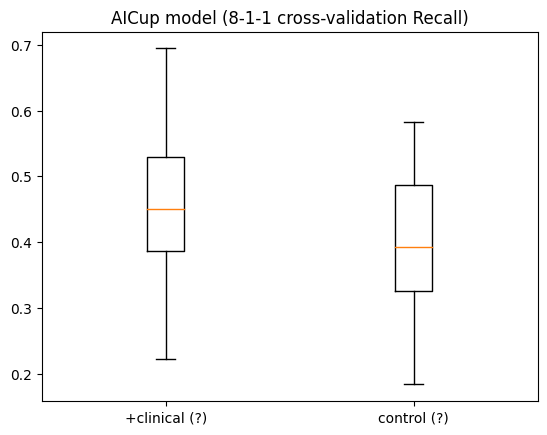

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('AICup model (8-1-1 cross-validation Recall)')
ax1.set_xticklabels(['+clinical (?)','control (?)'])
ax1.boxplot([AUCScores, AUCScores2])

# Genetic Algorithm

In [ ]:
function_inputs = predicted_test_list
desired_output = 1.0

In [ ]:
def fitness_func(t,solution, solution_idx):
  RecallScores = []
  for i in range(60):
    RecallScores.append(recall_score(np.argmax(Y_list[FoldIndicesList[i][1]], axis=-1), np.argmax(function_inputs*solution, axis=-1), average='macro'))
  fitness = np.nanmedian(RecallScores)
  return fitness

In [ ]:
fitness_function = fitness_func

num_generations = 10000
num_parents_mating = 10

sol_per_pop = 10
num_genes = 5

gene_space = [i for i in range(1000)]

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [ ]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_space=gene_space,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       allow_duplicate_genes=False,
                       save_solutions=True)

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:641: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1083: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn(

In [ ]:
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution.astype('int')))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
RecallScores = []
for i in range(60):
  RecallScores.append(recall_score(np.argmax(Y_list[FoldIndicesList[i][1]], axis=-1), np.argmax(function_inputs*solution, axis=-1), average='macro'))
prediction = np.nanmedian(RecallScores)

# prediction = np.nanmean(((function_inputs[solution.astype('int')] - function_inputs)**2))
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

In [ ]:
np.save('./key_GA',solution.astype('int'))

# Infering Public+Private Testing Dataset

In [3]:
!mkdir "Public Testing Dataset"
!unzip "Public Testing Dataset.zip" -d ./
!rm "Public Testing Dataset.zip"

mkdir: cannot create directory ‘Public Testing Dataset’: File exists
cp: cannot stat './gdrive/MyDrive/ColabNotebooks/Competitions/AICup/Public Testing Dataset.zip': No such file or directory
unzip:  cannot find or open Public Testing Dataset.zip, Public Testing Dataset.zip.zip or Public Testing Dataset.zip.ZIP.
rm: cannot remove 'Public Testing Dataset.zip': No such file or directory


In [ ]:
!ls "Public Testing Dataset"

submission_template_public.csv	test_datalist_public.csv  test_data_public


In [4]:
!mkdir "Private Testing Dataset"
!unzip "Private Testing Dataset.zip" -d ./
!rm "Private Testing Dataset.zip"

unzip:  cannot find or open Private Testing Dataset.zip, Private Testing Dataset.zip.zip or Private Testing Dataset.zip.ZIP.
rm: cannot remove 'Private Testing Dataset.zip': No such file or directory


In [ ]:
!ls "Private Testing Dataset"

submission_template_private.csv		test_datalist_private.csv
submission_template_public+private.csv	test_data_private


In [ ]:
dataList2 = listdir(data_folder_path2+"/test_data_public")
dataList3 = listdir(data_folder_path3+"/test_data_private")
len(dataList2), len(dataList3)

(500, 500)

In [ ]:
TrainTable2 = pd.concat([pd.read_csv(data_folder_path2+"/test_datalist_public.csv"), pd.read_csv(data_folder_path3+"/test_datalist_private.csv")])
TrainTable2.head()

,ID,Sex,Age,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,heartburn,Choking,...,Onset of dysphonia,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10
0,1301skj,2,27,0,1,1,1,1,0,0,...,2,3,1,0,0,0,0,0,0,30.0
1,1100j0u,1,50,0,0,0,0,0,0,0,...,1,2,2,0,1,0,0,0,0,30.0
2,0G00r5c,1,41,1,1,0,0,0,0,0,...,5,2,3,0,0,0,0,0,0,29.0
3,1202v5m,2,48,1,0,0,1,1,0,0,...,2,1,4,0,0,0,0,0,0,5.0
4,0C01365,2,43,0,1,0,1,0,1,1,...,1,2,1,0,0,1,0,0,0,27.0


In [ ]:
TrainTable2.shape

(1000, 27)

In [ ]:
TrainTable2.columns

Index(['ID', 'Sex', 'Age', 'Narrow pitch range', 'Decreased volume', 'Fatigue',
       'Dryness', 'Lumping', 'heartburn', 'Choking', 'Eye dryness', 'PND',
       'Smoking', 'PPD', 'Drinking', 'frequency', 'Diurnal pattern',
       'Onset of dysphonia ', 'Noise at work', 'Occupational vocal demand',
       'Diabetes', 'Hypertension', 'CAD', 'Head and Neck Cancer',
       'Head injury', 'CVA', 'Voice handicap index - 10'],
      dtype='object')

In [ ]:
AllCol = np.load('./AllCol.npy', allow_pickle=True)
AllCol

array(['Age', 'PPD', 'Voice handicap index - 10', 'Sex_1', 'Sex_2',
       'Narrow pitch range_0', 'Narrow pitch range_1',
       'Decreased volume_0', 'Decreased volume_1', 'Fatigue_0',
       'Fatigue_1', 'Dryness_0', 'Dryness_1', 'Lumping_0', 'Lumping_1',
       'heartburn_0', 'heartburn_1', 'Choking_0', 'Choking_1',
       'Eye dryness_0', 'Eye dryness_1', 'PND_0', 'PND_1', 'Smoking_0',
       'Smoking_1', 'Smoking_2', 'Smoking_3', 'Drinking_0', 'Drinking_1',
       'Drinking_2', 'frequency_0', 'frequency_1', 'frequency_2',
       'frequency_3', 'Diurnal pattern_1', 'Diurnal pattern_2',
       'Diurnal pattern_3', 'Diurnal pattern_4', 'Onset of dysphonia _1',
       'Onset of dysphonia _2', 'Onset of dysphonia _3',
       'Onset of dysphonia _4', 'Onset of dysphonia _5',
       'Noise at work_1', 'Noise at work_2', 'Noise at work_3',
       'Occupational vocal demand_1', 'Occupational vocal demand_2',
       'Occupational vocal demand_3', 'Occupational vocal demand_4',
       'Diab

In [ ]:
numerical2 = TrainTable2[['ID', 'Age','PPD', 'Voice handicap index - 10']].copy()
categorical2 = TrainTable2[['Sex', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA']].copy().astype('str')
categorical2 = pd.get_dummies(categorical2).copy()
categorical2['ID'] = TrainTable2['ID']
TrainTable2 = pd.merge(numerical2, categorical2, on="ID")
TrainTable2.head()

,ID,Age,PPD,Voice handicap index - 10,Sex_1,Sex_2,Narrow pitch range_0,Narrow pitch range_1,Decreased volume_0,Decreased volume_1,...,Hypertension_0,Hypertension_1,CAD_0,CAD_1,Head and Neck Cancer_0,Head and Neck Cancer_1,Head injury_0,Head injury_1,CVA_0,CVA_1
0,1301skj,27,NaN,30.0,0,1,1,0,0,1,...,1,0,1,0,1,0,1,0,1,0
1,1100j0u,50,2.0,30.0,1,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
2,0G00r5c,41,NaN,29.0,1,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
3,1202v5m,48,0.2,5.0,0,1,0,1,1,0,...,1,0,1,0,1,0,1,0,1,0
4,0C01365,43,NaN,27.0,0,1,1,0,0,1,...,1,0,0,1,1,0,1,0,1,0


In [ ]:
AllCol.shape

(62,)

In [ ]:
TrainTable2.values[:,1:].shape

(1000, 62)

In [ ]:
[i for i in AllCol if i not in TrainTable2.columns]

[]

In [ ]:
# TrainTable2['CVA_1'] = 0

In [ ]:
TrainTable2.values[:,1:].shape

(1000, 62)

In [ ]:
TrainTable2 = TrainTable2[np.append("ID", AllCol)]

In [ ]:
dataXList4 = TrainTable2['ID'].values.copy()
dataXList4.shape

(1000,)

In [ ]:
# import librosa
import soundfile as sf
maxLength = 0
for i in tqdm(range(len(dataXList4))):
    print(dataXList4[i])
    if i <500:
        ref, rate = sf.read(data_folder_path2+"test_data_public/"+str(dataXList4[i])+".wav")
    else:
        ref, rate = sf.read(data_folder_path3+"test_data_private/"+str(dataXList4[i])+".wav")
    refLength = len(ref)

    if maxLength <= refLength:
      maxLength = refLength
      print(maxLength, rate)

maxLength

 12%|█▏        | 115/1000 [00:00<00:01, 576.70it/s]

1301skj
132300 44100
1100j0u
132300 44100
0G00r5c
132300 44100
1202v5m
132300 44100
0C01365
1302gp2
132300 44100
0T00ted
0U01og8
12030n2
0W00632
1000mdu
0602sqq
13028ek
132300 44100
130204c
1301li6
132300 44100
0J00lhb
132300 44100
0600umh
0K024sv
0701790
1301cla
132300 44100
0A018t9
1301sj1
132300 44100
0G016hn
132300 44100
0F02qrc
132300 44100
1302oal
132300 44100
13019db
132300 44100
0W0291g
1301j5u
132300 44100
0G00v22
132300 44100
0B02gv8
1301qv8
0A00e04
132300 44100
1301mu0
0601nug
0H01tsg
132300 44100
0K02hh8
130254f
132300 44100
1301hni
132300 44100
1302ckn
132300 44100
0F02ani
132300 44100
0B01mh6
13000jf
132300 44100
130270h
132300 44100
0H027kj
132300 44100
0Y030tm
13024l3
0B0119v
132300 44100
0M0249t
0B00id8
132300 44100
0C021tr
132300 44100
0R008j9
13002gs
132300 44100
0K00a53
0M026e8
1301q0t
132300 44100
0G01rk7
132300 44100
12030o2
0G0112e
132300 44100
0700lci
1301c9p
0G01n62
132300 44100
0W01dcr
1301quh
1301s8a
132300 44100
0A01fjn
0T00nsl
0M023ha
1000pb2
13019dp
0R015s

 23%|██▎       | 232/1000 [00:00<00:01, 575.17it/s]

0M009e1
132300 44100
0M01glg
132300 44100
13027no
132300 44100
0B02e6a
132300 44100
0F00atr
132300 44100
0G00n0o
132300 44100
0F02app
132300 44100
0F021ds
1301ija
132300 44100
0H0148p
0Y006cl
1301hlt
1302eeq
0301ve2
0J02066
0A00utd
1302ao4
1302ko4
0Y01tif
1000n4n
132300 44100
1202unf
1301sii
132300 44100
0C01721
132300 44100
1301v3h
132300 44100
0K02st1
0H02cde
0A00tc0
132300 44100
1301tv6
132300 44100
0801le9
1202qag
1301mbg
132300 44100
0R00aba
1302451
132300 44100
0B02erj
132300 44100
0A0270f
0M0118n
0U02cc3
10002n3
13023ef
132300 44100
0B018f8
13007d1
132300 44100
0B0222n
132300 44100
0Y00g3k
0C00lp1
0601mh7
0A00cnp
13023fm
132300 44100
13000j3
132300 44100
0301kjg
0T026cp
0M024pb
0G003je
132300 44100
0M00pnl
0A015h2
132300 44100
0T02qea
1301ii9
132300 44100
0Y00nr6
0U00lcp
10004fs
1301qm4
13016if
132300 44100
06008be
132300 44100
0A031kn
1301v4e
1302m1r
0M01e0j
132300 44100
1301rkq
0A01kc4
132300 44100
0C00mbq
132300 44100
1300olo
132300 44100
0H015g4
1301rlq
0W029bd
0H014nv
0H02u

 35%|███▌      | 350/1000 [00:00<00:01, 581.52it/s]

132300 44100
0G018t8
132300 44100
1201tab
132300 44100
1301j4o
132300 44100
0C006lk
132300 44100
1302mlv
0Y02589
1202mph
132300 44100
0A01b11
0802bld
0F02sho
132300 44100
0K00lb4
13028pm
132300 44100
1301cl7
132300 44100
0J00d64
0B027ag
132300 44100
0702fpc
1302nsm
132300 44100
0J01hlo
132300 44100
1302ie6
0B00cgn
132300 44100
0F008ie
132300 44100
0M02b8v
0B017go
0802hrg
1001p5a
1301f0b
132300 44100
1301oqb
132300 44100
1302is3
13005tc
132300 44100
0G01m4q
132300 44100
0Y02bv3
0A0020c
0C020c2
132300 44100
0M0020q
11000ag
1302fsd
0A00g2q
1301c81
0100uoo
1301dsv
132300 44100
0R006jd
1301s5i
1301ncm
132300 44100
0F00e1p
132300 44100
0J00lnb
0H003v3
0H01gnd
132300 44100
0J028gf
1301u09
132300 44100
0K011p8
0J02nf0
0F00svd
132300 44100
0G015l3
132300 44100
0K02k2r
0H00q15
0J01poo
0K01of3
13019oe
1300196
132300 44100
0A01j0g
132300 44100
1301aju
0M021uc
0F02u02
132300 44100
0F02g59
132300 44100
0F00nk8
132300 44100
0G01blp
132300 44100
1301hm5
130254j
1301clh
132300 44100
0B001qh
0Y02dvt
0C0

 47%|████▋     | 472/1000 [00:00<00:00, 589.51it/s]

1301tci
132300 44100
0R00cid
1302lpe
0702gr9
0301kbn
13026jo
132300 44100
1000oip
1302m24
0J02566
1300mt8
132300 44100
0A01576
132300 44100
0G02s7t
13000hp
132300 44100
0R01if8
0R00alc
1302424
0A016ob
1302c70
132300 44100
0F00qcs
132300 44100
1301qh6
132300 44100
09009dn
0000c0a
0M00lok
132300 44100
10025eb
132300 44100
1302pia
132300 44100
13019nh
132300 44100
1000qe9
0G00qsu
132300 44100
0T00las
0K014u4
1301evn
132300 44100
0201iel
0S021gh
0G00aan
132300 44100
130244u
132300 44100
0H006o0
132300 44100
13026u6
132300 44100
1301fil
132300 44100
12030o1
1301qj5
132300 44100
1302e4n
0T01rlv
0W003gp
10009js
13028qh
132300 44100
0C001pg
0901ah3
132300 44100
1301l5m
132300 44100
05021ge
132300 44100
13000k0
132300 44100
0A02vd3
132300 44100
0F021g3
0H011vi
1301tu1
132300 44100
0M01r7b
1301jj4
132300 44100
0R00ie0
0T00lkv
05030k6
13021sr
132300 44100
0B00akq
132300 44100
10009ut
13022kb
132300 44100
0001ai2
13002gt
132300 44100
0U01mis
0C02ip9
132300 44100
0J00t8f
132300 44100
0A008db
0C01sg

 61%|██████    | 608/1000 [00:01<00:00, 637.55it/s]

132300 44100
1301tuf
132300 44100
0J02om3
0A01g2k
132300 44100
130243h
132300 44100
1302lp3
0J02n2u
1000221
1300hnu
132300 44100
0H01for
132300 44100
1302hnk
1301s8k
132300 44100
0K01osq
0M02htu
1302btr
0H015l5
0H010k0
0k01qr8
0T02iml
1202uos
132300 44100
1301ncd
0J024fq
0C0147g
132300 44100
13021ib
110049h
0T01khc
0C02cr3
132300 44100
0U02g8u
0Y00jid
0R02296
0W016c9
11006gd
10015uq
1001402
132300 44100
1001abr
0Y029vr
0T01r2g
0Y01uj6
0W01g5d
100161i
132300 44100
0W00ai7
08030kk
132300 44100
0Y00aq1
10000gk
0C00tln
01011ql
0Y00bjb
0W00t7l
100159m
132300 44100
1001jje
132300 44100
0W00k6d
0U02sef
0W014uf
0U023fr
1002l05
100140m
132300 44100
0W00hpv
1000g51
1002j3t
0302kv9
1002ol5
060142m
1001ab4
01024cj
0T02c7f
1000pj8
07023sn
0U01ft6
1001hqh
132300 44100
05019iq
1002220
132300 44100
0Y01qob
0T0139l
0Y014vq
0Y00jm1
0U0011i
0W01lsi
0Y02bbb
08010oa
132300 44100
0Y0053e
0400n0h
0S01spi
1100361
11006sp
0W02vjb
0902e1m
10017tm
0T01q6k
10011k4
0T01s9a
0402j34
0Y01bhe
100216c
110018s
0W02peb
0

 75%|███████▍  | 747/1000 [00:01<00:00, 668.30it/s]

0Y01la2
0W00jiq
0W02t4d
0F020fn
132300 44100
0R01q54
0W011dm
0W02fr6
0F020q2
1002ri3
1001ulj
132300 44100
1001srt
132300 44100
0402t2r
0H00crb
0W01q0t
0Y013hq
0Y011cq
0Y028ba
0R018tk
0W00mr2
0Y02r9g
0S00pv2
0W01fr2
1001uln
132300 44100
1003124
0U00ncn
0Y00217
0W014ei
1001529
132300 44100
0Y02g9m
0G013dj
0Y004k9
0Y0306q
0502v0g
0Y02g9e
0T027id
0Y02gja
04013ns
132300 44100
0Y023e8
0H00fr6
0W02fve
0902ife
0W02q3i
11001ab
1002ieq
0502sia
0W01ia4
0Y02hmk
0U00r9t
0W00hqc
0Y02goq
0Y01k5r
0W020oa
0H004vr
1001kfl
132300 44100
0Y015pd
1002obt
0R01kfb
03000ig
100075c
0Y00nms
1001fqb
132300 44100
0B00490
132300 44100
0W0308f
0W024c3
0W010lo
0W01fqm
0U02dsf
10020b5
0W00buf
09027jf
1001qe7
132300 44100
0U023ik
0302cjf
1002p6s
110036q
0Y01t94
1000n59
10025if
0W01qv4
1001i6m
132300 44100
0W00if4
0Y00r0l
0Y005nn
0002aca
0U02lao
1002qkq
10013au
132300 44100
0J01g20
1001tpm
0W00sqd
0W00h8t
0Y027vp
0Y0218j
10017k2
1001krq
0Y00tkv
0W018ds
1002mgh
0101ulg
0Y02g90
1001bti
0H00u5o
0M01618
0Y0151r
0Y021qt
1000

 89%|████████▊ | 887/1000 [00:01<00:00, 684.11it/s]

0U016nv
0402eoc
0Y020t2
0T02hgb
0H02vq8
0W00ko2
10012kt
132300 44100
0R00jnq
0Y01d31
0Y00qnj
0302nk7
0Y00ptm
0Y0098l
0U007ta
0W00v05
1001521
132300 44100
0W0150s
0T02lm3
0F00jj3
0R0190n
0W01gdi
0500e3n
1001isc
132300 44100
0C02umg
132300 44100
0W00tki
0Y02cls
0S00h6u
1002f84
0W00m9l
0Y00252
0S02tsp
0W02gih
0Y01fm5
0W02mai
0Y02tkc
0T01r3j
0W028pf
0U016lf
0W01oej
1001kgl
09012dj
132300 44100
0S009c6
0S00dsh
0R01u5d
100159h
132300 44100
0Y00sg8
0H02oso
02011hc
132300 44100
0W02tah
0Y02q5v
0C021ob
0W00pmk
0W00tgd
0T01j3l
0G022aj
0R02ns8
10000hr
0Y0171h
11006gh
0001dg0
132300 44100
0300csm
0T01087
0S00agl
0Y00236
1002dru
0Y020s3
0Y008vi
0802cbi
0R0297v
0Y00ntv
0T0085h
0W02hvs
0R00roo
0U02ni5
0S02341
0901mh7
132300 44100
08006o6
10026d7
1000i65
0W00m6r
0G026ee
1001ul3
030272m
0W02ppq
0U0139c
0602nc4
0W01h80
0Y031e9
0J025li
0R00b8j
0W01emb
0W027qt
0W01qei
0W00t8r
0W016ap
0Y00a1d
0T020gc
0G012re
0Y02rkn
0W00c0f
0u02q3q
11003qd
0W02eau
0W01a47
0W024c1
1001d99
1001gic
132300 44100
100179f
1001ac

100%|██████████| 1000/1000 [00:01<00:00, 635.91it/s]

132300 44100
0T00rb7
0300e2m
0Y02eon
0W00p14
0R00jbk
0Y0021p
0W02pqk
0W021cg
0W02qrm
0Y02c2e
0T02m1d
0W00v27
0W00ftq
1100blb
132300 44100
0J02j3q
0U02n6a
0Y02r83
0R02aal
0Y02q4e
0T00sqv
0Y01562
0W01imo
0W02v95
0M01p2k
0S00sd2
0R02toa
1001i68
132300 44100
0Y000si
0U01urv
0R01b0j
0W02ved
0R03090
0Y00he3
0Y01k36
0T0064u
0300j17
0Y01b72
0Y00ap8
0M02rf3
1001o8g
01007l8
0U031kc
1002lbq
10016jm
132300 44100
0Y01bcv
0W01qn5
100177l
0W0163j
0Y00pnn
0S01m50
0T00u79
0S02eko
0R0264d
1000742
0Y02v56
0W01ltt
0Y00j38
10029cp
0Y028bf
0W00fsv
0Y02eo3
1002db7
0800ftl
0Y02ion
0W01qii
10016a7
02024f0
0W01jhr
05005ql
0W02jrq
1000qem
0Y01lbp
0Y02t7n
0Y01urg
0000c2s
132300 44100
0W0227b
0W01gf0
0Y02qfl
0T02nv9
0T02880
1001428
132300 44100
0Y012dv
0802gef
0S00ubc
1002lbp
0U024bi
0W01j18
100149i
132300 44100
0Y0306s
0W01r3i
0C02gec
0Y028p4
03005so
132300 44100
0W01qt4
1001uk4
132300 44100
1001gh1
132300 44100
0W00t01
0U00dpv
0U00c61
0W02vde
1002jv1
0Y00i47
1001abu
1002ss4
0W011bi
0R00num
0Y02gae


132300

In [ ]:
X_list_test = []
for i in tqdm(range(len(dataXList4))):
    patient = np.zeros((132300,1), dtype=np.float32)
    if i <500:
        rawValues, rate = sf.read(data_folder_path2+"test_data_public/"+str(dataXList4[i])+".wav")
    else:
        rawValues, rate = sf.read(data_folder_path3+"test_data_private/"+str(dataXList4[i])+".wav")
    mu = np.nanmean(rawValues)
    std = np.nanstd(rawValues)
    patient[-len(rawValues):,0] = (rawValues-mu)/std
    X_list_test.append(patient)
X_list_test = np.asarray(X_list_test)
print(X_list_test.shape)

np.save('./AICupX_list_test',X_list_test)

100%|██████████| 1000/1000 [00:03<00:00, 269.35it/s]


(1000, 132300, 1)


In [ ]:
X_list_test = np.load('./AICupX_list_test.npy', allow_pickle=True).astype('float32')
X_list_label2 = TrainTable2.copy()
X_list_label2.values.shape

(1000, 63)

In [ ]:
CODAMuStd = np.load('./AICupMuStd.npy', allow_pickle=True).astype('float32')
CODAMuStd

array([[48.614    ,  0.7964673, 23.090635 ],
       [15.190886 ,  0.4638579,  9.321377 ]], dtype=float32)

In [ ]:
for i in range(3):
  X_list_label2[AllCol[i]] = (X_list_label2[AllCol[i]].astype('float32')-CODAMuStd[0,i])/CODAMuStd[1,i]
  X_list_label2[AllCol[i]] = X_list_label2[AllCol[i]].fillna(0).copy()
X_list_label2

,ID,Age,PPD,Voice handicap index - 10,Sex_1,Sex_2,Narrow pitch range_0,Narrow pitch range_1,Decreased volume_0,Decreased volume_1,...,Hypertension_0,Hypertension_1,CAD_0,CAD_1,Head and Neck Cancer_0,Head and Neck Cancer_1,Head injury_0,Head injury_1,CVA_0,CVA_1
0,1301skj,-1.422827,0.000000,0.741239,0,1,1,0,0,1,...,1,0,1,0,1,0,1,0,1,0
1,1100j0u,0.091239,2.594615,0.741239,1,0,1,0,1,0,...,0,1,1,0,1,0,1,0,1,0
2,0G00r5c,-0.501221,0.000000,0.633958,1,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
3,1202v5m,-0.040419,-1.285884,-1.940769,0,1,0,1,1,0,...,1,0,1,0,1,0,1,0,1,0
4,0C01365,-0.369564,0.000000,0.419398,0,1,1,0,0,1,...,1,0,0,1,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1001abu,-1.291169,0.000000,1.706761,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
996,1002ss4,1.868621,0.000000,-0.224284,0,1,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
997,0W011bi,-0.303735,0.000000,0.419398,1,0,1,0,0,1,...,1,0,1,0,1,0,1,0,1,0
998,0R00num,0.947015,0.000000,1.814041,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0


In [ ]:
template = pd.read_csv(data_folder_path3+"/submission_template_public+private.csv", header = None)
template.head()

,0,1
0,1301skj,5
1,1100j0u,5
2,0G00r5c,5
3,1202v5m,5
4,0C01365,5


In [ ]:
template.shape

(1000, 2)

In [ ]:
predictions = np.zeros([template.shape[0],5])
for i in tqdm(range(60)):
  pre_model = MetforNet121(132300)
  model = MetforNetEF(132300, pre_model, 1)
  model.load_weights('./double_separate/AICup_10folds_sigmoid_double_separate_fold_'+str(i))
  predictions += model.predict([X_list_test, X_list_label2.values[:,1:].astype('float32')])[0]
predictions /=60
predictions

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


32/32 [==============================] - 17s 201ms/step


  2%|▏         | 1/60 [00:27<26:39, 27.11s/it]

32/32 [==============================] - 7s 183ms/step


  3%|▎         | 2/60 [00:41<19:11, 19.85s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 8s 174ms/step


  5%|▌         | 3/60 [00:53<15:14, 16.04s/it]

32/32 [==============================] - 7s 185ms/step


  7%|▋         | 4/60 [01:07<14:17, 15.32s/it]

32/32 [==============================] - 7s 187ms/step


  8%|▊         | 5/60 [01:17<12:19, 13.44s/it]

32/32 [==============================] - 7s 178ms/step


 10%|█         | 6/60 [01:27<11:04, 12.30s/it]

32/32 [==============================] - 8s 216ms/step


 12%|█▏        | 7/60 [01:42<11:32, 13.07s/it]

32/32 [==============================] - 7s 178ms/step


 13%|█▎        | 8/60 [01:56<11:42, 13.51s/it]

32/32 [==============================] - 7s 177ms/step


 15%|█▌        | 9/60 [02:11<11:41, 13.75s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 7s 186ms/step


 17%|█▋        | 10/60 [02:27<12:09, 14.58s/it]

32/32 [==============================] - 7s 190ms/step


 18%|█▊        | 11/60 [02:37<10:48, 13.22s/it]

32/32 [==============================] - 7s 180ms/step


 20%|██        | 12/60 [02:47<09:46, 12.22s/it]

32/32 [==============================] - 6s 171ms/step


 22%|██▏       | 13/60 [02:57<09:03, 11.56s/it]

32/32 [==============================] - 6s 171ms/step


 23%|██▎       | 14/60 [03:12<09:32, 12.44s/it]

32/32 [==============================] - 8s 209ms/step


 25%|██▌       | 15/60 [03:26<09:46, 13.04s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 7s 181ms/step


 27%|██▋       | 16/60 [03:38<09:18, 12.69s/it]

32/32 [==============================] - 6s 170ms/step


 28%|██▊       | 17/60 [03:52<09:28, 13.23s/it]

32/32 [==============================] - 6s 176ms/step


 30%|███       | 18/60 [04:07<09:28, 13.54s/it]

32/32 [==============================] - 7s 183ms/step


 32%|███▏      | 19/60 [04:17<08:31, 12.47s/it]

32/32 [==============================] - 6s 172ms/step


 33%|███▎      | 20/60 [04:27<07:48, 11.71s/it]

32/32 [==============================] - 6s 172ms/step


 35%|███▌      | 21/60 [04:36<07:13, 11.12s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 10s 197ms/step


 37%|███▋      | 22/60 [04:50<07:25, 11.73s/it]

32/32 [==============================] - 7s 183ms/step


 38%|███▊      | 23/60 [05:04<07:42, 12.50s/it]

32/32 [==============================] - 7s 186ms/step


 40%|████      | 24/60 [05:18<07:47, 13.00s/it]

32/32 [==============================] - 8s 226ms/step


 42%|████▏     | 25/60 [05:29<07:18, 12.52s/it]

32/32 [==============================] - 7s 182ms/step


 43%|████▎     | 26/60 [05:40<06:48, 12.02s/it]

32/32 [==============================] - 7s 174ms/step


 45%|████▌     | 27/60 [05:56<07:16, 13.24s/it]

32/32 [==============================] - 9s 265ms/step


 47%|████▋     | 28/60 [06:09<06:56, 13.01s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 8s 240ms/step


 48%|████▊     | 29/60 [06:25<07:11, 13.93s/it]

32/32 [==============================] - 7s 182ms/step


 50%|█████     | 30/60 [06:35<06:23, 12.78s/it]

32/32 [==============================] - 6s 173ms/step


 52%|█████▏    | 31/60 [06:45<05:47, 11.98s/it]

32/32 [==============================] - 7s 172ms/step


 53%|█████▎    | 32/60 [07:00<05:57, 12.76s/it]

32/32 [==============================] - 6s 171ms/step


 55%|█████▌    | 33/60 [07:14<05:59, 13.33s/it]

32/32 [==============================] - 6s 173ms/step


 57%|█████▋    | 34/60 [07:29<05:55, 13.66s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 7s 187ms/step


 58%|█████▊    | 35/60 [07:41<05:33, 13.35s/it]

32/32 [==============================] - 7s 178ms/step


 60%|██████    | 36/60 [07:56<05:26, 13.62s/it]

32/32 [==============================] - 7s 185ms/step


 62%|██████▏   | 37/60 [08:06<04:47, 12.52s/it]

32/32 [==============================] - 6s 173ms/step


 63%|██████▎   | 38/60 [08:20<04:48, 13.10s/it]

32/32 [==============================] - 7s 177ms/step


 65%|██████▌   | 39/60 [08:34<04:41, 13.42s/it]

32/32 [==============================] - 7s 188ms/step


 67%|██████▋   | 40/60 [08:45<04:11, 12.56s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 9s 191ms/step


 68%|██████▊   | 41/60 [09:01<04:22, 13.79s/it]

32/32 [==============================] - 7s 181ms/step


 70%|███████   | 42/60 [09:16<04:10, 13.93s/it]

32/32 [==============================] - 7s 187ms/step


 72%|███████▏  | 43/60 [09:26<03:37, 12.78s/it]

32/32 [==============================] - 6s 173ms/step


 73%|███████▎  | 44/60 [09:36<03:10, 11.94s/it]

32/32 [==============================] - 6s 172ms/step


 75%|███████▌  | 45/60 [09:50<03:10, 12.70s/it]

32/32 [==============================] - 6s 171ms/step


 77%|███████▋  | 46/60 [10:00<02:45, 11.84s/it]

32/32 [==============================] - 6s 173ms/step


 78%|███████▊  | 47/60 [10:10<02:26, 11.30s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 7s 186ms/step


 80%|████████  | 48/60 [10:28<02:39, 13.25s/it]

32/32 [==============================] - 7s 174ms/step


 82%|████████▏ | 49/60 [10:43<02:30, 13.68s/it]

32/32 [==============================] - 6s 173ms/step


 83%|████████▎ | 50/60 [10:53<02:05, 12.58s/it]

32/32 [==============================] - 7s 175ms/step


 85%|████████▌ | 51/60 [11:03<01:46, 11.89s/it]

32/32 [==============================] - 7s 191ms/step


 87%|████████▋ | 52/60 [11:13<01:31, 11.39s/it]

32/32 [==============================] - 7s 179ms/step


 88%|████████▊ | 53/60 [11:23<01:16, 10.96s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 7s 179ms/step


 90%|█████████ | 54/60 [11:40<01:17, 12.89s/it]

32/32 [==============================] - 7s 180ms/step


 92%|█████████▏| 55/60 [11:55<01:06, 13.27s/it]

32/32 [==============================] - 7s 205ms/step


 93%|█████████▎| 56/60 [12:09<00:54, 13.55s/it]

32/32 [==============================] - 7s 189ms/step


 95%|█████████▌| 57/60 [12:19<00:37, 12.53s/it]

32/32 [==============================] - 6s 174ms/step


 97%|█████████▋| 58/60 [12:29<00:23, 11.71s/it]

32/32 [==============================] - 6s 174ms/step


 98%|█████████▊| 59/60 [12:39<00:11, 11.18s/it]WARNING:tensorflow:Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


32/32 [==============================] - 11s 195ms/step


100%|██████████| 60/60 [12:53<00:00, 12.88s/it]


array([[ 0.81226505,  0.18586805, -0.01779148,  0.04709183,  0.0434284 ],
       [ 0.42354199,  0.26871864,  0.12169264,  0.16818653, -0.0096793 ],
       [ 0.22140904,  0.43838194,  0.28434638,  0.04708695,  0.05030495],
       ...,
       [ 0.17406573,  0.37944506,  0.11994673,  0.06341912,  0.09987385],
       [ 0.11807501,  0.13769235,  0.55927246,  0.07621562,  0.00793276],
       [ 1.07256429, -0.04177754, -0.03999432,  0.02633334,  0.02496486]])

In [ ]:
predictions[predictions>=1] = 1
predictions[predictions<0] = 0

In [ ]:
predictions.shape

(1000, 5)

In [ ]:
solution = np.load('./key_GA.npy')
solution

array([100, 185, 381, 478, 975])

In [ ]:
len(np.argmax(predictions*solution, axis = 1)+1)

1000

In [ ]:
np.argmax(predictions*solution, axis = 1)+1

array([1, 4, 3, 1, 3, 1, 5, 3, 5, 2, 3, 1, 1, 1, 1, 1, 3, 1, 3, 5, 3, 2,
       2, 1, 1, 3, 1, 1, 2, 1, 3, 2, 1, 3, 2, 3, 5, 2, 5, 2, 3, 1, 1, 1,
       3, 2, 2, 1, 3, 1, 1, 1, 1, 1, 2, 5, 1, 1, 3, 1, 1, 5, 1, 3, 3, 2,
       1, 3, 3, 3, 1, 5, 1, 2, 3, 1, 3, 2, 5, 1, 5, 1, 3, 1, 5, 2, 1, 2,
       3, 2, 5, 1, 3, 1, 2, 2, 1, 2, 3, 2, 1, 5, 1, 1, 3, 2, 3, 3, 1, 2,
       1, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 3, 5, 5, 1, 3, 3, 1,
       1, 3, 1, 1, 1, 3, 2, 2, 5, 3, 1, 3, 2, 2, 2, 1, 3, 1, 3, 3, 3, 2,
       1, 1, 1, 3, 3, 3, 2, 1, 1, 3, 5, 2, 1, 1, 2, 1, 1, 2, 5, 3, 1, 2,
       3, 3, 3, 5, 2, 5, 2, 3, 3, 3, 1, 5, 1, 2, 2, 1, 2, 3, 1, 3, 1, 1,
       1, 3, 1, 1, 2, 3, 3, 3, 2, 5, 1, 1, 3, 2, 1, 2, 3, 5, 5, 1, 2, 2,
       1, 1, 3, 1, 1, 1, 2, 1, 1, 2, 1, 2, 5, 1, 1, 2, 3, 5, 1, 3, 3, 1,
       3, 1, 1, 3, 2, 1, 5, 3, 2, 1, 1, 2, 1, 1, 1, 3, 3, 2, 1, 5, 2, 1,
       3, 1, 5, 1, 3, 1, 3, 1, 3, 1, 2, 1, 2, 5, 5, 3, 5, 1, 1, 5, 1, 1,
       1, 1, 3, 2, 1, 3, 3, 1, 5, 1, 1, 1, 2, 1, 5,

In [ ]:
template[1] = np.argmax(predictions*solution, axis = 1)+1
template

,0,1
0,1301skj,1
1,1100j0u,4
2,0G00r5c,3
3,1202v5m,1
4,0C01365,3
...,...,...
995,1001abu,3
996,1002ss4,3
997,0W011bi,5
998,0R00num,3


In [ ]:
template.to_csv('./submission05182.csv', header = None, index =0)
template.head()

,0,1
0,1301skj,1
1,1100j0u,4
2,0G00r5c,3
3,1202v5m,1
4,0C01365,3


In [ ]:
submission = pd.read_csv('./submission05182.csv', header = None)
submission.head()

,0,1
0,1301skj,1
1,1100j0u,4
2,0G00r5c,3
3,1202v5m,1
4,0C01365,3


# Create requirements.txt

In [ ]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

In [ ]:
!ls

 gdrive			   'Public Testing Dataset'   sample_data
'Private Testing Dataset'   requirements.txt	     'Training Dataset'
